# Library import

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import bs4 as bs
import pickle
import requests
import time
import lxml
from datetime import datetime, timedelta

import yfinance as yf
import stockstats

import unicodedata
import json
from textblob import TextBlob

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, TimeDistributed, RepeatVector, LSTM
# from keras.layers import CuDNNLSTM as LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from tensorflow.python.compiler.tensorrt import trt_convert as trt

Using TensorFlow backend.


# Read Data

In [2]:
stock_without_absolute = pd.read_pickle('./data/stock_without_absolute.pkl')
stock_with_absolute = pd.read_pickle('./data/stock_with_absolute.pkl')

label_abs_1d = pd.read_pickle('./data/label_abs_1d.pkl')
label_abs_7d = pd.read_pickle('./data/label_abs_7d.pkl')
label_abs_30d = pd.read_pickle('./data/label_abs_30d.pkl')

label_value_1d = pd.read_pickle('./data/label_value_1d.pkl')
label_value_7d = pd.read_pickle('./data/label_value_7d.pkl')
label_value_30d = pd.read_pickle('./data/label_value_30d.pkl')

In [3]:
len(stock_with_absolute.columns)

92

# Normalize Data & Build Batches

In [4]:
scaler_with_abs = MinMaxScaler()
stock_with_abs_norm = scaler_with_abs.fit_transform(stock_with_absolute)

scaler_without_abs = MinMaxScaler()
stock_without_abs_norm = scaler_without_abs.fit_transform(stock_without_absolute)


In [5]:
RANDOM_SEED = 10
def build_batch(train, label, pastDay=30, futureDay=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train[i:i+pastDay]))
        Y_train.append(np.array(label[i+pastDay:i+pastDay+futureDay]))
    return np.array(X_train), np.array(Y_train)

In [6]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
#     print('trim: ', no_of_rows_drop)
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [7]:
def result(predicted_test, test_label, predicted_train, train_label, predicted_valid, valid_label,
           file_name, decision_function, clf_name="LSTM"):
    print("Results for ", clf_name, ": ")
    acc_train = accuracy_score(train_label, predicted_train)
    acc_test = accuracy_score(test_label, predicted_test)
    acc_valid = accuracy_score(valid_label, predicted_valid)
    print("The Train Accuracy  %0.3f" % (acc_train))
    print("The Validation Accuracy  %0.3f" % (acc_valid))
    print("The Test Accuracy   %0.3f" % (acc_test ))

    print("AUC ROC : %0.3f" %( roc_auc_score(test_label, predicted_test)))
    # confusion matrix
    print("confusion matrix / precision recall scores")
    print ( confusion_matrix(test_label, predicted_test) )
    print ( classification_report(test_label, predicted_test))
    
    f = open(file_name+'.txt','w')
    f.write("The Train Accuracy %0.3f\n" % (acc_train))
    f.write("The Validation Accuracy %0.3f\n" % (acc_valid))
    f.write("The Test Accuracy %0.3f\n" % (acc_test ))
    f.write("AUC ROC : %0.3f\n" %( roc_auc_score(test_label, predicted_test) ))
    f.write( str(confusion_matrix(test_label, predicted_test)) + "\n")
    f.write( str(classification_report(test_label, predicted_test)) + "\n\n")
    f.close()
    
    pass

# Build Different Model

In [8]:
def buildTrendModel_1stacks(shape, hidden_layer_size, batch_size):
    print(shape)
    model = Sequential()
    model.add(LSTM(hidden_layer_size,  batch_input_shape=(batch_size, shape[1], shape[2]), stateful=True, init='glorot_uniform'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy']) # used for Binary classify
#     model.summary()
    return model

In [9]:
def buildTrendModel_1stacks_true_value(shape, hidden_layer_size, batch_size):
    print(shape)
    model = Sequential()
    model.add(LSTM(hidden_layer_size,  batch_input_shape=(batch_size, shape[1], shape[2]), stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(20))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer='adam', metrics=['mae']) # used for Binary classify
#     model.summary()
    return model

In [10]:
def buildTrendModel_2stacks(shape, hidden_layer_size, batch_size):
    model = Sequential()
    model.add(LSTM(hidden_layer_size, return_sequences=True, 
    batch_input_shape=(batch_size, shape[1], shape[2]), stateful=True, init='glorot_uniform'))
    model.add(LSTM(hidden_layer_size, stateful=True, init='glorot_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
#     model.summary()
    return model

In [21]:
def buildTrendModel_2stacks_true_value(shape, hidden_layer_size, batch_size):
    model = Sequential()
    model.add(LSTM(hidden_layer_size, return_sequences=True, batch_input_shape=(batch_size, shape[1], shape[2]), 
            stateful=True))
    model.add(LSTM(hidden_layer_size, stateful=True))
    model.add(Dropout(0.5))
    model.add(Dense(20))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss="mean_squared_error", optimizer='adam', metrics=['mae']) # or sgd
    return model

In [13]:
def buildTrendModel_3stacks(shape, hidden_layer_size, batch_size):
    model = Sequential()
    model.add(LSTM(hidden_layer_size, return_sequences=True, 
    batch_input_shape=(batch_size, shape[1], shape[2]), stateful=True, init='glorot_uniform'))
    model.add(LSTM(hidden_layer_size, return_sequences=True, stateful=True, init='glorot_uniform'))
    model.add(Dropout(0.5))
    model.add(LSTM(hidden_layer_size, stateful=True, init='glorot_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy']) # used for Binary classify
#     model.summary()
    return model

In [14]:
def buildTrendModel_3stacks_true_value(shape, hidden_layer_size, batch_size):
    model = Sequential()
    model.add(LSTM(hidden_layer_size, return_sequences=True, batch_input_shape=(batch_size, shape[1], shape[2]), stateful=True))
    model.add(LSTM(hidden_layer_size, return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(hidden_layer_size, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(20))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer='adam', metrics=['mae']) # or adam
#     model.summary()
    return model

In [15]:
def buildTrendModel_4stacks(shape, hidden_layer_size, batch_size):
    model = Sequential()
    model.add(LSTM(hidden_layer_size, return_sequences=True, 
    batch_input_shape=(batch_size, shape[1], shape[2]), stateful=True, init='glorot_uniform'))
    model.add(LSTM(hidden_layer_size, return_sequences=True, stateful=True, init='glorot_uniform'))
    model.add(Dropout(0.5))
    model.add(LSTM(hidden_layer_size, return_sequences=True, stateful=True, init='glorot_uniform'))
    model.add(LSTM(hidden_layer_size, stateful=True, init='glorot_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy']) # used for Binary classify
#     model.summary()
    return model

In [18]:
def model_train(build_model_func, PAST_DAYS, stock_data, label, hidden_layer_size, batch_size, monitor, epochs):
    X_train_batches, y_train_batches = build_batch(stock_data, label, PAST_DAYS, 1)
    X_train, X_test, y_train, y_test = train_test_split(X_train_batches, y_train_batches, test_size=0.1, shuffle = False, stratify = None)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle = False, stratify = None)
    
    X_train = trim_dataset(X_train, batch_size)
    y_train = trim_dataset(y_train, batch_size)
    X_valid = trim_dataset(X_valid, batch_size)
    y_valid = trim_dataset(y_valid, batch_size)
    X_test = trim_dataset(X_test, batch_size)
    y_test = trim_dataset(y_test, batch_size)
    
    
    model = build_model_func(X_train.shape, hidden_layer_size, batch_size)
    callback = EarlyStopping(monitor=monitor, patience=200, verbose=1, mode="auto")
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1,validation_data=(X_valid, y_valid), callbacks=[callback], shuffle=False)
    return model, X_train, y_train, X_valid, y_valid, X_test, y_test

In [18]:
def model_train_loss(build_model_func, PAST_DAYS, stock_data, label, hidden_layer_size, batch_size):
    X_train_batches, y_train_batches = build_batch(stock_data, label, PAST_DAYS, 1)
    X_train, X_test, y_train, y_test = train_test_split(X_train_batches, y_train_batches, test_size=0.1, shuffle = False, stratify = None)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle = False, stratify = None)
    
    X_train = trim_dataset(X_train, batch_size)
    y_train = trim_dataset(y_train, batch_size)
    X_valid = trim_dataset(X_valid, batch_size)
    y_valid = trim_dataset(y_valid, batch_size)
    X_test = trim_dataset(X_test, batch_size)
    y_test = trim_dataset(y_test, batch_size)
    
    
    model = build_model_func(X_train.shape, hidden_layer_size, batch_size)
    callback = EarlyStopping(monitor="val_loss", patience=200, verbose=1, mode="min")
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size, verbose=1,validation_data=(X_valid, y_valid), callbacks=[callback], shuffle=False)
    return model, X_train, y_train, X_valid, y_valid, X_test, y_test

# True Value Prediction

# Sequence 3

In [152]:
batch_size = 7
model, X_train, y_train, X_valid, y_valid, X_test, y_test  = model_train(buildTrendModel_2stacks_true_value, 3, 
                                                    stock_with_abs_norm, label_value_1d, 64, batch_size, "loss")

predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
print()
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=7)
print('test loss, test acc:', results)

predictions = model.predict(X_test, batch_size=7)
print('predictions shape:', predictions.shape)

rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)
predictFrame = pd.DataFrame({'prediction': predictions.reshape(X_test.shape[0]), 'true_value': y_test.reshape(X_test.shape[0])})
predictFrame

Train on 1988 samples, validate on 217 samples
Epoch 1/1000
1988/1988 [==============================] - 2s 1ms/step - loss: 574.0231 - mae: 20.6357 - val_loss: 2590.3097 - val_mae: 46.6466
Epoch 2/1000
1988/1988 [==============================] - 1s 623us/step - loss: 1513.5479 - mae: 28.1820 - val_loss: 4213.6496 - val_mae: 61.6380
Epoch 3/1000
1988/1988 [==============================] - 1s 654us/step - loss: 1399.1976 - mae: 28.5140 - val_loss: 4455.8929 - val_mae: 63.5727
Epoch 4/1000
1988/1988 [==============================] - 1s 680us/step - loss: 1375.1698 - mae: 28.3734 - val_loss: 4586.4127 - val_mae: 64.5911
Epoch 5/1000
1988/1988 [==============================] - 1s 702us/step - loss: 1395.7849 - mae: 28.5535 - val_loss: 4617.7082 - val_mae: 64.8329
Epoch 6/1000
1988/1988 [==============================] - 1s 732us/step - loss: 1394.3392 - mae: 28.7477 - val_loss: 4625.4257 - val_mae: 64.8924
Epoch 7/1000
1988/1988 [==============================] - 1s 732us/step - loss: 

Epoch 57/1000
1988/1988 [==============================] - 1s 581us/step - loss: 117.3104 - mae: 8.0043 - val_loss: 535.7444 - val_mae: 17.1828
Epoch 58/1000
1988/1988 [==============================] - 1s 607us/step - loss: 110.1783 - mae: 7.9078 - val_loss: 664.6000 - val_mae: 20.6180
Epoch 59/1000
1988/1988 [==============================] - 1s 582us/step - loss: 114.2171 - mae: 7.7733 - val_loss: 676.7041 - val_mae: 21.5119
Epoch 60/1000
1988/1988 [==============================] - 1s 574us/step - loss: 108.6360 - mae: 7.7472 - val_loss: 610.7437 - val_mae: 19.5799
Epoch 61/1000
1988/1988 [==============================] - 1s 585us/step - loss: 115.2256 - mae: 7.9814 - val_loss: 457.7211 - val_mae: 15.8274
Epoch 62/1000
1988/1988 [==============================] - 1s 616us/step - loss: 102.5545 - mae: 7.5102 - val_loss: 571.4034 - val_mae: 18.4534
Epoch 63/1000
1988/1988 [==============================] - 1s 593us/step - loss: 102.8927 - mae: 7.5548 - val_loss: 567.2865 - val_mae: 

1988/1988 [==============================] - 1s 658us/step - loss: 44.7816 - mae: 4.7776 - val_loss: 374.1794 - val_mae: 14.6698
Epoch 172/1000
1988/1988 [==============================] - 1s 660us/step - loss: 43.9915 - mae: 4.7338 - val_loss: 389.0807 - val_mae: 15.3585
Epoch 173/1000
1988/1988 [==============================] - 1s 674us/step - loss: 44.3156 - mae: 4.7053 - val_loss: 381.5664 - val_mae: 15.8521
Epoch 174/1000
1988/1988 [==============================] - 1s 667us/step - loss: 40.1544 - mae: 4.6616 - val_loss: 324.6167 - val_mae: 14.3729
Epoch 175/1000
1988/1988 [==============================] - 1s 670us/step - loss: 42.1344 - mae: 4.5728 - val_loss: 338.1544 - val_mae: 13.9820
Epoch 176/1000
1988/1988 [==============================] - 1s 694us/step - loss: 41.1773 - mae: 4.6289 - val_loss: 335.6001 - val_mae: 13.9115
Epoch 177/1000
1988/1988 [==============================] - 1s 674us/step - loss: 42.4080 - mae: 4.7982 - val_loss: 178.1245 - val_mae: 10.0371
Epoch 1

Epoch 228/1000
1988/1988 [==============================] - 1s 643us/step - loss: 37.2277 - mae: 4.3790 - val_loss: 407.4132 - val_mae: 15.6201
Epoch 229/1000
1988/1988 [==============================] - 1s 636us/step - loss: 39.5836 - mae: 4.5147 - val_loss: 437.7494 - val_mae: 16.1212
Epoch 230/1000
1988/1988 [==============================] - 1s 671us/step - loss: 37.5236 - mae: 4.4855 - val_loss: 431.5472 - val_mae: 16.1239
Epoch 231/1000
1988/1988 [==============================] - 1s 684us/step - loss: 39.0606 - mae: 4.4845 - val_loss: 446.2162 - val_mae: 16.0455
Epoch 232/1000
1988/1988 [==============================] - 1s 688us/step - loss: 39.2671 - mae: 4.5319 - val_loss: 424.3704 - val_mae: 15.8941
Epoch 233/1000
1988/1988 [==============================] - 1s 710us/step - loss: 36.7581 - mae: 4.3978 - val_loss: 389.7585 - val_mae: 14.9829
Epoch 234/1000
1988/1988 [==============================] - 1s 725us/step - loss: 34.6914 - mae: 4.2238 - val_loss: 299.1130 - val_mae: 

Epoch 285/1000
1988/1988 [==============================] - 1s 675us/step - loss: 35.9979 - mae: 4.2407 - val_loss: 287.3794 - val_mae: 12.5991
Epoch 286/1000
1988/1988 [==============================] - 1s 658us/step - loss: 34.3211 - mae: 4.2363 - val_loss: 277.0888 - val_mae: 12.3937
Epoch 287/1000
1988/1988 [==============================] - 1s 624us/step - loss: 35.9386 - mae: 4.3735 - val_loss: 210.5869 - val_mae: 10.8660
Epoch 288/1000
1988/1988 [==============================] - 1s 602us/step - loss: 36.5355 - mae: 4.3005 - val_loss: 250.7263 - val_mae: 11.7862
Epoch 289/1000
1988/1988 [==============================] - 1s 619us/step - loss: 36.5280 - mae: 4.4063 - val_loss: 246.2625 - val_mae: 11.5469
Epoch 290/1000
1988/1988 [==============================] - 1s 670us/step - loss: 35.0118 - mae: 4.2823 - val_loss: 291.6229 - val_mae: 12.6847
Epoch 291/1000
1988/1988 [==============================] - 1s 704us/step - loss: 37.4116 - mae: 4.4099 - val_loss: 312.5290 - val_mae: 

Epoch 342/1000
1988/1988 [==============================] - 1s 664us/step - loss: 32.0807 - mae: 4.0970 - val_loss: 221.4397 - val_mae: 11.2201
Epoch 343/1000
1988/1988 [==============================] - 1s 650us/step - loss: 33.3683 - mae: 4.2046 - val_loss: 214.2859 - val_mae: 11.0828
Epoch 344/1000
1988/1988 [==============================] - 1s 662us/step - loss: 33.7070 - mae: 4.2587 - val_loss: 188.3798 - val_mae: 10.3103
Epoch 345/1000
1988/1988 [==============================] - 1s 662us/step - loss: 34.4561 - mae: 4.2017 - val_loss: 307.4061 - val_mae: 13.7654
Epoch 346/1000
1988/1988 [==============================] - 1s 672us/step - loss: 36.3345 - mae: 4.2679 - val_loss: 238.0948 - val_mae: 11.6015
Epoch 347/1000
1988/1988 [==============================] - 1s 673us/step - loss: 31.9399 - mae: 4.1045 - val_loss: 182.3743 - val_mae: 10.1585
Epoch 348/1000
1988/1988 [==============================] - 1s 675us/step - loss: 32.4062 - mae: 4.0633 - val_loss: 234.0896 - val_mae: 

Epoch 399/1000
1988/1988 [==============================] - 1s 595us/step - loss: 29.4763 - mae: 3.9080 - val_loss: 283.6354 - val_mae: 12.8138
Epoch 400/1000
1988/1988 [==============================] - 1s 585us/step - loss: 28.7384 - mae: 3.8193 - val_loss: 334.9527 - val_mae: 14.4434
Epoch 401/1000
1988/1988 [==============================] - 1s 576us/step - loss: 29.5995 - mae: 3.8610 - val_loss: 224.0889 - val_mae: 11.0395
Epoch 402/1000
1988/1988 [==============================] - 1s 580us/step - loss: 29.6687 - mae: 3.9827 - val_loss: 286.8460 - val_mae: 12.8494
Epoch 403/1000
1988/1988 [==============================] - 1s 587us/step - loss: 30.8717 - mae: 4.0178 - val_loss: 281.1876 - val_mae: 12.6623
Epoch 404/1000
1988/1988 [==============================] - 1s 583us/step - loss: 31.1062 - mae: 4.0289 - val_loss: 349.0195 - val_mae: 14.7449
Epoch 405/1000
1988/1988 [==============================] - 1s 582us/step - loss: 32.1298 - mae: 4.1080 - val_loss: 209.9762 - val_mae: 

Epoch 456/1000
1988/1988 [==============================] - 1s 725us/step - loss: 30.4160 - mae: 3.9768 - val_loss: 276.4047 - val_mae: 12.6531
Epoch 457/1000
1988/1988 [==============================] - 1s 675us/step - loss: 34.6951 - mae: 4.4024 - val_loss: 199.3545 - val_mae: 10.4130
Epoch 458/1000
1988/1988 [==============================] - 1s 664us/step - loss: 29.7777 - mae: 3.9401 - val_loss: 335.4303 - val_mae: 14.6287
Epoch 459/1000
1988/1988 [==============================] - 1s 680us/step - loss: 30.4894 - mae: 3.9707 - val_loss: 261.6957 - val_mae: 12.1749
Epoch 460/1000
1988/1988 [==============================] - 1s 662us/step - loss: 29.9160 - mae: 4.0062 - val_loss: 285.0735 - val_mae: 12.5569
Epoch 461/1000
1988/1988 [==============================] - 1s 655us/step - loss: 27.3702 - mae: 3.8137 - val_loss: 320.4440 - val_mae: 13.8461
Epoch 462/1000
1988/1988 [==============================] - 1s 625us/step - loss: 29.6947 - mae: 4.0098 - val_loss: 271.6111 - val_mae: 

Epoch 513/1000
1988/1988 [==============================] - 1s 623us/step - loss: 30.3936 - mae: 4.0167 - val_loss: 312.7306 - val_mae: 13.1380
Epoch 514/1000
1988/1988 [==============================] - 1s 625us/step - loss: 29.9431 - mae: 3.9695 - val_loss: 230.6671 - val_mae: 11.0696
Epoch 515/1000
1988/1988 [==============================] - 1s 566us/step - loss: 32.4416 - mae: 4.0873 - val_loss: 209.5808 - val_mae: 10.5170
Epoch 516/1000
1988/1988 [==============================] - 1s 575us/step - loss: 27.7709 - mae: 3.7936 - val_loss: 330.7976 - val_mae: 13.7870
Epoch 517/1000
1988/1988 [==============================] - 1s 561us/step - loss: 27.1485 - mae: 3.8723 - val_loss: 325.4604 - val_mae: 13.5567
Epoch 518/1000
1988/1988 [==============================] - 1s 552us/step - loss: 30.0345 - mae: 4.1959 - val_loss: 256.1847 - val_mae: 11.8007
Epoch 519/1000
1988/1988 [==============================] - 1s 632us/step - loss: 27.3618 - mae: 3.8153 - val_loss: 380.4157 - val_mae: 

Epoch 570/1000
1988/1988 [==============================] - 1s 645us/step - loss: 27.9676 - mae: 3.7778 - val_loss: 197.5306 - val_mae: 10.2634
Epoch 571/1000
1988/1988 [==============================] - 1s 644us/step - loss: 29.3083 - mae: 3.8785 - val_loss: 265.3518 - val_mae: 12.5769
Epoch 572/1000
1988/1988 [==============================] - 1s 621us/step - loss: 31.7836 - mae: 3.9411 - val_loss: 178.3976 - val_mae: 9.7202
Epoch 573/1000
1988/1988 [==============================] - 1s 642us/step - loss: 32.3121 - mae: 4.1189 - val_loss: 329.7991 - val_mae: 13.9377
Epoch 574/1000
1988/1988 [==============================] - 1s 645us/step - loss: 30.2869 - mae: 4.0171 - val_loss: 365.8059 - val_mae: 15.3060
Epoch 575/1000
1988/1988 [==============================] - 1s 638us/step - loss: 27.8951 - mae: 3.7628 - val_loss: 239.4371 - val_mae: 11.4221
Epoch 576/1000
1988/1988 [==============================] - 1s 601us/step - loss: 24.4939 - mae: 3.6617 - val_loss: 261.8342 - val_mae: 1

Epoch 627/1000
1988/1988 [==============================] - 1s 626us/step - loss: 26.6203 - mae: 3.7699 - val_loss: 243.9754 - val_mae: 11.6567
Epoch 628/1000
1988/1988 [==============================] - 1s 641us/step - loss: 28.4848 - mae: 3.8859 - val_loss: 210.3707 - val_mae: 10.6597
Epoch 629/1000
1988/1988 [==============================] - 1s 625us/step - loss: 28.1037 - mae: 3.7861 - val_loss: 230.3394 - val_mae: 11.3190
Epoch 630/1000
1988/1988 [==============================] - 1s 643us/step - loss: 26.2178 - mae: 3.6709 - val_loss: 275.0716 - val_mae: 12.8052
Epoch 631/1000
1988/1988 [==============================] - 1s 626us/step - loss: 25.1496 - mae: 3.5703 - val_loss: 262.8252 - val_mae: 12.0633
Epoch 632/1000
1988/1988 [==============================] - 1s 619us/step - loss: 25.7664 - mae: 3.7344 - val_loss: 344.7818 - val_mae: 14.7297
Epoch 633/1000
1988/1988 [==============================] - 1s 616us/step - loss: 27.7177 - mae: 3.7389 - val_loss: 250.7222 - val_mae: 

Epoch 684/1000
1988/1988 [==============================] - 1s 667us/step - loss: 26.6159 - mae: 3.6651 - val_loss: 149.5970 - val_mae: 8.9232
Epoch 685/1000
1988/1988 [==============================] - 1s 660us/step - loss: 25.9707 - mae: 3.7009 - val_loss: 158.9217 - val_mae: 9.1634
Epoch 686/1000
1988/1988 [==============================] - 1s 652us/step - loss: 26.7483 - mae: 3.7806 - val_loss: 217.6429 - val_mae: 11.1078
Epoch 687/1000
1988/1988 [==============================] - 1s 647us/step - loss: 28.1072 - mae: 3.9464 - val_loss: 207.0962 - val_mae: 10.4377
Epoch 688/1000
1988/1988 [==============================] - 1s 639us/step - loss: 27.3781 - mae: 3.8692 - val_loss: 333.5310 - val_mae: 14.3123
Epoch 689/1000
1988/1988 [==============================] - 1s 647us/step - loss: 29.3261 - mae: 3.9257 - val_loss: 262.2235 - val_mae: 12.2799
Epoch 690/1000
1988/1988 [==============================] - 1s 629us/step - loss: 25.2972 - mae: 3.6425 - val_loss: 316.1226 - val_mae: 14

1988/1988 [==============================] - 1s 626us/step - loss: 25.8893 - mae: 3.5868 - val_loss: 176.8480 - val_mae: 9.9405
Epoch 742/1000
1988/1988 [==============================] - 1s 631us/step - loss: 25.4525 - mae: 3.6955 - val_loss: 124.8511 - val_mae: 8.1426
Epoch 743/1000
1988/1988 [==============================] - 1s 634us/step - loss: 27.5383 - mae: 3.7044 - val_loss: 168.3976 - val_mae: 9.1726
Epoch 744/1000
1988/1988 [==============================] - 1s 644us/step - loss: 26.6829 - mae: 3.6639 - val_loss: 212.1690 - val_mae: 10.3890
Epoch 745/1000
1988/1988 [==============================] - 1s 644us/step - loss: 25.9446 - mae: 3.7545 - val_loss: 237.5346 - val_mae: 11.6676
Epoch 746/1000
1988/1988 [==============================] - 1s 645us/step - loss: 30.5973 - mae: 3.8940 - val_loss: 298.8003 - val_mae: 14.2950
Epoch 747/1000
1988/1988 [==============================] - 1s 647us/step - loss: 27.9672 - mae: 3.7716 - val_loss: 174.4250 - val_mae: 9.5961
Epoch 748/1

1988/1988 [==============================] - 1s 641us/step - loss: 26.1272 - mae: 3.7049 - val_loss: 180.6084 - val_mae: 9.4895
Epoch 856/1000
1988/1988 [==============================] - 1s 685us/step - loss: 26.2754 - mae: 3.6797 - val_loss: 166.1318 - val_mae: 9.2047
Epoch 857/1000
1988/1988 [==============================] - 1s 629us/step - loss: 27.7547 - mae: 3.7360 - val_loss: 177.7677 - val_mae: 9.4763
Epoch 858/1000
1988/1988 [==============================] - 1s 626us/step - loss: 26.7524 - mae: 3.7862 - val_loss: 264.8794 - val_mae: 11.5394
Epoch 859/1000
1988/1988 [==============================] - 1s 654us/step - loss: 26.9875 - mae: 3.7282 - val_loss: 252.4124 - val_mae: 11.1755
Epoch 860/1000
1988/1988 [==============================] - 1s 635us/step - loss: 26.8818 - mae: 3.7302 - val_loss: 181.4444 - val_mae: 9.5766
Epoch 861/1000
1988/1988 [==============================] - 1s 648us/step - loss: 25.8626 - mae: 3.6069 - val_loss: 237.8332 - val_mae: 11.5356
Epoch 862/1

1988/1988 [==============================] - 1s 649us/step - loss: 24.5455 - mae: 3.5782 - val_loss: 166.6593 - val_mae: 9.3393
Epoch 970/1000
1988/1988 [==============================] - 1s 644us/step - loss: 26.8490 - mae: 3.6512 - val_loss: 293.5001 - val_mae: 13.2824
Epoch 971/1000
1988/1988 [==============================] - 1s 656us/step - loss: 25.6852 - mae: 3.5566 - val_loss: 216.6001 - val_mae: 10.8849
Epoch 972/1000
1988/1988 [==============================] - 1s 684us/step - loss: 25.4197 - mae: 3.6130 - val_loss: 173.8107 - val_mae: 9.3701
Epoch 973/1000
1988/1988 [==============================] - 1s 674us/step - loss: 28.3222 - mae: 3.9122 - val_loss: 230.4433 - val_mae: 11.7183
Epoch 974/1000
1988/1988 [==============================] - 1s 680us/step - loss: 26.4097 - mae: 3.7726 - val_loss: 253.7423 - val_mae: 11.6553
Epoch 975/1000
1988/1988 [==============================] - 1s 662us/step - loss: 27.8410 - mae: 3.7832 - val_loss: 224.8481 - val_mae: 11.0957
Epoch 976

,prediction,true_value
0,171.568954,185.860001
1,181.986511,176.979996
2,169.149536,176.779999
3,165.831696,172.289993
4,162.193817,174.240005
...,...,...
240,219.126175,259.429993
241,218.255234,260.140015
242,221.194626,262.200012
243,219.814133,261.959991


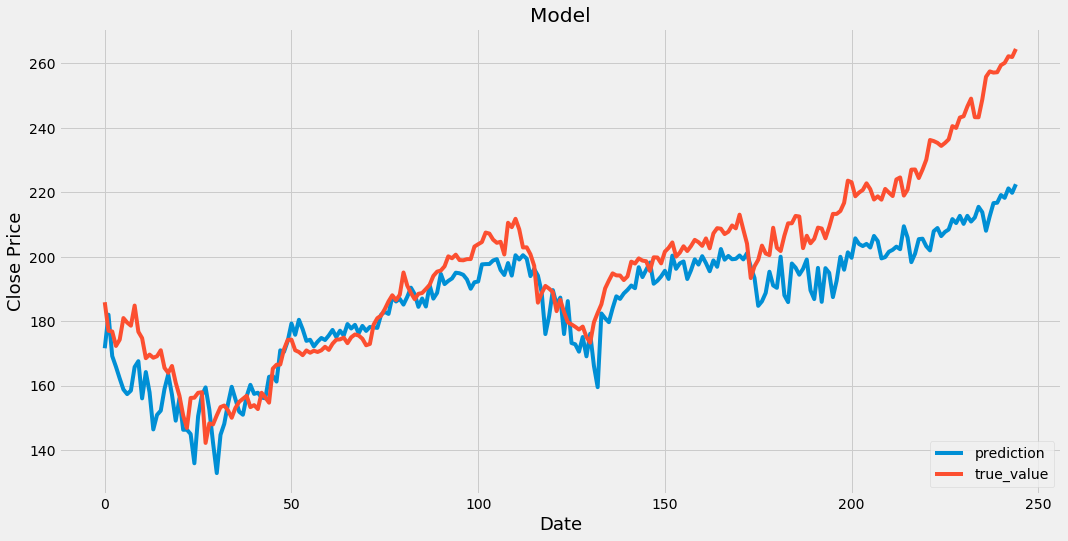

In [153]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(predictFrame)
plt.legend(['prediction', 'true_value'], loc='lower right')
plt.show()

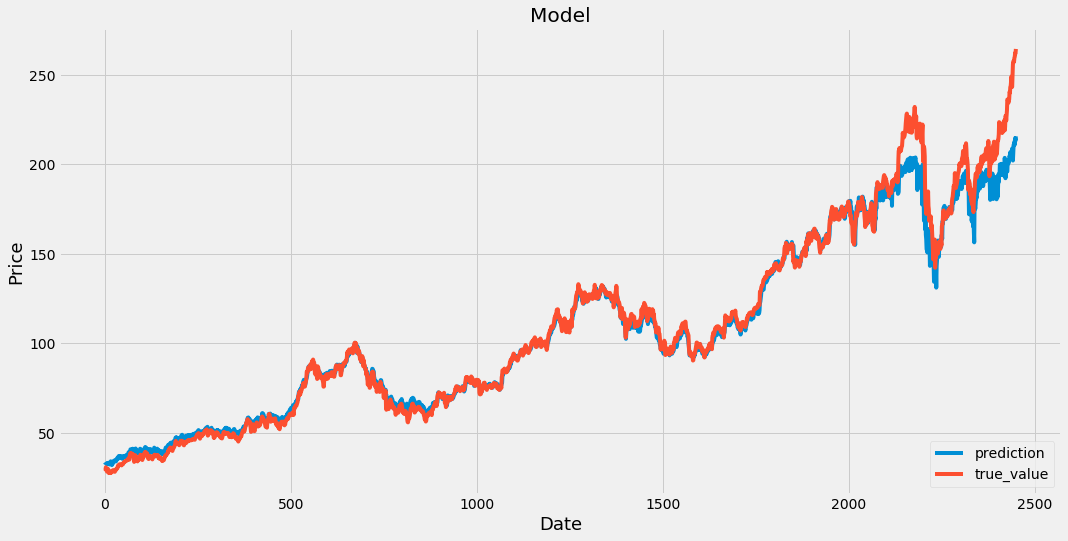

In [154]:
a = predicted_train.reshape(X_train.shape[0]).tolist()
b = predicted_valid.reshape(X_valid.shape[0]).tolist()
c = predicted_test.reshape(X_test.shape[0]).tolist()
d = y_train.reshape(X_train.shape[0]).tolist()
e = y_valid.reshape(X_valid.shape[0]).tolist()
f = y_test.reshape(X_test.shape[0]).tolist()
a.extend(b)
a.extend(c)
d.extend(e)
d.extend(f)
predictFrame = pd.DataFrame({'prediction': a, 'true_value': d})
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(predictFrame)
plt.legend(['prediction', 'true_value'], loc='lower right')
plt.show()

# Sequence 7

In [156]:
batch_size = 7
model, X_train, y_train, X_valid, y_valid, X_test, y_test  = model_train(buildTrendModel_2stacks_true_value, 7, 
                                                    stock_with_abs_norm, label_value_1d, 64, batch_size, "loss")

predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
print()
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=7)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test, batch_size=7)
print('predictions shape:', predictions.shape)

rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)
predictFrame = pd.DataFrame({'prediction': predictions.reshape(X_test.shape[0]), 'true_value': y_test.reshape(X_test.shape[0])})
predictFrame

Train on 1981 samples, validate on 217 samples
Epoch 1/1000
1981/1981 [==============================] - 3s 2ms/step - loss: 663.2203 - mae: 22.2123 - val_loss: 2850.8781 - val_mae: 49.3780
Epoch 2/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 1475.5207 - mae: 28.4040 - val_loss: 4097.5241 - val_mae: 60.7029
Epoch 3/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 1411.2855 - mae: 28.2517 - val_loss: 4630.1013 - val_mae: 64.9416
Epoch 4/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 1379.0412 - mae: 28.3599 - val_loss: 4764.7541 - val_mae: 65.9702
Epoch 5/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 1400.8009 - mae: 28.6247 - val_loss: 4812.9401 - val_mae: 66.3344
Epoch 6/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 1391.5443 - mae: 28.6669 - val_loss: 4885.1469 - val_mae: 66.8764
Epoch 7/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 1402.1494 - 

Epoch 58/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 116.5768 - mae: 8.0689 - val_loss: 537.4819 - val_mae: 18.0628
Epoch 59/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 115.8295 - mae: 8.0119 - val_loss: 465.6203 - val_mae: 16.3227
Epoch 60/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 106.2283 - mae: 7.5754 - val_loss: 517.8536 - val_mae: 18.0438
Epoch 61/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 104.6462 - mae: 7.4519 - val_loss: 349.5784 - val_mae: 14.0000
Epoch 62/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 100.8286 - mae: 7.4681 - val_loss: 435.0175 - val_mae: 15.7608
Epoch 63/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 101.4110 - mae: 7.5554 - val_loss: 385.0962 - val_mae: 14.7579
Epoch 64/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 98.3292 - mae: 7.5070 - val_loss: 401.8431 - val_mae: 15.1663
Epoch 6

Epoch 116/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 43.5786 - mae: 4.9850 - val_loss: 276.7429 - val_mae: 12.2578
Epoch 117/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 45.6370 - mae: 5.1023 - val_loss: 247.8916 - val_mae: 11.5401
Epoch 118/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 41.6824 - mae: 4.8490 - val_loss: 386.8147 - val_mae: 14.9932
Epoch 119/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 42.8442 - mae: 4.8960 - val_loss: 262.3700 - val_mae: 11.8716
Epoch 120/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 45.5441 - mae: 5.0368 - val_loss: 412.0987 - val_mae: 15.2882
Epoch 121/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 46.1828 - mae: 5.0032 - val_loss: 410.5527 - val_mae: 15.0239
Epoch 122/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 47.7101 - mae: 5.0860 - val_loss: 496.7518 - val_mae: 17.7634
Epoch 

Epoch 174/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 41.6547 - mae: 4.7156 - val_loss: 216.4921 - val_mae: 10.9605
Epoch 175/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 38.6439 - mae: 4.4905 - val_loss: 284.2475 - val_mae: 12.8064
Epoch 176/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 38.7099 - mae: 4.5414 - val_loss: 485.0941 - val_mae: 17.9609
Epoch 177/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 40.3058 - mae: 4.6726 - val_loss: 422.4604 - val_mae: 15.9226
Epoch 178/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 41.6386 - mae: 4.6037 - val_loss: 393.5735 - val_mae: 15.4002
Epoch 179/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 36.4355 - mae: 4.3714 - val_loss: 233.4951 - val_mae: 11.3509
Epoch 180/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 36.1346 - mae: 4.3593 - val_loss: 256.9872 - val_mae: 11.9162
Epoch 

1981/1981 [==============================] - 2s 1ms/step - loss: 37.3262 - mae: 4.3245 - val_loss: 290.2183 - val_mae: 12.8530
Epoch 289/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 35.5855 - mae: 4.3780 - val_loss: 494.7708 - val_mae: 17.3920
Epoch 290/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 34.4575 - mae: 4.3796 - val_loss: 322.8421 - val_mae: 13.4547
Epoch 291/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 32.6770 - mae: 4.1552 - val_loss: 461.6010 - val_mae: 17.1871
Epoch 292/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 37.2328 - mae: 4.3713 - val_loss: 354.7174 - val_mae: 14.0846
Epoch 293/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 35.9582 - mae: 4.3057 - val_loss: 390.9382 - val_mae: 15.2480
Epoch 294/1000
1981/1981 [==============================] - 2s 980us/step - loss: 38.0396 - mae: 4.4293 - val_loss: 283.4578 - val_mae: 12.7231
Epoch 295/1000
1981

Epoch 403/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 36.3617 - mae: 4.3058 - val_loss: 212.7248 - val_mae: 10.5594
Epoch 404/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 35.5373 - mae: 4.3034 - val_loss: 248.6838 - val_mae: 11.3344
Epoch 405/1000
1981/1981 [==============================] - 2s 987us/step - loss: 36.6467 - mae: 4.2736 - val_loss: 204.2700 - val_mae: 10.2954
Epoch 406/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 35.5513 - mae: 4.2228 - val_loss: 172.8259 - val_mae: 9.5822
Epoch 407/1000
1981/1981 [==============================] - 2s 993us/step - loss: 37.3467 - mae: 4.2445 - val_loss: 224.1168 - val_mae: 10.8392
Epoch 408/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 32.4352 - mae: 4.1244 - val_loss: 172.3049 - val_mae: 9.4493
Epoch 409/1000
1981/1981 [==============================] - 2s 985us/step - loss: 35.4966 - mae: 4.3058 - val_loss: 241.8210 - val_mae: 11.4467
Ep

Epoch 518/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 35.8980 - mae: 4.3186 - val_loss: 337.9158 - val_mae: 13.4454
Epoch 519/1000
1981/1981 [==============================] - 2s 988us/step - loss: 34.9688 - mae: 4.2160 - val_loss: 382.5559 - val_mae: 14.7854
Epoch 520/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 33.9186 - mae: 4.1492 - val_loss: 558.7147 - val_mae: 19.3015
Epoch 521/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 33.5449 - mae: 4.1185 - val_loss: 167.6564 - val_mae: 9.6957
Epoch 522/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 37.5443 - mae: 4.3796 - val_loss: 265.6246 - val_mae: 12.9141
Epoch 523/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 34.3993 - mae: 4.2125 - val_loss: 126.6142 - val_mae: 8.3168
Epoch 524/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 34.6953 - mae: 4.2607 - val_loss: 137.7938 - val_mae: 8.5919
Epoch 5

Epoch 576/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 34.5247 - mae: 4.2735 - val_loss: 163.5121 - val_mae: 9.4371
Epoch 577/1000
1981/1981 [==============================] - 2s 994us/step - loss: 35.2806 - mae: 4.2938 - val_loss: 223.5424 - val_mae: 10.8511
Epoch 578/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 30.9471 - mae: 3.9625 - val_loss: 184.1665 - val_mae: 9.8185
Epoch 579/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 31.8732 - mae: 4.0515 - val_loss: 195.6420 - val_mae: 10.0815
Epoch 580/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 35.2634 - mae: 4.2040 - val_loss: 217.3971 - val_mae: 10.6510
Epoch 581/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 33.9890 - mae: 4.1627 - val_loss: 217.5071 - val_mae: 10.7527
Epoch 582/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 39.6040 - mae: 4.5562 - val_loss: 293.7643 - val_mae: 12.8064
Epoch 

Epoch 634/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 30.7875 - mae: 3.9345 - val_loss: 122.9543 - val_mae: 8.2711
Epoch 635/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 37.9201 - mae: 4.4007 - val_loss: 109.3797 - val_mae: 7.5824
Epoch 636/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 30.9394 - mae: 4.0103 - val_loss: 97.4276 - val_mae: 7.6336
Epoch 637/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 34.2329 - mae: 4.1605 - val_loss: 161.3770 - val_mae: 9.1968
Epoch 638/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 32.5233 - mae: 4.1350 - val_loss: 112.8177 - val_mae: 7.6126
Epoch 639/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 35.3109 - mae: 4.3101 - val_loss: 144.5538 - val_mae: 8.6668
Epoch 640/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 33.9431 - mae: 4.2486 - val_loss: 167.8291 - val_mae: 9.7680
Epoch 641/1000

1981/1981 [==============================] - 2s 1ms/step - loss: 33.4349 - mae: 4.1234 - val_loss: 208.7803 - val_mae: 10.5184
Epoch 693/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 30.7651 - mae: 3.9509 - val_loss: 137.8606 - val_mae: 8.3307
Epoch 694/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 35.9670 - mae: 4.2163 - val_loss: 158.3119 - val_mae: 9.0703
Epoch 695/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 32.0587 - mae: 4.0519 - val_loss: 179.8629 - val_mae: 9.6603
Epoch 696/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 38.7176 - mae: 4.5618 - val_loss: 214.6739 - val_mae: 10.8218
Epoch 697/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 30.1649 - mae: 4.0464 - val_loss: 286.8417 - val_mae: 12.9223
Epoch 698/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 34.4310 - mae: 4.2380 - val_loss: 159.4181 - val_mae: 9.1209
Epoch 699/1000
1981/1981 

1981/1981 [==============================] - 2s 983us/step - loss: 37.7450 - mae: 4.4960 - val_loss: 151.4381 - val_mae: 8.9960
Epoch 751/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 34.8020 - mae: 4.3230 - val_loss: 223.3942 - val_mae: 11.5817
Epoch 752/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 34.7543 - mae: 4.2804 - val_loss: 208.6873 - val_mae: 11.4997
Epoch 753/1000
1981/1981 [==============================] - 2s 998us/step - loss: 32.8942 - mae: 4.1778 - val_loss: 180.0347 - val_mae: 10.0678
Epoch 754/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 33.5575 - mae: 4.1168 - val_loss: 180.6347 - val_mae: 10.0711
Epoch 755/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 39.5107 - mae: 4.5468 - val_loss: 163.8928 - val_mae: 10.0613
Epoch 756/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 35.3827 - mae: 4.2709 - val_loss: 153.6592 - val_mae: 9.3197
Epoch 757/1000
1981

1981/1981 [==============================] - 2s 1ms/step - loss: 34.3390 - mae: 4.1226 - val_loss: 112.4111 - val_mae: 7.6919
Epoch 867/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 31.3996 - mae: 4.0055 - val_loss: 92.4343 - val_mae: 6.6401
Epoch 868/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 33.3874 - mae: 4.1204 - val_loss: 174.8901 - val_mae: 10.0814
Epoch 869/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 33.6800 - mae: 4.1175 - val_loss: 105.6737 - val_mae: 7.1599
Epoch 870/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 32.2197 - mae: 3.9686 - val_loss: 117.3653 - val_mae: 7.4572
Epoch 871/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 32.6255 - mae: 4.1280 - val_loss: 120.5674 - val_mae: 7.5243
Epoch 872/1000
1981/1981 [==============================] - 2s 1ms/step - loss: 32.3120 - mae: 4.0909 - val_loss: 130.1264 - val_mae: 7.9422
Epoch 873/1000
1981/1981 [==

,prediction,true_value
0,204.541183,185.860001
1,211.480499,176.979996
2,189.951614,176.779999
3,185.403137,172.289993
4,193.979935,174.240005
...,...,...
240,225.095215,259.429993
241,250.173492,260.140015
242,256.476410,262.200012
243,231.364120,261.959991


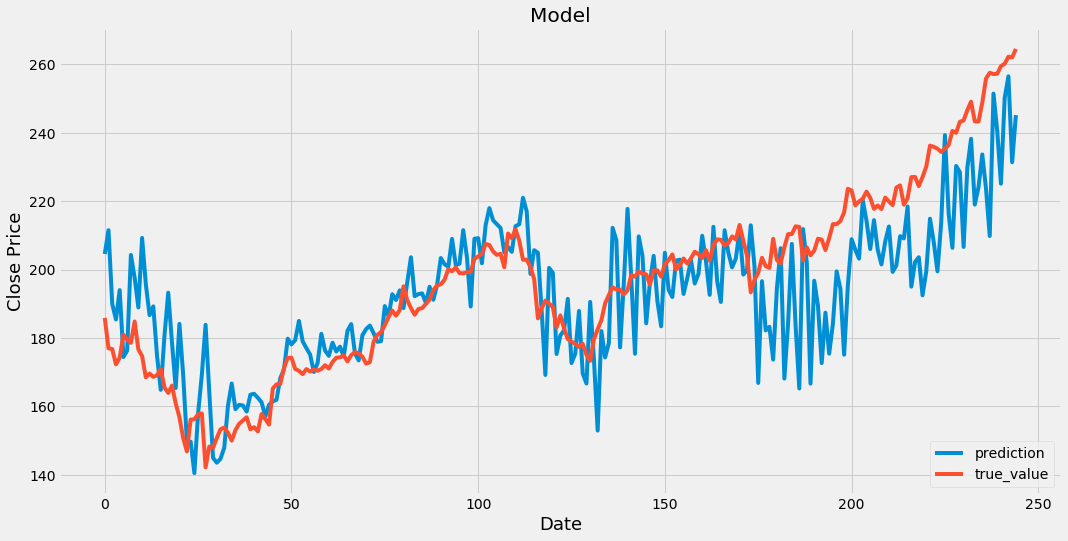

In [157]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(predictFrame)
plt.legend(['prediction', 'true_value'], loc='lower right')
plt.show()

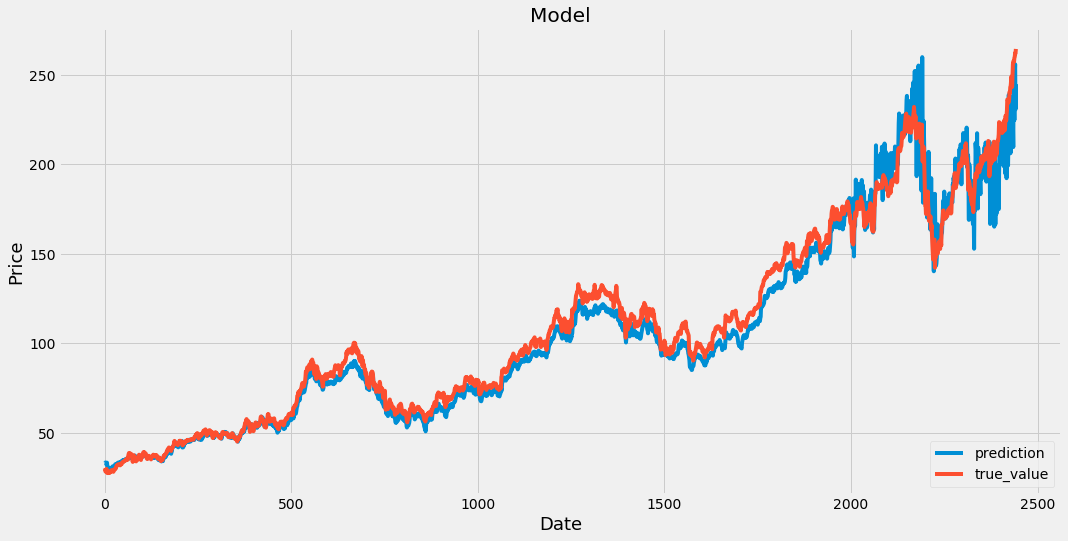

In [158]:
a = predicted_train.reshape(X_train.shape[0]).tolist()
b = predicted_valid.reshape(X_valid.shape[0]).tolist()
c = predicted_test.reshape(X_test.shape[0]).tolist()
d = y_train.reshape(X_train.shape[0]).tolist()
e = y_valid.reshape(X_valid.shape[0]).tolist()
f = y_test.reshape(X_test.shape[0]).tolist()
a.extend(b)
a.extend(c)
d.extend(e)
d.extend(f)
predictFrame = pd.DataFrame({'prediction': a, 'true_value': d})
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(predictFrame)
plt.legend(['prediction', 'true_value'], loc='lower right')
plt.show()

# Sequence1

In [159]:
batch_size = 7
model, X_train, y_train, X_valid, y_valid, X_test, y_test  = model_train(buildTrendModel_2stacks_true_value, 1, 
                                                    stock_with_abs_norm, label_value_1d, 64, batch_size, "loss")

predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
print()
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=7)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test, batch_size=7)
print('predictions shape:', predictions.shape)

rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)
predictFrame = pd.DataFrame({'prediction': predictions.reshape(X_test.shape[0]), 'true_value': y_test.reshape(X_test.shape[0])})
predictFrame

Train on 1988 samples, validate on 217 samples
Epoch 1/1000
1988/1988 [==============================] - 2s 1ms/step - loss: 648.6874 - mae: 22.0370 - val_loss: 2830.4064 - val_mae: 49.1528
Epoch 2/1000
1988/1988 [==============================] - 1s 460us/step - loss: 1455.2868 - mae: 28.2063 - val_loss: 4331.6485 - val_mae: 62.5879
Epoch 3/1000
1988/1988 [==============================] - 1s 434us/step - loss: 1373.5670 - mae: 28.3823 - val_loss: 4561.5846 - val_mae: 64.3986
Epoch 4/1000
1988/1988 [==============================] - 1s 447us/step - loss: 1351.4389 - mae: 27.9814 - val_loss: 4717.6737 - val_mae: 65.5993
Epoch 5/1000
1988/1988 [==============================] - 1s 449us/step - loss: 1361.0586 - mae: 28.2912 - val_loss: 4719.5657 - val_mae: 65.6137
Epoch 6/1000
1988/1988 [==============================] - 1s 454us/step - loss: 1397.0091 - mae: 28.5858 - val_loss: 4923.1604 - val_mae: 67.1472
Epoch 7/1000
1988/1988 [==============================] - 1s 479us/step - loss: 

1988/1988 [==============================] - 1s 470us/step - loss: 141.6541 - mae: 8.7845 - val_loss: 847.4994 - val_mae: 23.5252
Epoch 58/1000
1988/1988 [==============================] - 1s 453us/step - loss: 132.5476 - mae: 8.6533 - val_loss: 890.2791 - val_mae: 24.7583
Epoch 59/1000
1988/1988 [==============================] - 1s 465us/step - loss: 138.7303 - mae: 8.8871 - val_loss: 1262.5097 - val_mae: 31.7390
Epoch 60/1000
1988/1988 [==============================] - 1s 468us/step - loss: 136.3729 - mae: 8.7283 - val_loss: 732.6111 - val_mae: 21.7962
Epoch 61/1000
1988/1988 [==============================] - 1s 461us/step - loss: 137.4399 - mae: 8.7194 - val_loss: 747.0145 - val_mae: 21.8391
Epoch 62/1000
1988/1988 [==============================] - 1s 451us/step - loss: 124.2813 - mae: 8.2855 - val_loss: 720.4638 - val_mae: 20.7551
Epoch 63/1000
1988/1988 [==============================] - 1s 458us/step - loss: 138.2635 - mae: 8.7561 - val_loss: 824.5376 - val_mae: 22.5819
Epoch

Epoch 171/1000
1988/1988 [==============================] - 1s 488us/step - loss: 67.6920 - mae: 5.8800 - val_loss: 660.8508 - val_mae: 19.2952
Epoch 172/1000
1988/1988 [==============================] - 1s 511us/step - loss: 59.9643 - mae: 5.5231 - val_loss: 562.0155 - val_mae: 17.8541
Epoch 173/1000
1988/1988 [==============================] - 1s 477us/step - loss: 70.1369 - mae: 5.9575 - val_loss: 1115.3901 - val_mae: 27.8900
Epoch 174/1000
1988/1988 [==============================] - 1s 476us/step - loss: 62.3477 - mae: 5.4861 - val_loss: 707.8180 - val_mae: 20.1642
Epoch 175/1000
1988/1988 [==============================] - 1s 470us/step - loss: 65.7882 - mae: 5.9574 - val_loss: 898.2169 - val_mae: 24.8479
Epoch 176/1000
1988/1988 [==============================] - 1s 475us/step - loss: 62.7835 - mae: 5.6042 - val_loss: 589.9952 - val_mae: 18.1219
Epoch 177/1000
1988/1988 [==============================] - 1s 449us/step - loss: 60.3059 - mae: 5.6517 - val_loss: 866.9529 - val_mae:

Epoch 228/1000
1988/1988 [==============================] - 1s 449us/step - loss: 61.6077 - mae: 5.5119 - val_loss: 729.3030 - val_mae: 20.5446
Epoch 229/1000
1988/1988 [==============================] - 1s 452us/step - loss: 64.9567 - mae: 5.6790 - val_loss: 744.2554 - val_mae: 20.8046
Epoch 230/1000
1988/1988 [==============================] - 1s 461us/step - loss: 60.6135 - mae: 5.5253 - val_loss: 665.9471 - val_mae: 19.4163
Epoch 231/1000
1988/1988 [==============================] - 1s 465us/step - loss: 69.7083 - mae: 6.1121 - val_loss: 978.6871 - val_mae: 25.1763
Epoch 232/1000
1988/1988 [==============================] - 1s 453us/step - loss: 68.0917 - mae: 5.7745 - val_loss: 615.7997 - val_mae: 18.5423
Epoch 233/1000
1988/1988 [==============================] - 1s 456us/step - loss: 65.0224 - mae: 5.7489 - val_loss: 679.0058 - val_mae: 20.0774
Epoch 234/1000
1988/1988 [==============================] - 1s 504us/step - loss: 75.2694 - mae: 6.4577 - val_loss: 446.3560 - val_mae: 

Epoch 285/1000
1988/1988 [==============================] - 1s 434us/step - loss: 61.2910 - mae: 5.6055 - val_loss: 650.5419 - val_mae: 19.0922
Epoch 286/1000
1988/1988 [==============================] - 1s 426us/step - loss: 64.0144 - mae: 5.6761 - val_loss: 693.3329 - val_mae: 19.8735
Epoch 287/1000
1988/1988 [==============================] - 1s 436us/step - loss: 61.5846 - mae: 5.6288 - val_loss: 898.0794 - val_mae: 23.7181
Epoch 288/1000
1988/1988 [==============================] - 1s 443us/step - loss: 64.1782 - mae: 5.6243 - val_loss: 749.3154 - val_mae: 21.3416
Epoch 289/1000
1988/1988 [==============================] - 1s 440us/step - loss: 61.5765 - mae: 5.5027 - val_loss: 602.9959 - val_mae: 18.2462
Epoch 290/1000
1988/1988 [==============================] - 1s 447us/step - loss: 71.6582 - mae: 5.9500 - val_loss: 1050.2386 - val_mae: 26.8739
Epoch 291/1000
1988/1988 [==============================] - 1s 446us/step - loss: 71.5787 - mae: 6.0411 - val_loss: 548.1394 - val_mae:

Epoch 342/1000
1988/1988 [==============================] - 1s 453us/step - loss: 62.6362 - mae: 5.6268 - val_loss: 1090.3842 - val_mae: 27.7502
Epoch 343/1000
1988/1988 [==============================] - 1s 452us/step - loss: 59.7319 - mae: 5.3844 - val_loss: 753.9211 - val_mae: 21.2097
Epoch 344/1000
1988/1988 [==============================] - 1s 456us/step - loss: 61.5100 - mae: 5.5444 - val_loss: 777.4979 - val_mae: 21.7880
Epoch 345/1000
1988/1988 [==============================] - 1s 448us/step - loss: 61.3704 - mae: 5.4483 - val_loss: 717.1228 - val_mae: 20.8257
Epoch 346/1000
1988/1988 [==============================] - 1s 463us/step - loss: 60.5346 - mae: 5.5120 - val_loss: 588.2844 - val_mae: 18.0184
Epoch 347/1000
1988/1988 [==============================] - 1s 491us/step - loss: 61.4893 - mae: 5.5232 - val_loss: 575.1635 - val_mae: 18.0103
Epoch 348/1000
1988/1988 [==============================] - 1s 432us/step - loss: 60.5280 - mae: 5.5013 - val_loss: 946.7011 - val_mae:

Epoch 399/1000
1988/1988 [==============================] - 1s 489us/step - loss: 64.0954 - mae: 5.8008 - val_loss: 630.0799 - val_mae: 18.8054
Epoch 400/1000
1988/1988 [==============================] - 1s 470us/step - loss: 64.1126 - mae: 5.7104 - val_loss: 744.8130 - val_mae: 21.0206
Epoch 401/1000
1988/1988 [==============================] - 1s 475us/step - loss: 62.8550 - mae: 5.6037 - val_loss: 620.3933 - val_mae: 18.6363
Epoch 402/1000
1988/1988 [==============================] - 1s 470us/step - loss: 64.3080 - mae: 5.7509 - val_loss: 670.2825 - val_mae: 19.5020
Epoch 403/1000
1988/1988 [==============================] - 1s 457us/step - loss: 59.5235 - mae: 5.4061 - val_loss: 766.0043 - val_mae: 21.0954
Epoch 404/1000
1988/1988 [==============================] - 1s 464us/step - loss: 60.0080 - mae: 5.5402 - val_loss: 704.7805 - val_mae: 20.0641
Epoch 405/1000
1988/1988 [==============================] - 1s 472us/step - loss: 72.5560 - mae: 5.9834 - val_loss: 965.7239 - val_mae: 

Epoch 456/1000
1988/1988 [==============================] - 1s 429us/step - loss: 56.1004 - mae: 5.3401 - val_loss: 684.5932 - val_mae: 19.8816
Epoch 457/1000
1988/1988 [==============================] - 1s 603us/step - loss: 60.3999 - mae: 5.4264 - val_loss: 685.3251 - val_mae: 19.7515
Epoch 458/1000
1988/1988 [==============================] - 1s 486us/step - loss: 59.1422 - mae: 5.4570 - val_loss: 1007.7784 - val_mae: 25.4439
Epoch 459/1000
1988/1988 [==============================] - 1s 455us/step - loss: 60.2695 - mae: 5.4344 - val_loss: 1031.4836 - val_mae: 26.4644
Epoch 460/1000
1988/1988 [==============================] - 1s 433us/step - loss: 57.2144 - mae: 5.3388 - val_loss: 691.6606 - val_mae: 19.9221
Epoch 461/1000
1988/1988 [==============================] - 1s 447us/step - loss: 65.2160 - mae: 5.6434 - val_loss: 798.0946 - val_mae: 22.0979
Epoch 462/1000
1988/1988 [==============================] - 1s 461us/step - loss: 56.9522 - mae: 5.2232 - val_loss: 770.5744 - val_mae

,prediction,true_value
0,171.868866,185.860001
1,171.507797,176.979996
2,171.483765,176.779999
3,170.888107,172.289993
4,168.450516,174.240005
...,...,...
240,174.027771,259.429993
241,173.920959,260.140015
242,174.384613,262.200012
243,174.312668,261.959991


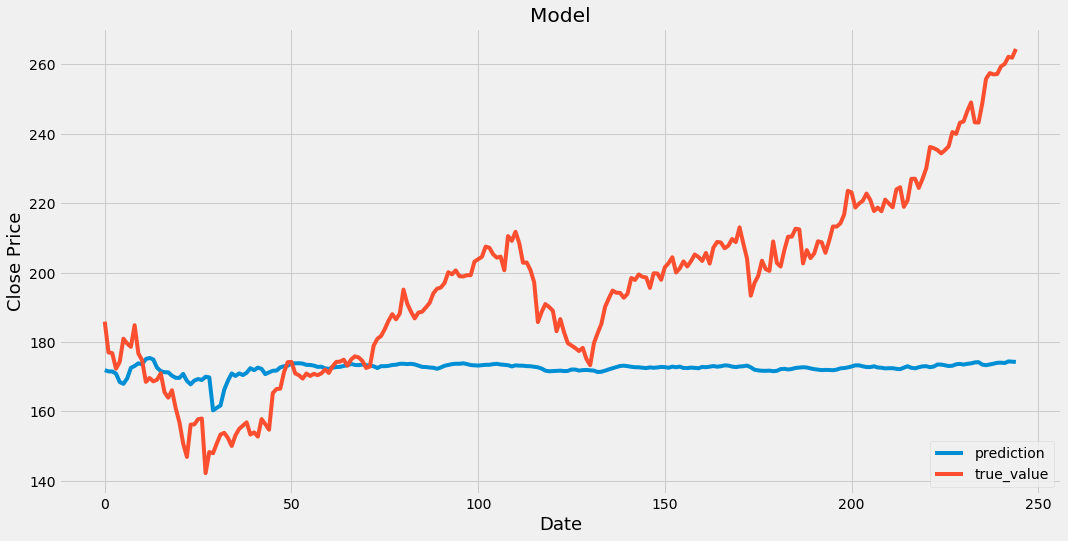

In [160]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(predictFrame)
plt.legend(['prediction', 'true_value'], loc='lower right')
plt.show()

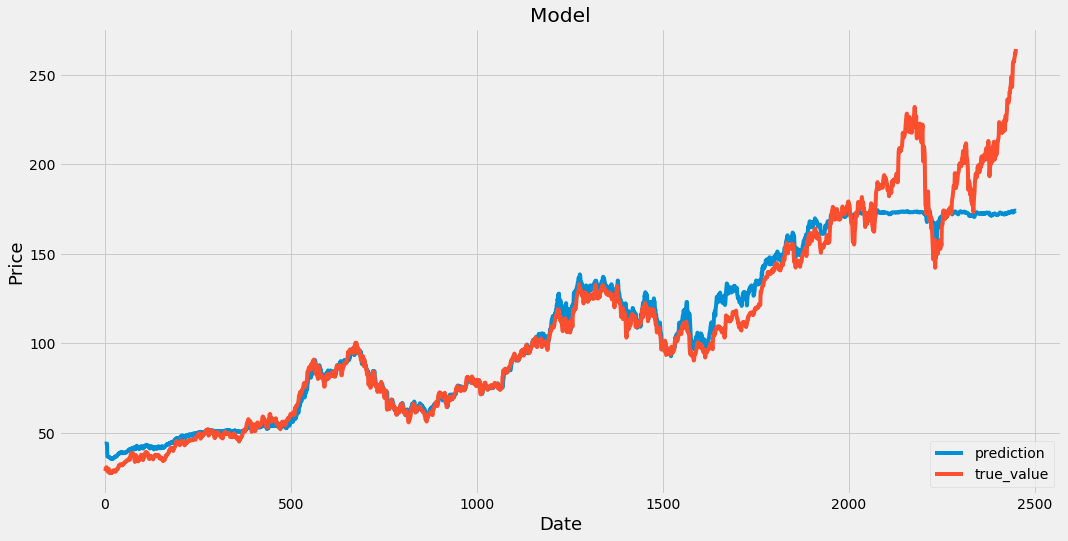

In [161]:
a = predicted_train.reshape(X_train.shape[0]).tolist()
b = predicted_valid.reshape(X_valid.shape[0]).tolist()
c = predicted_test.reshape(X_test.shape[0]).tolist()
d = y_train.reshape(X_train.shape[0]).tolist()
e = y_valid.reshape(X_valid.shape[0]).tolist()
f = y_test.reshape(X_test.shape[0]).tolist()
a.extend(b)
a.extend(c)
d.extend(e)
d.extend(f)
predictFrame = pd.DataFrame({'prediction': a, 'true_value': d})
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(predictFrame)
plt.legend(['prediction', 'true_value'], loc='lower right')
plt.show()

# Sequence 5

In [162]:
batch_size = 7
model, X_train, y_train, X_valid, y_valid, X_test, y_test  = model_train(buildTrendModel_2stacks_true_value, 5, 
                                                    stock_with_abs_norm, label_value_1d, 64, batch_size, "loss")

predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
print()
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=7)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test, batch_size=7)
print('predictions shape:', predictions.shape)

rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)
predictFrame = pd.DataFrame({'prediction': predictions.reshape(X_test.shape[0]), 'true_value': y_test.reshape(X_test.shape[0])})
predictFrame

Train on 1988 samples, validate on 217 samples
Epoch 1/1000
1988/1988 [==============================] - 3s 1ms/step - loss: 575.2840 - mae: 20.8943 - val_loss: 2725.3807 - val_mae: 48.0904
Epoch 2/1000
1988/1988 [==============================] - 2s 808us/step - loss: 1527.2857 - mae: 28.7414 - val_loss: 4243.5641 - val_mae: 61.8941
Epoch 3/1000
1988/1988 [==============================] - 2s 844us/step - loss: 1412.2627 - mae: 28.6492 - val_loss: 4438.4577 - val_mae: 63.4489
Epoch 4/1000
1988/1988 [==============================] - 2s 857us/step - loss: 1405.7181 - mae: 28.6899 - val_loss: 4626.6545 - val_mae: 64.9150
Epoch 5/1000
1988/1988 [==============================] - 2s 905us/step - loss: 1426.5238 - mae: 28.8789 - val_loss: 4616.9133 - val_mae: 64.8400
Epoch 6/1000
1988/1988 [==============================] - 2s 942us/step - loss: 1448.8211 - mae: 29.1882 - val_loss: 4826.8235 - val_mae: 66.4390
Epoch 7/1000
1988/1988 [==============================] - 2s 908us/step - loss: 

1988/1988 [==============================] - 2s 814us/step - loss: 50.8470 - mae: 5.1985 - val_loss: 414.9620 - val_mae: 16.6511
Epoch 115/1000
1988/1988 [==============================] - 2s 805us/step - loss: 53.0840 - mae: 5.2893 - val_loss: 298.9240 - val_mae: 13.0717
Epoch 116/1000
1988/1988 [==============================] - 2s 803us/step - loss: 46.6570 - mae: 5.0935 - val_loss: 327.2272 - val_mae: 13.7698
Epoch 117/1000
1988/1988 [==============================] - 2s 844us/step - loss: 47.3292 - mae: 5.0424 - val_loss: 278.1288 - val_mae: 12.5165
Epoch 118/1000
1988/1988 [==============================] - 2s 821us/step - loss: 49.1002 - mae: 5.0680 - val_loss: 420.0397 - val_mae: 15.8392
Epoch 119/1000
1988/1988 [==============================] - 2s 828us/step - loss: 51.4463 - mae: 5.2687 - val_loss: 468.9924 - val_mae: 16.9186
Epoch 120/1000
1988/1988 [==============================] - 2s 827us/step - loss: 50.0910 - mae: 5.2064 - val_loss: 368.0618 - val_mae: 14.4380
Epoch 1

1988/1988 [==============================] - 2s 774us/step - loss: 43.2120 - mae: 4.7755 - val_loss: 267.9324 - val_mae: 13.0125
Epoch 172/1000
1988/1988 [==============================] - 2s 776us/step - loss: 46.5919 - mae: 4.9378 - val_loss: 351.2515 - val_mae: 15.9660
Epoch 173/1000
1988/1988 [==============================] - 2s 801us/step - loss: 45.6448 - mae: 4.8161 - val_loss: 104.1548 - val_mae: 8.0744
Epoch 174/1000
1988/1988 [==============================] - 2s 793us/step - loss: 45.2986 - mae: 4.8641 - val_loss: 150.6906 - val_mae: 9.4072
Epoch 175/1000
1988/1988 [==============================] - 2s 813us/step - loss: 46.5171 - mae: 4.8418 - val_loss: 300.5973 - val_mae: 14.6119
Epoch 176/1000
1988/1988 [==============================] - 2s 817us/step - loss: 46.8622 - mae: 4.9061 - val_loss: 185.4872 - val_mae: 10.4161
Epoch 177/1000
1988/1988 [==============================] - 2s 822us/step - loss: 48.1115 - mae: 4.9010 - val_loss: 319.2247 - val_mae: 14.2123
Epoch 178

1988/1988 [==============================] - 2s 824us/step - loss: 43.6503 - mae: 4.6421 - val_loss: 361.3229 - val_mae: 14.4325
Epoch 229/1000
1988/1988 [==============================] - 2s 837us/step - loss: 47.3164 - mae: 4.9496 - val_loss: 370.4716 - val_mae: 15.4245
Epoch 230/1000
1988/1988 [==============================] - 2s 821us/step - loss: 44.6315 - mae: 4.9429 - val_loss: 342.5498 - val_mae: 14.0717
Epoch 231/1000
1988/1988 [==============================] - 2s 796us/step - loss: 44.7167 - mae: 4.7547 - val_loss: 398.4043 - val_mae: 16.1382
Epoch 232/1000
1988/1988 [==============================] - 2s 802us/step - loss: 40.0103 - mae: 4.4974 - val_loss: 363.2795 - val_mae: 14.6893
Epoch 233/1000
1988/1988 [==============================] - 2s 809us/step - loss: 46.2409 - mae: 4.7577 - val_loss: 353.7340 - val_mae: 14.4088
Epoch 234/1000
1988/1988 [==============================] - 2s 799us/step - loss: 43.0084 - mae: 4.7195 - val_loss: 376.7133 - val_mae: 15.7552
Epoch 2

1988/1988 [==============================] - 2s 837us/step - loss: 37.3925 - mae: 4.4470 - val_loss: 249.2074 - val_mae: 12.1196
Epoch 286/1000
1988/1988 [==============================] - 2s 829us/step - loss: 43.0611 - mae: 4.7437 - val_loss: 359.2518 - val_mae: 15.3632
Epoch 287/1000
1988/1988 [==============================] - 2s 848us/step - loss: 37.2316 - mae: 4.3752 - val_loss: 174.6030 - val_mae: 10.0653
Epoch 288/1000
1988/1988 [==============================] - 2s 842us/step - loss: 39.8810 - mae: 4.5015 - val_loss: 291.7684 - val_mae: 14.0216
Epoch 289/1000
1988/1988 [==============================] - 2s 838us/step - loss: 41.1528 - mae: 4.6260 - val_loss: 380.9433 - val_mae: 15.9251
Epoch 290/1000
1988/1988 [==============================] - 2s 850us/step - loss: 40.9598 - mae: 4.5178 - val_loss: 310.2836 - val_mae: 13.5361
Epoch 291/1000
1988/1988 [==============================] - 2s 840us/step - loss: 40.0565 - mae: 4.6025 - val_loss: 366.4955 - val_mae: 14.2785
Epoch 2

1988/1988 [==============================] - 2s 909us/step - loss: 38.6966 - mae: 4.5110 - val_loss: 191.3699 - val_mae: 11.1779
Epoch 343/1000
1988/1988 [==============================] - 2s 915us/step - loss: 38.7269 - mae: 4.4670 - val_loss: 137.9793 - val_mae: 8.9695
Epoch 344/1000
1988/1988 [==============================] - 2s 895us/step - loss: 40.1360 - mae: 4.5318 - val_loss: 164.2219 - val_mae: 10.3906
Epoch 345/1000
1988/1988 [==============================] - 2s 909us/step - loss: 39.2767 - mae: 4.4295 - val_loss: 182.1732 - val_mae: 11.1095
Epoch 346/1000
1988/1988 [==============================] - 2s 906us/step - loss: 38.2850 - mae: 4.3914 - val_loss: 102.8410 - val_mae: 7.8937
Epoch 347/1000
1988/1988 [==============================] - 2s 893us/step - loss: 36.1342 - mae: 4.3593 - val_loss: 159.4366 - val_mae: 9.9949
Epoch 348/1000
1988/1988 [==============================] - 2s 891us/step - loss: 39.6666 - mae: 4.5046 - val_loss: 216.1531 - val_mae: 12.0987
Epoch 349/

1988/1988 [==============================] - 2s 839us/step - loss: 35.3865 - mae: 4.2471 - val_loss: 152.8831 - val_mae: 9.3432
Epoch 457/1000
1988/1988 [==============================] - 2s 813us/step - loss: 38.2352 - mae: 4.4097 - val_loss: 350.8902 - val_mae: 15.0736
Epoch 458/1000
1988/1988 [==============================] - 2s 808us/step - loss: 41.3057 - mae: 4.6311 - val_loss: 410.8417 - val_mae: 15.6089
Epoch 459/1000
1988/1988 [==============================] - 2s 810us/step - loss: 39.2074 - mae: 4.6267 - val_loss: 384.3496 - val_mae: 15.6119
Epoch 460/1000
1988/1988 [==============================] - 2s 807us/step - loss: 40.0508 - mae: 4.4796 - val_loss: 209.2720 - val_mae: 10.9598
Epoch 461/1000
1988/1988 [==============================] - 2s 780us/step - loss: 36.7701 - mae: 4.4041 - val_loss: 228.7876 - val_mae: 11.4259
Epoch 462/1000
1988/1988 [==============================] - 2s 837us/step - loss: 36.0725 - mae: 4.3463 - val_loss: 302.6792 - val_mae: 13.0857
Epoch 46

Epoch 513/1000
1988/1988 [==============================] - 2s 786us/step - loss: 35.4367 - mae: 4.2835 - val_loss: 233.8021 - val_mae: 11.2593
Epoch 514/1000
1988/1988 [==============================] - 2s 802us/step - loss: 38.1045 - mae: 4.4274 - val_loss: 233.4532 - val_mae: 11.3022
Epoch 515/1000
1988/1988 [==============================] - 2s 807us/step - loss: 38.7610 - mae: 4.6305 - val_loss: 433.1732 - val_mae: 16.1689
Epoch 516/1000
1988/1988 [==============================] - 2s 803us/step - loss: 42.7541 - mae: 4.6468 - val_loss: 282.8985 - val_mae: 12.3887
Epoch 517/1000
1988/1988 [==============================] - 2s 851us/step - loss: 37.1131 - mae: 4.3576 - val_loss: 178.1433 - val_mae: 10.0375
Epoch 518/1000
1988/1988 [==============================] - 2s 875us/step - loss: 35.9199 - mae: 4.4052 - val_loss: 168.3742 - val_mae: 9.5153
Epoch 519/1000
1988/1988 [==============================] - 2s 862us/step - loss: 40.8962 - mae: 4.4956 - val_loss: 278.7670 - val_mae: 1

1988/1988 [==============================] - 2s 878us/step - loss: 42.6100 - mae: 4.8150 - val_loss: 351.0118 - val_mae: 14.6725
Epoch 571/1000
1988/1988 [==============================] - 2s 905us/step - loss: 38.8762 - mae: 4.5678 - val_loss: 163.5233 - val_mae: 9.3172
Epoch 572/1000
1988/1988 [==============================] - 2s 921us/step - loss: 40.7327 - mae: 4.5451 - val_loss: 251.4830 - val_mae: 12.7720
Epoch 573/1000
1988/1988 [==============================] - 2s 878us/step - loss: 37.4565 - mae: 4.4721 - val_loss: 235.8095 - val_mae: 11.9181
Epoch 574/1000
1988/1988 [==============================] - 2s 866us/step - loss: 38.7886 - mae: 4.3919 - val_loss: 222.1127 - val_mae: 11.6101
Epoch 575/1000
1988/1988 [==============================] - 2s 894us/step - loss: 37.5020 - mae: 4.4484 - val_loss: 191.1432 - val_mae: 10.5809
Epoch 576/1000
1988/1988 [==============================] - 2s 904us/step - loss: 38.1795 - mae: 4.3941 - val_loss: 223.9150 - val_mae: 11.2593
Epoch 57

1988/1988 [==============================] - 2s 1ms/step - loss: 36.3342 - mae: 4.3354 - val_loss: 262.7797 - val_mae: 12.7197
Epoch 628/1000
1988/1988 [==============================] - 2s 820us/step - loss: 36.2985 - mae: 4.3150 - val_loss: 223.3688 - val_mae: 11.1114
Epoch 629/1000
1988/1988 [==============================] - 2s 891us/step - loss: 39.7355 - mae: 4.6274 - val_loss: 157.8167 - val_mae: 9.2719
Epoch 630/1000
1988/1988 [==============================] - 2s 859us/step - loss: 36.2926 - mae: 4.4770 - val_loss: 203.6867 - val_mae: 11.1106
Epoch 631/1000
1988/1988 [==============================] - 2s 849us/step - loss: 36.2312 - mae: 4.3105 - val_loss: 272.6253 - val_mae: 13.0630
Epoch 632/1000
1988/1988 [==============================] - 2s 863us/step - loss: 38.2182 - mae: 4.4163 - val_loss: 256.8573 - val_mae: 12.6782
Epoch 633/1000
1988/1988 [==============================] - 2s 868us/step - loss: 38.5211 - mae: 4.4790 - val_loss: 179.0091 - val_mae: 10.0285
Epoch 634/

1988/1988 [==============================] - 2s 883us/step - loss: 41.1667 - mae: 4.5443 - val_loss: 215.1979 - val_mae: 11.3420
Epoch 685/1000
1988/1988 [==============================] - 2s 890us/step - loss: 37.1814 - mae: 4.4742 - val_loss: 329.3382 - val_mae: 14.4956
Epoch 686/1000
1988/1988 [==============================] - 2s 927us/step - loss: 35.2846 - mae: 4.2386 - val_loss: 220.7591 - val_mae: 11.3194
Epoch 687/1000
1988/1988 [==============================] - 2s 890us/step - loss: 33.9406 - mae: 4.1377 - val_loss: 309.6110 - val_mae: 14.0566
Epoch 688/1000
1988/1988 [==============================] - 2s 888us/step - loss: 35.0580 - mae: 4.1896 - val_loss: 270.6105 - val_mae: 12.6462
Epoch 689/1000
1988/1988 [==============================] - 2s 896us/step - loss: 38.3750 - mae: 4.4699 - val_loss: 282.7696 - val_mae: 12.9780
Epoch 690/1000
1988/1988 [==============================] - 2s 889us/step - loss: 38.2471 - mae: 4.3588 - val_loss: 416.5554 - val_mae: 16.3847
Epoch 6

1988/1988 [==============================] - 2s 874us/step - loss: 34.9114 - mae: 4.1879 - val_loss: 362.8076 - val_mae: 16.5366
Epoch 742/1000
1988/1988 [==============================] - 2s 882us/step - loss: 39.8402 - mae: 4.6756 - val_loss: 221.0736 - val_mae: 11.5584
Epoch 743/1000
1988/1988 [==============================] - 2s 919us/step - loss: 41.0735 - mae: 4.6172 - val_loss: 225.3732 - val_mae: 11.4404
Epoch 744/1000
1988/1988 [==============================] - 2s 851us/step - loss: 33.7096 - mae: 4.1847 - val_loss: 288.6832 - val_mae: 13.5135
Epoch 745/1000
1988/1988 [==============================] - 2s 886us/step - loss: 38.4937 - mae: 4.4736 - val_loss: 248.8173 - val_mae: 11.8964
Epoch 746/1000
1988/1988 [==============================] - 2s 901us/step - loss: 38.3875 - mae: 4.5039 - val_loss: 195.9347 - val_mae: 10.1798
Epoch 747/1000
1988/1988 [==============================] - 2s 942us/step - loss: 34.7600 - mae: 4.1948 - val_loss: 304.0322 - val_mae: 14.0625
Epoch 7

1988/1988 [==============================] - 2s 914us/step - loss: 35.8607 - mae: 4.1237 - val_loss: 239.0457 - val_mae: 11.7392
Epoch 799/1000
1988/1988 [==============================] - 2s 961us/step - loss: 35.2491 - mae: 4.2594 - val_loss: 244.6045 - val_mae: 11.9679
Epoch 800/1000
1988/1988 [==============================] - 2s 888us/step - loss: 37.9213 - mae: 4.3414 - val_loss: 216.3306 - val_mae: 11.1033
Epoch 801/1000
1988/1988 [==============================] - 2s 955us/step - loss: 35.2568 - mae: 4.2535 - val_loss: 178.4977 - val_mae: 10.3355
Epoch 802/1000
1988/1988 [==============================] - 2s 897us/step - loss: 35.8541 - mae: 4.2304 - val_loss: 101.6338 - val_mae: 7.6460
Epoch 803/1000
1988/1988 [==============================] - 2s 875us/step - loss: 37.5095 - mae: 4.5916 - val_loss: 273.2977 - val_mae: 13.1088
Epoch 804/1000
1988/1988 [==============================] - 2s 951us/step - loss: 36.0155 - mae: 4.3102 - val_loss: 291.2355 - val_mae: 13.4176
Epoch 80

1988/1988 [==============================] - 2s 857us/step - loss: 41.3404 - mae: 4.6519 - val_loss: 209.8283 - val_mae: 10.6339
Epoch 856/1000
1988/1988 [==============================] - 2s 911us/step - loss: 35.5052 - mae: 4.3358 - val_loss: 234.4752 - val_mae: 11.4479
Epoch 857/1000
1988/1988 [==============================] - 2s 920us/step - loss: 36.5899 - mae: 4.2274 - val_loss: 323.4910 - val_mae: 13.9644
Epoch 858/1000
1988/1988 [==============================] - 2s 949us/step - loss: 34.8832 - mae: 4.1726 - val_loss: 504.0987 - val_mae: 18.9955
Epoch 859/1000
1988/1988 [==============================] - 2s 916us/step - loss: 36.5756 - mae: 4.2524 - val_loss: 385.0012 - val_mae: 15.6271
Epoch 860/1000
1988/1988 [==============================] - 2s 890us/step - loss: 33.0323 - mae: 4.2228 - val_loss: 230.4436 - val_mae: 11.1751
Epoch 861/1000
1988/1988 [==============================] - 2s 908us/step - loss: 38.3682 - mae: 4.3882 - val_loss: 470.4264 - val_mae: 18.3180
Epoch 8

Epoch 970/1000
1988/1988 [==============================] - 2s 1ms/step - loss: 36.7474 - mae: 4.2431 - val_loss: 194.9082 - val_mae: 10.9031
Epoch 971/1000
1988/1988 [==============================] - 2s 1ms/step - loss: 35.0899 - mae: 4.1797 - val_loss: 199.6050 - val_mae: 10.8764
Epoch 972/1000
1988/1988 [==============================] - 2s 1ms/step - loss: 38.1972 - mae: 4.3703 - val_loss: 210.7917 - val_mae: 11.4317
Epoch 973/1000
1988/1988 [==============================] - 2s 1ms/step - loss: 36.3640 - mae: 4.2586 - val_loss: 231.5809 - val_mae: 12.0789
Epoch 974/1000
1988/1988 [==============================] - 2s 1ms/step - loss: 34.1832 - mae: 4.0934 - val_loss: 179.4843 - val_mae: 10.1877
Epoch 975/1000
1988/1988 [==============================] - 2s 1ms/step - loss: 34.0325 - mae: 4.1091 - val_loss: 134.3356 - val_mae: 8.6004
Epoch 976/1000
1988/1988 [==============================] - 2s 1ms/step - loss: 35.5241 - mae: 4.1632 - val_loss: 138.7999 - val_mae: 8.7464
Epoch 97

,prediction,true_value
0,166.021179,185.860001
1,172.285522,176.979996
2,150.645950,176.779999
3,154.483429,172.289993
4,157.120148,174.240005
...,...,...
240,223.864151,259.429993
241,222.262772,260.140015
242,233.876389,262.200012
243,212.728867,261.959991


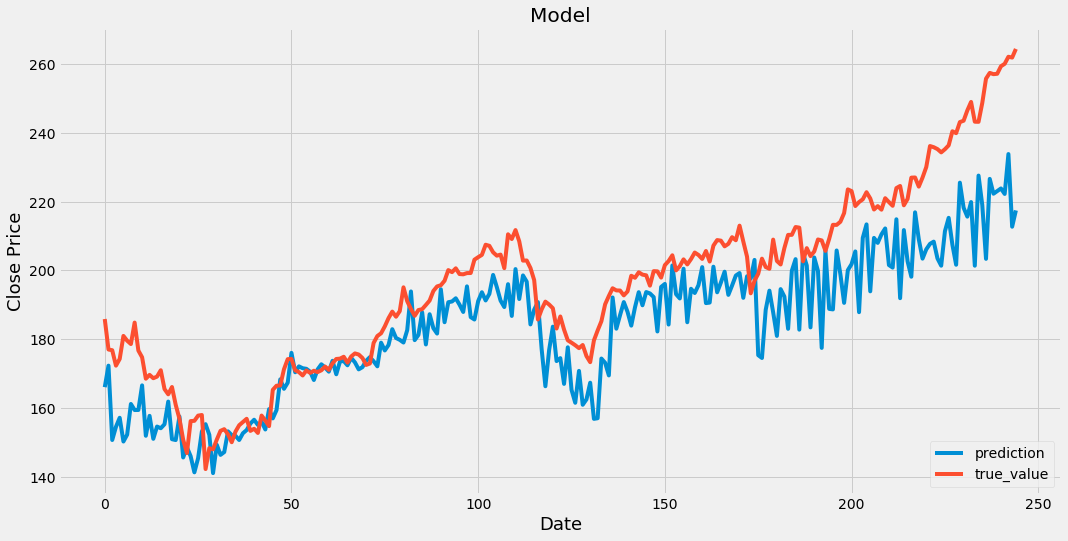

In [163]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(predictFrame)
plt.legend(['prediction', 'true_value'], loc='lower right')
plt.show()

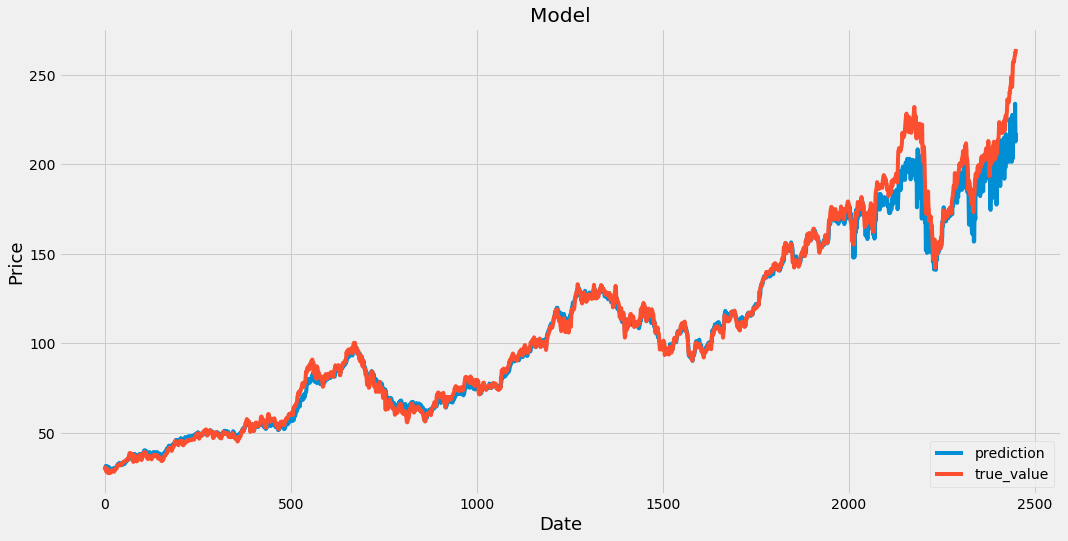

In [164]:
a = predicted_train.reshape(X_train.shape[0]).tolist()
b = predicted_valid.reshape(X_valid.shape[0]).tolist()
c = predicted_test.reshape(X_test.shape[0]).tolist()
d = y_train.reshape(X_train.shape[0]).tolist()
e = y_valid.reshape(X_valid.shape[0]).tolist()
f = y_test.reshape(X_test.shape[0]).tolist()
a.extend(b)
a.extend(c)
d.extend(e)
d.extend(f)
predictFrame = pd.DataFrame({'prediction': a, 'true_value': d})
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(predictFrame)
plt.legend(['prediction', 'true_value'], loc='lower right')
plt.show()

# Playground

In [22]:
batch_size = 7
model, X_train, y_train, X_valid, y_valid, X_test, y_test  = model_train(buildTrendModel_2stacks_true_value, 5, 
                                                    stock_with_abs_norm, label_value_1d, 64, batch_size, "val_loss", 2000)

predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
print()
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=7)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test, batch_size=7)
print('predictions shape:', predictions.shape)

rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)
predictFrame = pd.DataFrame({'prediction': predictions.reshape(X_test.shape[0]), 'true_value': y_test.reshape(X_test.shape[0])})
predictFrame

Train on 1988 samples, validate on 217 samples
Epoch 1/2000
1988/1988 [==============================] - 2s 903us/step - loss: 606.2199 - mae: 21.3403 - val_loss: 2807.8717 - val_mae: 48.9406
Epoch 2/2000
1988/1988 [==============================] - 1s 542us/step - loss: 1491.1955 - mae: 28.6209 - val_loss: 4308.2564 - val_mae: 62.4145
Epoch 3/2000
1988/1988 [==============================] - 1s 548us/step - loss: 1397.2132 - mae: 28.4161 - val_loss: 4565.4683 - val_mae: 64.4420
Epoch 4/2000
1988/1988 [==============================] - 1s 584us/step - loss: 1408.1130 - mae: 28.4804 - val_loss: 4662.8683 - val_mae: 65.1934
Epoch 5/2000
1988/1988 [==============================] - 1s 557us/step - loss: 1383.8300 - mae: 28.5844 - val_loss: 4702.1698 - val_mae: 65.4941
Epoch 6/2000
1988/1988 [==============================] - 1s 500us/step - loss: 1388.4983 - mae: 28.5395 - val_loss: 4783.3525 - val_mae: 66.1110
Epoch 7/2000
1988/1988 [==============================] - 1s 497us/step - loss

1988/1988 [==============================] - 1s 499us/step - loss: 123.1733 - mae: 8.1805 - val_loss: 434.3390 - val_mae: 15.7436
Epoch 58/2000
1988/1988 [==============================] - 1s 491us/step - loss: 106.6823 - mae: 7.8268 - val_loss: 541.0187 - val_mae: 18.4290
Epoch 59/2000
1988/1988 [==============================] - 1s 492us/step - loss: 116.5833 - mae: 7.9466 - val_loss: 488.1802 - val_mae: 17.2461
Epoch 60/2000
1988/1988 [==============================] - 1s 491us/step - loss: 107.1450 - mae: 7.7910 - val_loss: 401.8670 - val_mae: 14.9405
Epoch 61/2000
1988/1988 [==============================] - 1s 488us/step - loss: 100.0049 - mae: 7.5087 - val_loss: 441.8152 - val_mae: 15.9747
Epoch 62/2000
1988/1988 [==============================] - 1s 495us/step - loss: 102.4426 - mae: 7.4454 - val_loss: 435.3143 - val_mae: 16.4582
Epoch 63/2000
1988/1988 [==============================] - 1s 496us/step - loss: 102.0847 - mae: 7.3963 - val_loss: 434.6633 - val_mae: 16.5231
Epoch 

1988/1988 [==============================] - 1s 583us/step - loss: 50.1527 - mae: 5.1560 - val_loss: 375.4095 - val_mae: 16.3549
Epoch 115/2000
1988/1988 [==============================] - 1s 557us/step - loss: 44.4165 - mae: 4.8292 - val_loss: 225.6193 - val_mae: 11.5775
Epoch 116/2000
1988/1988 [==============================] - 1s 563us/step - loss: 45.2253 - mae: 4.9219 - val_loss: 205.9886 - val_mae: 10.9435
Epoch 117/2000
1988/1988 [==============================] - 1s 586us/step - loss: 44.0082 - mae: 4.8160 - val_loss: 303.1219 - val_mae: 13.9025
Epoch 118/2000
1988/1988 [==============================] - 1s 583us/step - loss: 46.2028 - mae: 4.8641 - val_loss: 171.9231 - val_mae: 9.8976
Epoch 119/2000
1988/1988 [==============================] - 1s 605us/step - loss: 46.4313 - mae: 4.9181 - val_loss: 227.2868 - val_mae: 11.4344
Epoch 120/2000
1988/1988 [==============================] - 1s 579us/step - loss: 48.2028 - mae: 4.9997 - val_loss: 331.9642 - val_mae: 14.7107
Epoch 12

1988/1988 [==============================] - 1s 548us/step - loss: 41.1963 - mae: 4.6735 - val_loss: 122.5447 - val_mae: 9.6600
Epoch 172/2000
1988/1988 [==============================] - 1s 548us/step - loss: 42.6053 - mae: 4.7106 - val_loss: 90.7382 - val_mae: 7.9946
Epoch 173/2000
1988/1988 [==============================] - 1s 569us/step - loss: 40.9433 - mae: 4.6189 - val_loss: 36.1605 - val_mae: 4.7780
Epoch 174/2000
1988/1988 [==============================] - 1s 527us/step - loss: 40.5826 - mae: 4.5841 - val_loss: 95.8906 - val_mae: 8.0918
Epoch 175/2000
1988/1988 [==============================] - 1s 530us/step - loss: 46.7816 - mae: 5.1402 - val_loss: 210.3487 - val_mae: 12.6134
Epoch 176/2000
1988/1988 [==============================] - 1s 532us/step - loss: 43.3721 - mae: 4.9406 - val_loss: 260.1215 - val_mae: 12.0642
Epoch 177/2000
1988/1988 [==============================] - 1s 535us/step - loss: 53.2570 - mae: 5.4544 - val_loss: 247.8853 - val_mae: 12.0520
Epoch 178/2000

1988/1988 [==============================] - 1s 556us/step - loss: 33.7538 - mae: 4.2945 - val_loss: 444.4562 - val_mae: 16.9976
Epoch 229/2000
1988/1988 [==============================] - 1s 565us/step - loss: 36.3439 - mae: 4.4835 - val_loss: 231.6028 - val_mae: 11.4925
Epoch 230/2000
1988/1988 [==============================] - 1s 554us/step - loss: 37.8056 - mae: 4.4740 - val_loss: 382.3080 - val_mae: 15.6969
Epoch 231/2000
1988/1988 [==============================] - 1s 555us/step - loss: 38.2651 - mae: 4.4817 - val_loss: 196.1365 - val_mae: 10.9103
Epoch 232/2000
1988/1988 [==============================] - 1s 546us/step - loss: 39.1257 - mae: 4.5079 - val_loss: 335.0120 - val_mae: 14.0274
Epoch 233/2000
1988/1988 [==============================] - 1s 550us/step - loss: 35.6050 - mae: 4.3316 - val_loss: 359.7131 - val_mae: 14.4699
Epoch 234/2000
1988/1988 [==============================] - 1s 538us/step - loss: 33.9041 - mae: 4.2856 - val_loss: 291.1213 - val_mae: 12.9005
Epoch 2

Epoch 285/2000
1988/1988 [==============================] - 1s 537us/step - loss: 36.3313 - mae: 4.3462 - val_loss: 315.5607 - val_mae: 13.5231
Epoch 286/2000
1988/1988 [==============================] - 1s 546us/step - loss: 35.8614 - mae: 4.3246 - val_loss: 302.4148 - val_mae: 13.2039
Epoch 287/2000
1988/1988 [==============================] - 1s 542us/step - loss: 38.3050 - mae: 4.5489 - val_loss: 265.9113 - val_mae: 12.3734
Epoch 288/2000
1988/1988 [==============================] - 1s 538us/step - loss: 39.1138 - mae: 4.6279 - val_loss: 311.3292 - val_mae: 13.9499
Epoch 289/2000
1988/1988 [==============================] - 1s 541us/step - loss: 36.7218 - mae: 4.4709 - val_loss: 279.4940 - val_mae: 12.9064
Epoch 290/2000
1988/1988 [==============================] - 1s 557us/step - loss: 35.9681 - mae: 4.3611 - val_loss: 391.5619 - val_mae: 16.1191
Epoch 291/2000
1988/1988 [==============================] - 1s 544us/step - loss: 35.1641 - mae: 4.2867 - val_loss: 325.3306 - val_mae: 

Epoch 342/2000
1988/1988 [==============================] - 1s 538us/step - loss: 35.3292 - mae: 4.2285 - val_loss: 405.8436 - val_mae: 16.7501
Epoch 343/2000
1988/1988 [==============================] - 1s 527us/step - loss: 35.8263 - mae: 4.4686 - val_loss: 301.2835 - val_mae: 13.5519
Epoch 344/2000
1988/1988 [==============================] - 1s 531us/step - loss: 44.1627 - mae: 4.9487 - val_loss: 225.2003 - val_mae: 11.5638
Epoch 345/2000
1988/1988 [==============================] - 1s 526us/step - loss: 39.0850 - mae: 4.5082 - val_loss: 306.5046 - val_mae: 13.7442
Epoch 346/2000
1988/1988 [==============================] - 1s 529us/step - loss: 37.1262 - mae: 4.4278 - val_loss: 191.8509 - val_mae: 10.6048
Epoch 347/2000
1988/1988 [==============================] - 1s 524us/step - loss: 34.4126 - mae: 4.2637 - val_loss: 237.3012 - val_mae: 11.7625
Epoch 348/2000
1988/1988 [==============================] - 1s 536us/step - loss: 38.4705 - mae: 4.4489 - val_loss: 306.8544 - val_mae: 

,prediction,true_value
0,191.501175,185.860001
1,196.037720,176.979996
2,185.579681,176.779999
3,178.730865,172.289993
4,175.928833,174.240005
...,...,...
240,233.394836,259.429993
241,227.889740,260.140015
242,236.216187,262.200012
243,221.815689,261.959991


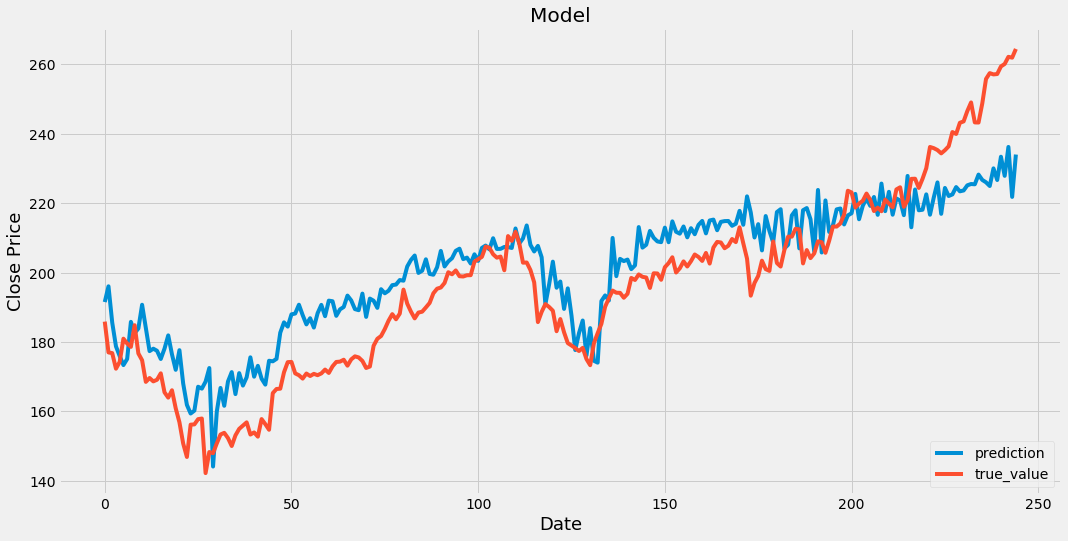

In [24]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(predictFrame)
plt.legend(['prediction', 'true_value'], loc='lower right')
plt.show()

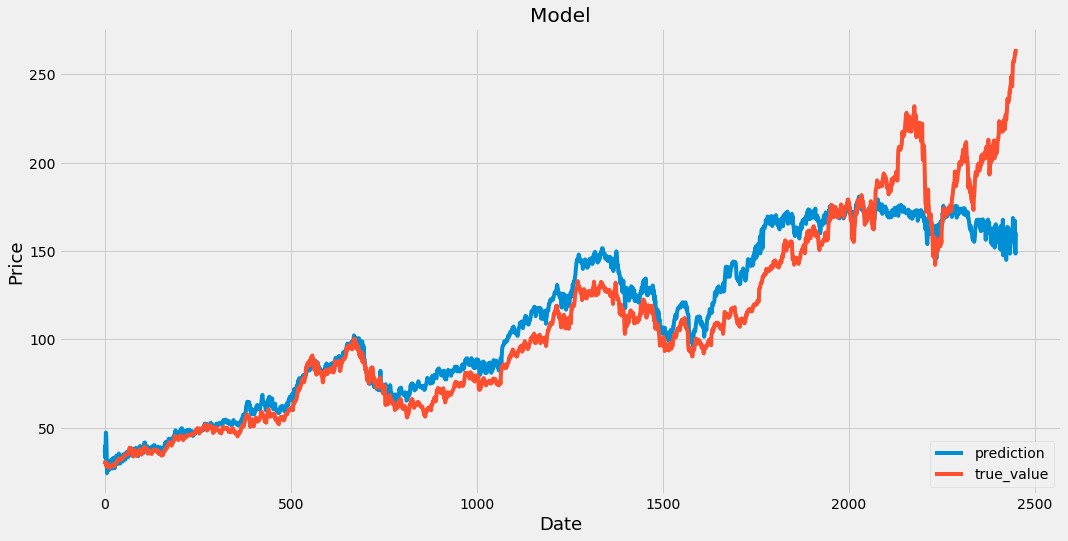

In [20]:
a = predicted_train.reshape(X_train.shape[0]).tolist()
b = predicted_valid.reshape(X_valid.shape[0]).tolist()
c = predicted_test.reshape(X_test.shape[0]).tolist()
d = y_train.reshape(X_train.shape[0]).tolist()
e = y_valid.reshape(X_valid.shape[0]).tolist()
f = y_test.reshape(X_test.shape[0]).tolist()
a.extend(b)
a.extend(c)
d.extend(e)
d.extend(f)
predictFrame = pd.DataFrame({'prediction': a, 'true_value': d})
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(predictFrame)
plt.legend(['prediction', 'true_value'], loc='lower right')
plt.show()

# Test Best Stacks

In [240]:
batch_size = 7
model, X_train, y_train, X_valid, y_valid, X_test, y_test  = model_train(buildTrendModel_1stacks, 7, stock_with_absolute, label_abs_1d, 64, batch_size)

predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
print()
result(np.where(predicted_test > 0.5, 1, 0), y_test, np.where(predicted_train > 0.5, 1, 0), y_train, np.where(predicted_valid > 0.5, 1, 0), y_valid,
       "./LSTM_RESULT/LSTM_7d_sequence_1stack_hid64", model.predict, clf_name="LSTM")

trim:  6
trim:  6
trim:  4
trim:  4
trim:  1
trim:  1
(1981, 7, 92)


/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  after removing the cwd from sys.path.


Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_101 (LSTM)              (7, 64)                   40192     
_________________________________________________________________
dense_59 (Dense)             (7, 20)                   1300      
_________________________________________________________________
dense_60 (Dense)             (7, 1)                    21        
Total params: 41,513
Trainable params: 41,513
Non-trainable params: 0
_________________________________________________________________
Epoch 00201: early stopping

Results for  LSTM : 

The Train Accuracy  0.551
The Validation Accuracy  0.507
The Test Accuracy   0.518
AUC ROC : 0.481
confusion matrix / precision recall scores
[[114  21]
 [ 97  13]]
              precision    recall  f1-score   support

           0       0.54      0.84      0.66       135
           1       0.38      0.12      0.18       110


In [243]:
batch_size = 7
model, X_train, y_train, X_valid, y_valid, X_test, y_test  = model_train(buildTrendModel_2stacks, 7, stock_with_absolute, label_abs_1d, 64, batch_size)

predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
print()
result(np.where(predicted_test > 0.5, 1, 0), y_test, np.where(predicted_train > 0.5, 1, 0), y_train, np.where(predicted_valid > 0.5, 1, 0), y_valid,
       "./LSTM_RESULT/LSTM_7d_sequence_2stack_hid64", model.predict, clf_name="LSTM")

trim:  6
trim:  6
trim:  4
trim:  4
trim:  1
trim:  1


/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, stateful=True, kernel_initializer="RandomUniform")`
  after removing the cwd from sys.path.


Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_104 (LSTM)              (7, 7, 64)                40192     
_________________________________________________________________
lstm_105 (LSTM)              (7, 64)                   33024     
_________________________________________________________________
dropout_67 (Dropout)         (7, 64)                   0         
_________________________________________________________________
dense_63 (Dense)             (7, 20)                   1300      
_________________________________________________________________
dense_64 (Dense)             (7, 1)                    21        
Total params: 74,537
Trainable params: 74,537
Non-trainable params: 0
_________________________________________________________________
Epoch 00344: early stopping

Results for  LSTM : 

The Train Accuracy  0.947
The Validation Accuracy  0.525
The Tes

In [244]:
batch_size = 7
model, X_train, y_train, X_valid, y_valid, X_test, y_test  = model_train(buildTrendModel_3stacks, 7, stock_with_absolute, label_abs_1d, 64, batch_size)

predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
print()
result(np.where(predicted_test > 0.5, 1, 0), y_test, np.where(predicted_train > 0.5, 1, 0), y_train, np.where(predicted_valid > 0.5, 1, 0), y_valid,
       "./LSTM_RESULT/LSTM_7d_sequence_3stack_hid64", model.predict, clf_name="LSTM")

trim:  6
trim:  6
trim:  4
trim:  4
trim:  1
trim:  1


/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, stateful=True, kernel_initializer="RandomUniform")`
  """
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, stateful=True, kernel_initializer="RandomUniform")`
  


Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_106 (LSTM)              (7, 7, 64)                40192     
_________________________________________________________________
dropout_68 (Dropout)         (7, 7, 64)                0         
_________________________________________________________________
lstm_107 (LSTM)              (7, 7, 64)                33024     
_________________________________________________________________
lstm_108 (LSTM)              (7, 64)                   33024     
_________________________________________________________________
dropout_69 (Dropout)         (7, 64)                   0         
_________________________________________________________________
dense_65 (Dense)             (7, 20)                   1300      
_________________________________________________________________
dense_66 (Dense)             (7, 1)                  

In [245]:
batch_size = 7
model, X_train, y_train, X_valid, y_valid, X_test, y_test  = model_train(buildTrendModel_4stacks, 7, stock_with_absolute, label_abs_1d, 64, batch_size)

predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
print()
result(np.where(predicted_test > 0.5, 1, 0), y_test, np.where(predicted_train > 0.5, 1, 0), y_train, np.where(predicted_valid > 0.5, 1, 0), y_valid,
       "./LSTM_RESULT/LSTM_7d_sequence_4stack_hid64", model.predict, clf_name="LSTM")

trim:  6
trim:  6
trim:  4
trim:  4
trim:  1
trim:  1


/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, stateful=True, kernel_initializer="RandomUniform")`
  """
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, stateful=True, kernel_initializer="RandomUniform")`
  
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, stateful=True, kernel_initializer="RandomUniform")`
  impo

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_109 (LSTM)              (7, 7, 64)                40192     
_________________________________________________________________
dropout_70 (Dropout)         (7, 7, 64)                0         
_________________________________________________________________
lstm_110 (LSTM)              (7, 7, 64)                33024     
_________________________________________________________________
lstm_111 (LSTM)              (7, 7, 64)                33024     
_________________________________________________________________
lstm_112 (LSTM)              (7, 64)                   33024     
_________________________________________________________________
dropout_71 (Dropout)         (7, 64)                   0         
_________________________________________________________________
dense_67 (Dense)             (7, 20)                 

# Test Best Stacks (using loss)

In [253]:
batch_size = 7
model, X_train, y_train, X_valid, y_valid, X_test, y_test  = model_train_loss(buildTrendModel_1stacks, 7, stock_with_absolute, label_abs_1d, 64, batch_size)

predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
print()
result(np.where(predicted_test > 0.5, 1, 0), y_test, np.where(predicted_train > 0.5, 1, 0), y_train, np.where(predicted_valid > 0.5, 1, 0), y_valid,
       "./LSTM_RESULT/LSTM_7d_sequence_1stack_hid64_loss", model.predict, clf_name="LSTM")

(1981, 7, 92)


/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  after removing the cwd from sys.path.


Epoch 00242: early stopping

Results for  LSTM : 

The Train Accuracy  0.562
The Validation Accuracy  0.525
The Test Accuracy   0.527
AUC ROC : 0.493
confusion matrix / precision recall scores
[[111  24]
 [ 92  18]]
              precision    recall  f1-score   support

           0       0.55      0.82      0.66       135
           1       0.43      0.16      0.24       110

    accuracy                           0.53       245
   macro avg       0.49      0.49      0.45       245
weighted avg       0.49      0.53      0.47       245



In [254]:
batch_size = 7
model, X_train, y_train, X_valid, y_valid, X_test, y_test  = model_train_loss(buildTrendModel_2stacks, 7, stock_with_absolute, label_abs_1d, 64, batch_size)

predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
print()
result(np.where(predicted_test > 0.5, 1, 0), y_test, np.where(predicted_train > 0.5, 1, 0), y_train, np.where(predicted_valid > 0.5, 1, 0), y_valid,
       "./LSTM_RESULT/LSTM_7d_sequence_2stack_hid64_loss", model.predict, clf_name="LSTM")

/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, stateful=True, kernel_initializer="RandomUniform")`
  after removing the cwd from sys.path.


Epoch 00391: early stopping

Results for  LSTM : 

The Train Accuracy  0.850
The Validation Accuracy  0.512
The Test Accuracy   0.514
AUC ROC : 0.513
confusion matrix / precision recall scores
[[71 64]
 [55 55]]
              precision    recall  f1-score   support

           0       0.56      0.53      0.54       135
           1       0.46      0.50      0.48       110

    accuracy                           0.51       245
   macro avg       0.51      0.51      0.51       245
weighted avg       0.52      0.51      0.52       245



In [255]:
batch_size = 7
model, X_train, y_train, X_valid, y_valid, X_test, y_test  = model_train_loss(buildTrendModel_3stacks, 7, stock_with_absolute, label_abs_1d, 64, batch_size)

predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
print()
result(np.where(predicted_test > 0.5, 1, 0), y_test, np.where(predicted_train > 0.5, 1, 0), y_train, np.where(predicted_valid > 0.5, 1, 0), y_valid,
       "./LSTM_RESULT/LSTM_7d_sequence_3stack_hid64_loss", model.predict, clf_name="LSTM")

/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, stateful=True, kernel_initializer="RandomUniform")`
  after removing the cwd from sys.path.
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, stateful=True, kernel_initializer="RandomUniform")`
  


Epoch 00224: early stopping

Results for  LSTM : 

The Train Accuracy  0.998
The Validation Accuracy  0.539
The Test Accuracy   0.551
AUC ROC : 0.544
confusion matrix / precision recall scores
[[83 52]
 [58 52]]
              precision    recall  f1-score   support

           0       0.59      0.61      0.60       135
           1       0.50      0.47      0.49       110

    accuracy                           0.55       245
   macro avg       0.54      0.54      0.54       245
weighted avg       0.55      0.55      0.55       245



In [256]:
batch_size = 7
model, X_train, y_train, X_valid, y_valid, X_test, y_test  = model_train_loss(buildTrendModel_4stacks, 7, stock_with_absolute, label_abs_1d, 64, batch_size)

predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
print()
result(np.where(predicted_test > 0.5, 1, 0), y_test, np.where(predicted_train > 0.5, 1, 0), y_train, np.where(predicted_valid > 0.5, 1, 0), y_valid,
       "./LSTM_RESULT/LSTM_7d_sequence_4stack_hid64_loss", model.predict, clf_name="LSTM")

/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, stateful=True, kernel_initializer="RandomUniform")`
  after removing the cwd from sys.path.
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, stateful=True, kernel_initializer="RandomUniform")`
  
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, stateful=True, kernel_in

Epoch 00249: early stopping

Results for  LSTM : 

The Train Accuracy  0.997
The Validation Accuracy  0.507
The Test Accuracy   0.551
AUC ROC : 0.555
confusion matrix / precision recall scores
[[70 65]
 [45 65]]
              precision    recall  f1-score   support

           0       0.61      0.52      0.56       135
           1       0.50      0.59      0.54       110

    accuracy                           0.55       245
   macro avg       0.55      0.55      0.55       245
weighted avg       0.56      0.55      0.55       245



# Test Best Layer (using loss)

In [258]:
batch_size = 7
hidden_layer_size = [32 , 64, 128]
predict_day = [label_abs_1d, label_abs_7d, label_abs_30d]
predict_day_str = ["1d", "7d", "30d"]

for day in range(3):
    print("Start Predict ", predict_day_str[day])
    for layer_size in hidden_layer_size:
        print("Layer: ", layer_size)
        batch_size = 7
        model, X_train, y_train, X_valid, y_valid, X_test, y_test = model_train_loss(buildTrendModel_3stacks, 7, 
        stock_with_absolute, predict_day[day], layer_size, batch_size)

        predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
        predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
        predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
        print()
        result(np.where(predicted_test > 0.5, 1, 0), y_test, np.where(predicted_train > 0.5, 1, 0), y_train, np.where(predicted_valid > 0.5, 1, 0), y_valid,
               "./LSTM_RESULT/best_layer_with_abs/LSTM_"+predict_day_str[day]+"_sequence_3stack_hid"+str(layer_size)+"_loss", model.predict, clf_name="LSTM")
        
        

Start Predict  1d
Layer:  32


/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, return_sequences=True, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, return_sequences=True, stateful=True, kernel_initializer="RandomUniform")`
  after removing the cwd from sys.path.
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, stateful=True, kernel_initializer="RandomUniform")`
  


Epoch 00331: early stopping

Results for  LSTM : 

The Train Accuracy  0.718
The Validation Accuracy  0.484
The Test Accuracy   0.539
AUC ROC : 0.517
confusion matrix / precision recall scores
[[99 36]
 [77 33]]
              precision    recall  f1-score   support

           0       0.56      0.73      0.64       135
           1       0.48      0.30      0.37       110

    accuracy                           0.54       245
   macro avg       0.52      0.52      0.50       245
weighted avg       0.52      0.54      0.52       245

Layer:  64


/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, stateful=True, kernel_initializer="RandomUniform")`
  after removing the cwd from sys.path.
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, stateful=True, kernel_initializer="RandomUniform")`
  


Epoch 00309: early stopping

Results for  LSTM : 

The Train Accuracy  0.975
The Validation Accuracy  0.475
The Test Accuracy   0.514
AUC ROC : 0.517
confusion matrix / precision recall scores
[[66 69]
 [50 60]]
              precision    recall  f1-score   support

           0       0.57      0.49      0.53       135
           1       0.47      0.55      0.50       110

    accuracy                           0.51       245
   macro avg       0.52      0.52      0.51       245
weighted avg       0.52      0.51      0.52       245

Layer:  128


/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, stateful=True, kernel_initializer="RandomUniform")`
  after removing the cwd from sys.path.
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, stateful=True, kernel_initializer="RandomUniform")`
  


Epoch 00214: early stopping

Results for  LSTM : 

The Train Accuracy  0.525
The Validation Accuracy  0.530
The Test Accuracy   0.551
AUC ROC : 0.500
confusion matrix / precision recall scores
[[135   0]
 [110   0]]
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       135
           1       0.00      0.00      0.00       110

    accuracy                           0.55       245
   macro avg       0.28      0.50      0.36       245
weighted avg       0.30      0.55      0.39       245

Start Predict  7d
Layer:  32


/Users/chinkashiwakin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chinkashiwakin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, return_sequences=True, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00333: early stopping

Results for  LSTM : 

The Train Accuracy  0.926
The Validation Accuracy  0.558
The Test Accuracy   0.600
AUC ROC : 0.553
confusion matrix / precision recall scores
[[115  57]
 [ 41  32]]
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       172
           1       0.36      0.44      0.40        73

    accuracy                           0.60       245
   macro avg       0.55      0.55      0.55       245
weighted avg       0.62      0.60      0.61       245

Layer:  64


/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, stateful=True, kernel_initializer="RandomUniform")`
  after removing the cwd from sys.path.
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, stateful=True, kernel_initializer="RandomUniform")`
  


Epoch 00311: early stopping

Results for  LSTM : 

The Train Accuracy  0.994
The Validation Accuracy  0.594
The Test Accuracy   0.478
AUC ROC : 0.494
confusion matrix / precision recall scores
[[78 94]
 [34 39]]
              precision    recall  f1-score   support

           0       0.70      0.45      0.55       172
           1       0.29      0.53      0.38        73

    accuracy                           0.48       245
   macro avg       0.49      0.49      0.46       245
weighted avg       0.58      0.48      0.50       245

Layer:  128


/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, stateful=True, kernel_initializer="RandomUniform")`
  after removing the cwd from sys.path.
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, stateful=True, kernel_initializer="RandomUniform")`
  


Epoch 00240: early stopping

Results for  LSTM : 

The Train Accuracy  0.998
The Validation Accuracy  0.571
The Test Accuracy   0.543
AUC ROC : 0.489
confusion matrix / precision recall scores
[[107  65]
 [ 47  26]]
              precision    recall  f1-score   support

           0       0.69      0.62      0.66       172
           1       0.29      0.36      0.32        73

    accuracy                           0.54       245
   macro avg       0.49      0.49      0.49       245
weighted avg       0.57      0.54      0.56       245

Start Predict  30d
Layer:  32


/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, return_sequences=True, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, return_sequences=True, stateful=True, kernel_initializer="RandomUniform")`
  after removing the cwd from sys.path.
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, stateful=True, kernel_initializer="RandomUniform")`
  


Epoch 00322: early stopping

Results for  LSTM : 

The Train Accuracy  0.947
The Validation Accuracy  0.567
The Test Accuracy   0.796
AUC ROC : 0.547
confusion matrix / precision recall scores
[[189   4]
 [ 46   6]]
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       193
           1       0.60      0.12      0.19        52

    accuracy                           0.80       245
   macro avg       0.70      0.55      0.54       245
weighted avg       0.76      0.80      0.74       245

Layer:  64


/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, stateful=True, kernel_initializer="RandomUniform")`
  after removing the cwd from sys.path.
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, stateful=True, kernel_initializer="RandomUniform")`
  


Epoch 00300: early stopping

Results for  LSTM : 

The Train Accuracy  0.993
The Validation Accuracy  0.659
The Test Accuracy   0.755
AUC ROC : 0.606
confusion matrix / precision recall scores
[[167  26]
 [ 34  18]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       193
           1       0.41      0.35      0.38        52

    accuracy                           0.76       245
   macro avg       0.62      0.61      0.61       245
weighted avg       0.74      0.76      0.75       245

Layer:  128


/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, batch_input_shape=(7, 7, 92), stateful=True, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, stateful=True, kernel_initializer="RandomUniform")`
  after removing the cwd from sys.path.
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, stateful=True, kernel_initializer="RandomUniform")`
  


Epoch 00201: early stopping

Results for  LSTM : 

The Train Accuracy  0.673
The Validation Accuracy  0.562
The Test Accuracy   0.788
AUC ROC : 0.500
confusion matrix / precision recall scores
[[193   0]
 [ 52   0]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       193
           1       0.00      0.00      0.00        52

    accuracy                           0.79       245
   macro avg       0.39      0.50      0.44       245
weighted avg       0.62      0.79      0.69       245



/Users/chinkashiwakin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chinkashiwakin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test All Parameters

In [276]:
import warnings
warnings.filterwarnings('ignore')

In [291]:
batch_size = 7
hidden_layer_size = [32 , 64, 128]
sequence_day = [1,3,7,15,30]
predict_day = [label_abs_1d, label_abs_7d, label_abs_30d]
predict_day_str = ["1d", "7d", "30d"]

for day in range(3):
    print("Start Predict ", predict_day_str[day])
    print()
    for layer_size in hidden_layer_size:
        print("Layer: ", layer_size)
        for past_day in sequence_day:
            print("Sequence number of day: ", past_day)
            model, X_train, y_train, X_valid, y_valid, X_test, y_test = model_train_loss(buildTrendModel_3stacks, past_day, 
            stock_with_absolute, predict_day[day], layer_size, batch_size)

            predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
            predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
            predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
            print()
            result(np.where(predicted_test > 0.5, 1, 0), y_test, np.where(predicted_train > 0.5, 1, 0), y_train, np.where(predicted_valid > 0.5, 1, 0), y_valid,
                   "./LSTM_RESULT/best_layer_seqnum_with_abs/LSTM_"+predict_day_str[day]+"_sequence_3stack_hid"+str(layer_size)+"_seq"+str(past_day)+"_loss", model.predict, clf_name="LSTM")
    print()
    print()
    print()
        
        

Start Predict  1d

Layer:  32
Sequence number of day:  1
Epoch 00804: early stopping

Results for  LSTM : 
The Train Accuracy  0.659
The Validation Accuracy  0.521
The Test Accuracy   0.531
AUC ROC : 0.494
confusion matrix / precision recall scores
[[115  20]
 [ 95  15]]
              precision    recall  f1-score   support

           0       0.55      0.85      0.67       135
           1       0.43      0.14      0.21       110

    accuracy                           0.53       245
   macro avg       0.49      0.49      0.44       245
weighted avg       0.49      0.53      0.46       245

Sequence number of day:  3
Epoch 00357: early stopping

Results for  LSTM : 
The Train Accuracy  0.729
The Validation Accuracy  0.521
The Test Accuracy   0.482
AUC ROC : 0.469
confusion matrix / precision recall scores
[[80 55]
 [72 38]]
              precision    recall  f1-score   support

           0       0.53      0.59      0.56       135
           1       0.41      0.35      0.37       110


Epoch 00511: early stopping

Results for  LSTM : 
The Train Accuracy  0.646
The Validation Accuracy  0.567
The Test Accuracy   0.686
AUC ROC : 0.512
confusion matrix / precision recall scores
[[162  10]
 [ 67   6]]
              precision    recall  f1-score   support

           0       0.71      0.94      0.81       172
           1       0.38      0.08      0.13        73

    accuracy                           0.69       245
   macro avg       0.54      0.51      0.47       245
weighted avg       0.61      0.69      0.61       245

Sequence number of day:  3
Epoch 00258: early stopping

Results for  LSTM : 
The Train Accuracy  0.718
The Validation Accuracy  0.576
The Test Accuracy   0.588
AUC ROC : 0.458
confusion matrix / precision recall scores
[[134  38]
 [ 63  10]]
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       172
           1       0.21      0.14      0.17        73

    accuracy                           0.59       24

Epoch 00206: early stopping

Results for  LSTM : 
The Train Accuracy  0.636
The Validation Accuracy  0.562
The Test Accuracy   0.788
AUC ROC : 0.500
confusion matrix / precision recall scores
[[193   0]
 [ 52   0]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       193
           1       0.00      0.00      0.00        52

    accuracy                           0.79       245
   macro avg       0.39      0.50      0.44       245
weighted avg       0.62      0.79      0.69       245

Sequence number of day:  3
Epoch 00201: early stopping

Results for  LSTM : 
The Train Accuracy  0.629
The Validation Accuracy  0.562
The Test Accuracy   0.788
AUC ROC : 0.500
confusion matrix / precision recall scores
[[193   0]
 [ 52   0]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       193
           1       0.00      0.00      0.00        52

    accuracy                           0.79       24

In [292]:
batch_size = 7
hidden_layer_size = [32 , 64, 128]
sequence_day = [1,3,7,15,30]
predict_day = [label_abs_1d, label_abs_7d, label_abs_30d]
predict_day_str = ["1d", "7d", "30d"]

for day in range(3):
    print("Start Predict ", predict_day_str[day])
    print()
    for layer_size in hidden_layer_size:
        print("Layer: ", layer_size)
        for past_day in sequence_day:
            print("Sequence number of day: ", past_day)
            model, X_train, y_train, X_valid, y_valid, X_test, y_test = model_train_loss(buildTrendModel_3stacks, past_day, 
            stock_without_absolute, predict_day[day], layer_size, batch_size)

            predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
            predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
            predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
            print()
            result(np.where(predicted_test > 0.5, 1, 0), y_test, np.where(predicted_train > 0.5, 1, 0), y_train, np.where(predicted_valid > 0.5, 1, 0), y_valid,
                   "./LSTM_RESULT/best_layer_seqnum_without_abs/LSTM_"+predict_day_str[day]+"_sequence_3stack_hid"+str(layer_size)+"_seq"+str(past_day)+"_loss", model.predict, clf_name="LSTM")
    print()
    print()
    print()
        
        

Start Predict  1d

Layer:  32
Sequence number of day:  1
Epoch 00211: early stopping

Results for  LSTM : 
The Train Accuracy  0.681
The Validation Accuracy  0.475
The Test Accuracy   0.535
AUC ROC : 0.510
confusion matrix / precision recall scores
[[101  34]
 [ 80  30]]
              precision    recall  f1-score   support

           0       0.56      0.75      0.64       135
           1       0.47      0.27      0.34       110

    accuracy                           0.53       245
   macro avg       0.51      0.51      0.49       245
weighted avg       0.52      0.53      0.51       245

Sequence number of day:  3
Epoch 00213: early stopping

Results for  LSTM : 
The Train Accuracy  0.841
The Validation Accuracy  0.521
The Test Accuracy   0.543
AUC ROC : 0.540
confusion matrix / precision recall scores
[[77 58]
 [54 56]]
              precision    recall  f1-score   support

           0       0.59      0.57      0.58       135
           1       0.49      0.51      0.50       110


Epoch 00207: early stopping

Results for  LSTM : 
The Train Accuracy  0.711
The Validation Accuracy  0.558
The Test Accuracy   0.584
AUC ROC : 0.510
confusion matrix / precision recall scores
[[119  53]
 [ 49  24]]
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       172
           1       0.31      0.33      0.32        73

    accuracy                           0.58       245
   macro avg       0.51      0.51      0.51       245
weighted avg       0.59      0.58      0.59       245

Sequence number of day:  3
Epoch 00212: early stopping

Results for  LSTM : 
The Train Accuracy  0.820
The Validation Accuracy  0.544
The Test Accuracy   0.624
AUC ROC : 0.500
confusion matrix / precision recall scores
[[139  33]
 [ 59  14]]
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       172
           1       0.30      0.19      0.23        73

    accuracy                           0.62       24

Epoch 00212: early stopping

Results for  LSTM : 
The Train Accuracy  0.749
The Validation Accuracy  0.585
The Test Accuracy   0.796
AUC ROC : 0.554
confusion matrix / precision recall scores
[[188   5]
 [ 45   7]]
              precision    recall  f1-score   support

           0       0.81      0.97      0.88       193
           1       0.58      0.13      0.22        52

    accuracy                           0.80       245
   macro avg       0.70      0.55      0.55       245
weighted avg       0.76      0.80      0.74       245

Sequence number of day:  3
Epoch 00230: early stopping

Results for  LSTM : 
The Train Accuracy  0.926
The Validation Accuracy  0.493
The Test Accuracy   0.576
AUC ROC : 0.443
confusion matrix / precision recall scores
[[130  63]
 [ 41  11]]
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       193
           1       0.15      0.21      0.17        52

    accuracy                           0.58       24

In [ ]:
batch_size = 7
sequence_day = 7 #???
hidden_layer_size = [32 , 64, 128]
predict_day = [label_abs_1d, label_abs_7d, label_abs_30d]
predict_day_str = ["1d", "7d", "30d"]

for day in range(3):
    print("Start Predict ", predict_day_str[day])
    for layer_size in hidden_layer_size:
        print("Layer: ", layer_size)
        batch_size = 7
        model, X_train, y_train, X_valid, y_valid, X_test, y_test = model_train_loss(buildTrendModel_3stacks, sequence_day, 
        stock_without_absolute, predict_day[day], layer_size, batch_size)

        predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
        predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
        predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
        print()
        result(np.where(predicted_test > 0.5, 1, 0), y_test, np.where(predicted_train > 0.5, 1, 0), y_train, np.where(predicted_valid > 0.5, 1, 0), y_valid,
               "./LSTM_RESULT/best_layer_with_abs/LSTM_"+predict_day_str[day]+"_sequence_3stack_hid"+str(layer_size)+"_loss", model.predict, clf_name="LSTM")
        
        

In [ ]:
hidden_layer_size = [32 , 64, 128]
past_days = [1,2,4,7,14,30]

In [46]:
PAST_DAYS = 1
X_train_batches, y_train_batches = build_batch(stock_with_abs_norm, label_abs_1d, PAST_DAYS, 1)
X_train, X_test, y_train, y_test = train_test_split(X_train_batches, y_train_batches, test_size=0.1, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

model = buildTrendModel(X_train.shape)
callback = EarlyStopping(monitor="val_loss", patience=200, verbose=1, mode="min")
model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[callback])


/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(50, return_sequences=True, input_shape=(1, 92))`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(75, return_sequences=True, input_shape=(1, 92))`
  """


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 1, 50)             28600     
_________________________________________________________________
dropout_18 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 1, 75)             37800     
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 75)             0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 100)               70400     
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

1992/1992 [==============================] - 0s 65us/step - loss: 0.6610 - accuracy: 0.5863 - val_loss: 0.7390 - val_accuracy: 0.5270
Epoch 103/1000
1992/1992 [==============================] - 0s 62us/step - loss: 0.6605 - accuracy: 0.5813 - val_loss: 0.7369 - val_accuracy: 0.4595
Epoch 104/1000
1992/1992 [==============================] - 0s 69us/step - loss: 0.6604 - accuracy: 0.5848 - val_loss: 0.7326 - val_accuracy: 0.5360
Epoch 105/1000
1992/1992 [==============================] - 0s 64us/step - loss: 0.6601 - accuracy: 0.5949 - val_loss: 0.7259 - val_accuracy: 0.4955
Epoch 106/1000
1992/1992 [==============================] - 0s 62us/step - loss: 0.6611 - accuracy: 0.5863 - val_loss: 0.7187 - val_accuracy: 0.5315
Epoch 107/1000
1992/1992 [==============================] - 0s 63us/step - loss: 0.6657 - accuracy: 0.5713 - val_loss: 0.7192 - val_accuracy: 0.5180
Epoch 108/1000
1992/1992 [==============================] - 0s 63us/step - loss: 0.6565 - accuracy: 0.5959 - val_loss: 0.

1992/1992 [==============================] - 0s 68us/step - loss: 0.6387 - accuracy: 0.6170 - val_loss: 0.7849 - val_accuracy: 0.5270
Epoch 158/1000
1992/1992 [==============================] - 0s 66us/step - loss: 0.6424 - accuracy: 0.6049 - val_loss: 0.7858 - val_accuracy: 0.5000
Epoch 159/1000
1992/1992 [==============================] - 0s 66us/step - loss: 0.6400 - accuracy: 0.6044 - val_loss: 0.7672 - val_accuracy: 0.5270
Epoch 160/1000
1992/1992 [==============================] - 0s 65us/step - loss: 0.6401 - accuracy: 0.6049 - val_loss: 0.8022 - val_accuracy: 0.4910
Epoch 161/1000
1992/1992 [==============================] - 0s 64us/step - loss: 0.6412 - accuracy: 0.6160 - val_loss: 0.7493 - val_accuracy: 0.5180
Epoch 162/1000
1992/1992 [==============================] - 0s 76us/step - loss: 0.6389 - accuracy: 0.6150 - val_loss: 0.8286 - val_accuracy: 0.4820
Epoch 163/1000
1992/1992 [==============================] - 0s 82us/step - loss: 0.6408 - accuracy: 0.5989 - val_loss: 0.

1992/1992 [==============================] - 0s 69us/step - loss: 0.6227 - accuracy: 0.6205 - val_loss: 0.8381 - val_accuracy: 0.5360
Epoch 213/1000
1992/1992 [==============================] - 0s 70us/step - loss: 0.6167 - accuracy: 0.6235 - val_loss: 0.8567 - val_accuracy: 0.4640
Epoch 214/1000
1992/1992 [==============================] - 0s 79us/step - loss: 0.6206 - accuracy: 0.6265 - val_loss: 0.8102 - val_accuracy: 0.5000
Epoch 00214: early stopping


In [47]:
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=32)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test)
print('predictions shape:', predictions.shape)


rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)


# Evaluate on test data
246/246 [==============================] - 0s 49us/step
test loss, test acc: [0.881428475787, 0.5325203537940979]

# Generate predictions for 3 samples
predictions shape: (246, 1)
rmse: 0.5213076995516022


* Without Absolute Value

In [48]:
PAST_DAYS = 7
X_train_batches, y_train_batches = build_batch(stock_with_abs_norm, label_abs_1d, PAST_DAYS, 1)
X_train, X_test, y_train, y_test = train_test_split(X_train_batches, y_train_batches, test_size=0.1, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

model = buildTrendModel(X_train.shape)
callback = EarlyStopping(monitor="val_loss", patience=200, verbose=1, mode="min")
model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[callback])
print("7 day")
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=32)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test)
print('predictions shape:', predictions.shape)


rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)


/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(50, return_sequences=True, input_shape=(7, 92))`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(75, return_sequences=True, input_shape=(7, 92))`
  """


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 7, 50)             28600     
_________________________________________________________________
dropout_21 (Dropout)         (None, 7, 50)             0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 7, 75)             37800     
_________________________________________________________________
dropout_22 (Dropout)         (None, 7, 75)             0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 100)               70400     
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)               

1987/1987 [==============================] - 1s 317us/step - loss: 0.6771 - accuracy: 0.5682 - val_loss: 0.7039 - val_accuracy: 0.5339
Epoch 103/1000
1987/1987 [==============================] - 1s 297us/step - loss: 0.6804 - accuracy: 0.5606 - val_loss: 0.7029 - val_accuracy: 0.5294
Epoch 104/1000
1987/1987 [==============================] - 1s 276us/step - loss: 0.6791 - accuracy: 0.5425 - val_loss: 0.7009 - val_accuracy: 0.5475
Epoch 105/1000
1987/1987 [==============================] - 1s 383us/step - loss: 0.6755 - accuracy: 0.5697 - val_loss: 0.7020 - val_accuracy: 0.5339
Epoch 106/1000
1987/1987 [==============================] - 1s 291us/step - loss: 0.6730 - accuracy: 0.5757 - val_loss: 0.7042 - val_accuracy: 0.5113
Epoch 107/1000
1987/1987 [==============================] - 1s 309us/step - loss: 0.6764 - accuracy: 0.5637 - val_loss: 0.7016 - val_accuracy: 0.5475
Epoch 108/1000
1987/1987 [==============================] - 1s 392us/step - loss: 0.6759 - accuracy: 0.5687 - val_l

Epoch 157/1000
1987/1987 [==============================] - 1s 261us/step - loss: 0.6502 - accuracy: 0.6170 - val_loss: 0.7057 - val_accuracy: 0.5204
Epoch 158/1000
1987/1987 [==============================] - 0s 251us/step - loss: 0.6180 - accuracy: 0.6402 - val_loss: 0.7523 - val_accuracy: 0.5747
Epoch 159/1000
1987/1987 [==============================] - 1s 269us/step - loss: 0.6173 - accuracy: 0.6381 - val_loss: 0.7351 - val_accuracy: 0.5249
Epoch 160/1000
1987/1987 [==============================] - 0s 250us/step - loss: 0.6044 - accuracy: 0.6573 - val_loss: 0.7496 - val_accuracy: 0.5294
Epoch 161/1000
1987/1987 [==============================] - 1s 259us/step - loss: 0.6015 - accuracy: 0.6527 - val_loss: 0.7290 - val_accuracy: 0.5475
Epoch 162/1000
1987/1987 [==============================] - 0s 250us/step - loss: 0.6005 - accuracy: 0.6623 - val_loss: 0.7611 - val_accuracy: 0.5385
Epoch 163/1000
1987/1987 [==============================] - 1s 255us/step - loss: 0.5928 - accuracy:

In [51]:
PAST_DAYS = 15
X_train_batches, y_train_batches = build_batch(stock_with_abs_norm, label_abs_1d, PAST_DAYS, 1)
X_train, X_test, y_train, y_test = train_test_split(X_train_batches, y_train_batches, test_size=0.1, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

model = buildTrendModel(X_train.shape)
callback = EarlyStopping(monitor="val_loss", patience=200, verbose=1, mode="min")
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_valid, y_valid), callbacks=[callback])

print("15 day")
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test)
print('predictions shape:', predictions.shape)


rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)

/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(50, return_sequences=True, input_shape=(15, 92))`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(75, return_sequences=True, input_shape=(15, 92))`
  """


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 15, 50)            28600     
_________________________________________________________________
dropout_30 (Dropout)         (None, 15, 50)            0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 15, 75)            37800     
_________________________________________________________________
dropout_31 (Dropout)         (None, 15, 75)            0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 100)               70400     
_________________________________________________________________
dropout_32 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)               

1980/1980 [==============================] - 1s 470us/step - loss: 0.6477 - accuracy: 0.6076 - val_loss: 0.7389 - val_accuracy: 0.5339
Epoch 103/1000
1980/1980 [==============================] - 1s 461us/step - loss: 0.6428 - accuracy: 0.6232 - val_loss: 0.7570 - val_accuracy: 0.4842
Epoch 104/1000
1980/1980 [==============================] - 1s 459us/step - loss: 0.6520 - accuracy: 0.6081 - val_loss: 0.7199 - val_accuracy: 0.5339
Epoch 105/1000
1980/1980 [==============================] - 1s 452us/step - loss: 0.6478 - accuracy: 0.6253 - val_loss: 0.7652 - val_accuracy: 0.5339
Epoch 106/1000
1980/1980 [==============================] - 1s 451us/step - loss: 0.6468 - accuracy: 0.6101 - val_loss: 0.7471 - val_accuracy: 0.5249
Epoch 107/1000
1980/1980 [==============================] - 1s 493us/step - loss: 0.6412 - accuracy: 0.6141 - val_loss: 0.7549 - val_accuracy: 0.5294
Epoch 108/1000
1980/1980 [==============================] - 1s 457us/step - loss: 0.6401 - accuracy: 0.6192 - val_l

Epoch 157/1000
1980/1980 [==============================] - 1s 456us/step - loss: 0.5880 - accuracy: 0.6707 - val_loss: 0.8288 - val_accuracy: 0.5385
Epoch 158/1000
1980/1980 [==============================] - 1s 454us/step - loss: 0.5827 - accuracy: 0.6702 - val_loss: 0.8477 - val_accuracy: 0.5249
Epoch 159/1000
1980/1980 [==============================] - 1s 458us/step - loss: 0.5923 - accuracy: 0.6662 - val_loss: 0.8114 - val_accuracy: 0.5475
Epoch 160/1000
1980/1980 [==============================] - 1s 510us/step - loss: 0.5843 - accuracy: 0.6712 - val_loss: 0.9197 - val_accuracy: 0.5339
Epoch 161/1000
1980/1980 [==============================] - 1s 460us/step - loss: 0.5781 - accuracy: 0.6864 - val_loss: 0.8542 - val_accuracy: 0.5566
Epoch 162/1000
1980/1980 [==============================] - 1s 484us/step - loss: 0.5720 - accuracy: 0.6803 - val_loss: 0.8914 - val_accuracy: 0.5113
Epoch 163/1000
1980/1980 [==============================] - 1s 479us/step - loss: 0.5756 - accuracy:

In [50]:
PAST_DAYS = 30
X_train_batches, y_train_batches = build_batch(stock_with_abs_norm, label_abs_1d, PAST_DAYS, 1)
X_train, X_test, y_train, y_test = train_test_split(X_train_batches, y_train_batches, test_size=0.1, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

model = buildTrendModel(X_train.shape)
callback = EarlyStopping(monitor="val_loss", patience=200, verbose=1, mode="min")
model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[callback])
print("30 day")
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=32)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test)
print('predictions shape:', predictions.shape)


rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)

/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(50, return_sequences=True, input_shape=(30, 92))`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(75, return_sequences=True, input_shape=(30, 92))`
  """


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 30, 50)            28600     
_________________________________________________________________
dropout_27 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 30, 75)            37800     
_________________________________________________________________
dropout_28 (Dropout)         (None, 30, 75)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 100)               70400     
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)               

Epoch 48/1000
1968/1968 [==============================] - 2s 1ms/step - loss: 0.6812 - accuracy: 0.5549 - val_loss: 0.6952 - val_accuracy: 0.5114
Epoch 49/1000
1968/1968 [==============================] - 2s 1ms/step - loss: 0.6771 - accuracy: 0.5681 - val_loss: 0.7124 - val_accuracy: 0.4840
Epoch 50/1000
1968/1968 [==============================] - 2s 1ms/step - loss: 0.6822 - accuracy: 0.5534 - val_loss: 0.6886 - val_accuracy: 0.5205
Epoch 51/1000
1968/1968 [==============================] - 2s 1ms/step - loss: 0.6781 - accuracy: 0.5757 - val_loss: 0.7014 - val_accuracy: 0.4840
Epoch 52/1000
1968/1968 [==============================] - 2s 1ms/step - loss: 0.6784 - accuracy: 0.5630 - val_loss: 0.6873 - val_accuracy: 0.5251
Epoch 53/1000
1968/1968 [==============================] - 2s 1ms/step - loss: 0.6788 - accuracy: 0.5549 - val_loss: 0.7087 - val_accuracy: 0.4886
Epoch 54/1000
1968/1968 [==============================] - 2s 1ms/step - loss: 0.6770 - accuracy: 0.5696 - val_loss: 0

1968/1968 [==============================] - 2s 1ms/step - loss: 0.4812 - accuracy: 0.7449 - val_loss: 1.0531 - val_accuracy: 0.5297
Epoch 159/1000
1968/1968 [==============================] - 2s 1ms/step - loss: 0.4714 - accuracy: 0.7434 - val_loss: 1.1627 - val_accuracy: 0.4247
Epoch 160/1000
1968/1968 [==============================] - 2s 1ms/step - loss: 0.4797 - accuracy: 0.7419 - val_loss: 1.0976 - val_accuracy: 0.4886
Epoch 161/1000
1968/1968 [==============================] - 2s 998us/step - loss: 0.4768 - accuracy: 0.7434 - val_loss: 1.0153 - val_accuracy: 0.4703
Epoch 162/1000
1968/1968 [==============================] - 2s 1ms/step - loss: 0.4597 - accuracy: 0.7586 - val_loss: 1.0393 - val_accuracy: 0.5205
Epoch 163/1000
1968/1968 [==============================] - 2s 991us/step - loss: 0.4739 - accuracy: 0.7388 - val_loss: 1.1401 - val_accuracy: 0.4932
Epoch 164/1000
1968/1968 [==============================] - 2s 1ms/step - loss: 0.4579 - accuracy: 0.7571 - val_loss: 1.102

In [59]:
######################################
PAST_DAYS = 30
X_train_batches, y_train_batches = build_batch(stock_with_abs_norm, label_abs_1d, PAST_DAYS, 1)
X_train, X_test, y_train, y_test = train_test_split(X_train_batches, y_train_batches, test_size=0.1, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

model = buildTrendModel(X_train.shape)
callback = EarlyStopping(monitor="val_accuracy", patience=200, verbose=1, mode="min")
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_valid, y_valid), callbacks=[callback])
print("30 day")
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=32)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test)
print('predictions shape:', predictions.shape)


rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)

/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(50, return_sequences=True, input_shape=(30, 92))`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(75, return_sequences=True, input_shape=(30, 92))`
  """


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 30, 50)            28600     
_________________________________________________________________
dropout_43 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 30, 75)            37800     
_________________________________________________________________
dropout_44 (Dropout)         (None, 30, 75)            0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 100)               70400     
_________________________________________________________________
dropout_45 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)               

1968/1968 [==============================] - 2s 825us/step - loss: 0.6328 - accuracy: 0.6341 - val_loss: 0.7608 - val_accuracy: 0.4521
Epoch 103/1000
1968/1968 [==============================] - 2s 846us/step - loss: 0.6336 - accuracy: 0.6347 - val_loss: 0.7830 - val_accuracy: 0.4886
Epoch 104/1000
1968/1968 [==============================] - 2s 833us/step - loss: 0.6333 - accuracy: 0.6336 - val_loss: 0.7324 - val_accuracy: 0.5160
Epoch 105/1000
1968/1968 [==============================] - 2s 828us/step - loss: 0.6385 - accuracy: 0.6225 - val_loss: 0.7615 - val_accuracy: 0.4886
Epoch 106/1000
1968/1968 [==============================] - 2s 830us/step - loss: 0.6383 - accuracy: 0.6357 - val_loss: 0.7714 - val_accuracy: 0.4795
Epoch 107/1000
1968/1968 [==============================] - 2s 824us/step - loss: 0.6506 - accuracy: 0.6286 - val_loss: 0.7743 - val_accuracy: 0.4612
Epoch 108/1000
1968/1968 [==============================] - 2s 825us/step - loss: 0.6287 - accuracy: 0.6357 - val_l

Epoch 157/1000
1968/1968 [==============================] - 2s 824us/step - loss: 0.5395 - accuracy: 0.7088 - val_loss: 0.9561 - val_accuracy: 0.4977
Epoch 158/1000
1968/1968 [==============================] - 2s 833us/step - loss: 0.5673 - accuracy: 0.6839 - val_loss: 0.8926 - val_accuracy: 0.4977
Epoch 159/1000
1968/1968 [==============================] - 2s 835us/step - loss: 0.5560 - accuracy: 0.6905 - val_loss: 0.9696 - val_accuracy: 0.4886
Epoch 160/1000
1968/1968 [==============================] - 2s 822us/step - loss: 0.5541 - accuracy: 0.6987 - val_loss: 0.9650 - val_accuracy: 0.4977
Epoch 161/1000
1968/1968 [==============================] - 2s 800us/step - loss: 0.5534 - accuracy: 0.6855 - val_loss: 0.9668 - val_accuracy: 0.4886
Epoch 162/1000
1968/1968 [==============================] - 2s 808us/step - loss: 0.5436 - accuracy: 0.6900 - val_loss: 0.9495 - val_accuracy: 0.5251
Epoch 163/1000
1968/1968 [==============================] - 2s 810us/step - loss: 0.5314 - accuracy:

Epoch 266/1000
1968/1968 [==============================] - 2s 857us/step - loss: 0.3159 - accuracy: 0.8389 - val_loss: 1.5660 - val_accuracy: 0.5023
Epoch 267/1000
1968/1968 [==============================] - 2s 837us/step - loss: 0.3217 - accuracy: 0.8420 - val_loss: 1.6273 - val_accuracy: 0.4886
Epoch 268/1000
1968/1968 [==============================] - 2s 831us/step - loss: 0.3070 - accuracy: 0.8491 - val_loss: 1.5968 - val_accuracy: 0.5434
Epoch 269/1000
1968/1968 [==============================] - 2s 836us/step - loss: 0.3025 - accuracy: 0.8511 - val_loss: 1.5670 - val_accuracy: 0.5297
Epoch 270/1000
1968/1968 [==============================] - 2s 818us/step - loss: 0.2864 - accuracy: 0.8572 - val_loss: 1.7966 - val_accuracy: 0.4703
Epoch 271/1000
1968/1968 [==============================] - 2s 805us/step - loss: 0.2970 - accuracy: 0.8592 - val_loss: 1.7786 - val_accuracy: 0.5205
Epoch 272/1000
1968/1968 [==============================] - 2s 809us/step - loss: 0.3225 - accuracy:

In [58]:
PAST_DAYS = 15
X_train_batches, y_train_batches = build_batch(stock_with_abs_norm, label_abs_1d, PAST_DAYS, 1)
X_train, X_test, y_train, y_test = train_test_split(X_train_batches, y_train_batches, test_size=0.1, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

model = buildTrendModel_4stacks(X_train.shape)
callback = EarlyStopping(monitor="val_loss", patience=200, verbose=1, mode="min")
model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[callback])

print("15 day")
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test)
print('predictions shape:', predictions.shape)


rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)

/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, input_shape=(15, 92), kernel_initializer="glorot_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, kernel_initializer="glorot_normal")`
  after removing the cwd from sys.path.
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, re

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 15, 128)           113152    
_________________________________________________________________
lstm_45 (LSTM)               (None, 15, 128)           131584    
_________________________________________________________________
lstm_46 (LSTM)               (None, 15, 64)            49408     
_________________________________________________________________
lstm_47 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_42 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 306,593
Trainable params: 306,593
Non-trainable params: 0
_______________________________________________

1980/1980 [==============================] - 1s 744us/step - loss: 0.6896 - accuracy: 0.5172 - val_loss: 0.6929 - val_accuracy: 0.5747
Epoch 49/1000
1980/1980 [==============================] - 2s 787us/step - loss: 0.6900 - accuracy: 0.5258 - val_loss: 0.6902 - val_accuracy: 0.5339
Epoch 50/1000
1980/1980 [==============================] - 2s 838us/step - loss: 0.6908 - accuracy: 0.5348 - val_loss: 0.6905 - val_accuracy: 0.5928
Epoch 51/1000
1980/1980 [==============================] - 1s 737us/step - loss: 0.6909 - accuracy: 0.5530 - val_loss: 0.6899 - val_accuracy: 0.5747
Epoch 52/1000
1980/1980 [==============================] - 2s 849us/step - loss: 0.6902 - accuracy: 0.5318 - val_loss: 0.6912 - val_accuracy: 0.5973
Epoch 53/1000
1980/1980 [==============================] - 2s 790us/step - loss: 0.6892 - accuracy: 0.5354 - val_loss: 0.6953 - val_accuracy: 0.4932
Epoch 54/1000
1980/1980 [==============================] - 2s 834us/step - loss: 0.6905 - accuracy: 0.5237 - val_loss: 0

Epoch 158/1000
1980/1980 [==============================] - 1s 750us/step - loss: 0.5280 - accuracy: 0.7222 - val_loss: 1.0194 - val_accuracy: 0.5023
Epoch 159/1000
1980/1980 [==============================] - 1s 748us/step - loss: 0.5174 - accuracy: 0.7313 - val_loss: 0.9869 - val_accuracy: 0.5113
Epoch 160/1000
1980/1980 [==============================] - 1s 746us/step - loss: 0.5119 - accuracy: 0.7343 - val_loss: 1.0292 - val_accuracy: 0.5113
Epoch 161/1000
1980/1980 [==============================] - 2s 781us/step - loss: 0.5231 - accuracy: 0.7247 - val_loss: 0.9317 - val_accuracy: 0.5113
Epoch 162/1000
1980/1980 [==============================] - 1s 756us/step - loss: 0.5065 - accuracy: 0.7328 - val_loss: 1.0171 - val_accuracy: 0.5068
Epoch 163/1000
1980/1980 [==============================] - 1s 744us/step - loss: 0.5268 - accuracy: 0.7146 - val_loss: 0.9725 - val_accuracy: 0.4932
Epoch 164/1000
1980/1980 [==============================] - 1s 732us/step - loss: 0.5293 - accuracy:

Epoch 00266: early stopping
15 day

# Evaluate on test data
245/245 [==============================] - 0s 203us/step
test loss, test acc: [2.2715577407759064, 0.5142857432365417]

# Generate predictions for 3 samples
predictions shape: (245, 1)
rmse: 0.6361083635720066


In [61]:
PAST_DAYS = 15
X_train_batches, y_train_batches = build_batch(stock_with_abs_norm, label_abs_1d, PAST_DAYS, 1)
X_train, X_test, y_train, y_test = train_test_split(X_train_batches, y_train_batches, test_size=0.1, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

model = buildTrendModel_4stacks(X_train.shape)
callback = EarlyStopping(monitor="val_accuracy", patience=200, verbose=1, mode="max")
model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[callback])

print("15 day")
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test)
print('predictions shape:', predictions.shape)


rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)

/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, input_shape=(15, 92), kernel_initializer="glorot_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, kernel_initializer="glorot_normal")`
  after removing the cwd from sys.path.
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, re

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 15, 128)           113152    
_________________________________________________________________
lstm_56 (LSTM)               (None, 15, 128)           131584    
_________________________________________________________________
lstm_57 (LSTM)               (None, 15, 64)            49408     
_________________________________________________________________
lstm_58 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_47 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 306,593
Trainable params: 306,593
Non-trainable params: 0
_______________________________________________

1980/1980 [==============================] - 1s 698us/step - loss: 0.6945 - accuracy: 0.4975 - val_loss: 0.6868 - val_accuracy: 0.5701
Epoch 49/1000
1980/1980 [==============================] - 1s 710us/step - loss: 0.6921 - accuracy: 0.5146 - val_loss: 0.6919 - val_accuracy: 0.5701
Epoch 50/1000
1980/1980 [==============================] - 1s 691us/step - loss: 0.6916 - accuracy: 0.5268 - val_loss: 0.6879 - val_accuracy: 0.5701
Epoch 51/1000
1980/1980 [==============================] - 1s 680us/step - loss: 0.6913 - accuracy: 0.5298 - val_loss: 0.6910 - val_accuracy: 0.5475
Epoch 52/1000
1980/1980 [==============================] - 1s 700us/step - loss: 0.6927 - accuracy: 0.5081 - val_loss: 0.6874 - val_accuracy: 0.5701
Epoch 53/1000
1980/1980 [==============================] - 1s 714us/step - loss: 0.6925 - accuracy: 0.5247 - val_loss: 0.6858 - val_accuracy: 0.5701
Epoch 54/1000
1980/1980 [==============================] - 1s 699us/step - loss: 0.6919 - accuracy: 0.5232 - val_loss: 0

1980/1980 [==============================] - 1s 699us/step - loss: 0.6855 - accuracy: 0.5394 - val_loss: 0.6987 - val_accuracy: 0.5249
Epoch 104/1000
1980/1980 [==============================] - 1s 688us/step - loss: 0.6867 - accuracy: 0.5404 - val_loss: 0.6899 - val_accuracy: 0.5701
Epoch 105/1000
1980/1980 [==============================] - 1s 680us/step - loss: 0.6845 - accuracy: 0.5465 - val_loss: 0.6929 - val_accuracy: 0.5023
Epoch 106/1000
1980/1980 [==============================] - 1s 701us/step - loss: 0.6896 - accuracy: 0.5278 - val_loss: 0.6889 - val_accuracy: 0.5520
Epoch 107/1000
1980/1980 [==============================] - 1s 699us/step - loss: 0.6869 - accuracy: 0.5505 - val_loss: 0.6906 - val_accuracy: 0.5158
Epoch 108/1000
1980/1980 [==============================] - 1s 706us/step - loss: 0.6860 - accuracy: 0.5389 - val_loss: 0.6952 - val_accuracy: 0.5566
Epoch 109/1000
1980/1980 [==============================] - 1s 688us/step - loss: 0.6818 - accuracy: 0.5515 - val_l

Epoch 158/1000
1980/1980 [==============================] - 1s 684us/step - loss: 0.6205 - accuracy: 0.6439 - val_loss: 0.7506 - val_accuracy: 0.5249
Epoch 159/1000
1980/1980 [==============================] - 1s 681us/step - loss: 0.6163 - accuracy: 0.6540 - val_loss: 0.7758 - val_accuracy: 0.5249
Epoch 160/1000
1980/1980 [==============================] - 1s 702us/step - loss: 0.6176 - accuracy: 0.6485 - val_loss: 0.7511 - val_accuracy: 0.5339
Epoch 161/1000
1980/1980 [==============================] - 1s 700us/step - loss: 0.6161 - accuracy: 0.6571 - val_loss: 0.7716 - val_accuracy: 0.5475
Epoch 162/1000
1980/1980 [==============================] - 1s 697us/step - loss: 0.6133 - accuracy: 0.6500 - val_loss: 0.7491 - val_accuracy: 0.5430
Epoch 163/1000
1980/1980 [==============================] - 1s 690us/step - loss: 0.6108 - accuracy: 0.6591 - val_loss: 0.7591 - val_accuracy: 0.5294
Epoch 164/1000
1980/1980 [==============================] - 1s 678us/step - loss: 0.6063 - accuracy:

In [65]:
PAST_DAYS = 15
X_train_batches, y_train_batches = build_batch(stock_with_abs_norm, label_abs_1d, PAST_DAYS, 1)
X_train, X_test, y_train, y_test = train_test_split(X_train_batches, y_train_batches, test_size=0.1, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

model = buildTrendModel_4stacks(X_train.shape)
callback = EarlyStopping(monitor="val_loss", patience=500, verbose=1, mode="max")
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_valid, y_valid), callbacks=[callback])

print("15 day")
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test)
print('predictions shape:', predictions.shape)


rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)

/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, input_shape=(15, 92), kernel_initializer="glorot_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, kernel_initializer="glorot_normal")`
  """
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, kernel_initializer="glorot_normal")`


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, 15, 128)           113152    
_________________________________________________________________
lstm_68 (LSTM)               (None, 15, 64)            49408     
_________________________________________________________________
lstm_69 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_50 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 175,009
Trainable params: 175,009
Non-trainable params: 0
_________________________________________________________________
Train on 1980 samples, validate on 221 samples
Epoch 1/1000
1980/1980 [==============================] - 2s 935us

Epoch 49/1000
1980/1980 [==============================] - 1s 393us/step - loss: 0.6900 - accuracy: 0.5298 - val_loss: 0.6921 - val_accuracy: 0.5113
Epoch 50/1000
1980/1980 [==============================] - 1s 386us/step - loss: 0.6915 - accuracy: 0.5308 - val_loss: 0.6953 - val_accuracy: 0.5882
Epoch 51/1000
1980/1980 [==============================] - 1s 395us/step - loss: 0.6892 - accuracy: 0.5232 - val_loss: 0.6926 - val_accuracy: 0.5837
Epoch 52/1000
1980/1980 [==============================] - 1s 379us/step - loss: 0.6890 - accuracy: 0.5283 - val_loss: 0.6890 - val_accuracy: 0.5520
Epoch 53/1000
1980/1980 [==============================] - 1s 372us/step - loss: 0.6908 - accuracy: 0.5364 - val_loss: 0.6853 - val_accuracy: 0.5928
Epoch 54/1000
1980/1980 [==============================] - 1s 380us/step - loss: 0.6883 - accuracy: 0.5354 - val_loss: 0.6976 - val_accuracy: 0.5294
Epoch 55/1000
1980/1980 [==============================] - 1s 385us/step - loss: 0.6881 - accuracy: 0.5429

Epoch 104/1000
1980/1980 [==============================] - 1s 388us/step - loss: 0.6580 - accuracy: 0.6066 - val_loss: 0.7340 - val_accuracy: 0.5294
Epoch 105/1000
1980/1980 [==============================] - 1s 401us/step - loss: 0.6626 - accuracy: 0.5929 - val_loss: 0.7023 - val_accuracy: 0.5430
Epoch 106/1000
1980/1980 [==============================] - 1s 389us/step - loss: 0.6601 - accuracy: 0.5980 - val_loss: 0.7202 - val_accuracy: 0.5339
Epoch 107/1000
1980/1980 [==============================] - 1s 392us/step - loss: 0.6595 - accuracy: 0.5909 - val_loss: 0.7251 - val_accuracy: 0.5385
Epoch 108/1000
1980/1980 [==============================] - 1s 393us/step - loss: 0.6509 - accuracy: 0.6121 - val_loss: 0.7326 - val_accuracy: 0.5566
Epoch 109/1000
1980/1980 [==============================] - 1s 392us/step - loss: 0.6518 - accuracy: 0.6126 - val_loss: 0.7391 - val_accuracy: 0.5385
Epoch 110/1000
1980/1980 [==============================] - 1s 388us/step - loss: 0.6545 - accuracy:

Epoch 213/1000
1980/1980 [==============================] - 1s 394us/step - loss: 0.2354 - accuracy: 0.8914 - val_loss: 2.0587 - val_accuracy: 0.4977
Epoch 214/1000
1980/1980 [==============================] - 1s 401us/step - loss: 0.2389 - accuracy: 0.8848 - val_loss: 2.0053 - val_accuracy: 0.5204
Epoch 215/1000
1980/1980 [==============================] - 1s 429us/step - loss: 0.2644 - accuracy: 0.8717 - val_loss: 2.0772 - val_accuracy: 0.5068
Epoch 216/1000
1980/1980 [==============================] - 1s 414us/step - loss: 0.2962 - accuracy: 0.8611 - val_loss: 2.0445 - val_accuracy: 0.5249
Epoch 217/1000
1980/1980 [==============================] - 1s 396us/step - loss: 0.2709 - accuracy: 0.8737 - val_loss: 2.0396 - val_accuracy: 0.5294
Epoch 218/1000
1980/1980 [==============================] - 1s 393us/step - loss: 0.2589 - accuracy: 0.8758 - val_loss: 2.0587 - val_accuracy: 0.5158
Epoch 219/1000
1980/1980 [==============================] - 1s 409us/step - loss: 0.2486 - accuracy:

Epoch 322/1000
1980/1980 [==============================] - 1s 420us/step - loss: 0.0100 - accuracy: 0.9980 - val_loss: 3.6366 - val_accuracy: 0.5204
Epoch 323/1000
1980/1980 [==============================] - 1s 419us/step - loss: 0.0098 - accuracy: 0.9975 - val_loss: 3.6418 - val_accuracy: 0.5204
Epoch 324/1000
1980/1980 [==============================] - 1s 408us/step - loss: 0.0113 - accuracy: 0.9980 - val_loss: 3.6757 - val_accuracy: 0.5158
Epoch 325/1000
1980/1980 [==============================] - 1s 405us/step - loss: 0.0107 - accuracy: 0.9975 - val_loss: 3.6912 - val_accuracy: 0.5249
Epoch 326/1000
1980/1980 [==============================] - 1s 399us/step - loss: 0.0216 - accuracy: 0.9939 - val_loss: 3.6837 - val_accuracy: 0.5023
Epoch 327/1000
1980/1980 [==============================] - 1s 391us/step - loss: 0.0373 - accuracy: 0.9838 - val_loss: 3.5474 - val_accuracy: 0.5113
Epoch 328/1000
1980/1980 [==============================] - 1s 399us/step - loss: 0.0476 - accuracy:

Epoch 431/1000
1980/1980 [==============================] - 1s 423us/step - loss: 0.0096 - accuracy: 0.9975 - val_loss: 3.8491 - val_accuracy: 0.5158
Epoch 432/1000
1980/1980 [==============================] - 1s 429us/step - loss: 0.0236 - accuracy: 0.9934 - val_loss: 4.0066 - val_accuracy: 0.5068
Epoch 433/1000
1980/1980 [==============================] - 1s 415us/step - loss: 0.0178 - accuracy: 0.9934 - val_loss: 3.9399 - val_accuracy: 0.5068
Epoch 434/1000
1980/1980 [==============================] - 1s 423us/step - loss: 0.0234 - accuracy: 0.9919 - val_loss: 3.9600 - val_accuracy: 0.5158
Epoch 435/1000
1980/1980 [==============================] - 1s 407us/step - loss: 0.0320 - accuracy: 0.9894 - val_loss: 3.7841 - val_accuracy: 0.4842
Epoch 436/1000
1980/1980 [==============================] - 1s 398us/step - loss: 0.1076 - accuracy: 0.9662 - val_loss: 3.6086 - val_accuracy: 0.4842
Epoch 437/1000
1980/1980 [==============================] - 1s 397us/step - loss: 0.1749 - accuracy:

1980/1980 [==============================] - 1s 382us/step - loss: 4.9537e-04 - accuracy: 1.0000 - val_loss: 4.3790 - val_accuracy: 0.5294
Epoch 539/1000
1980/1980 [==============================] - 1s 381us/step - loss: 4.9277e-04 - accuracy: 1.0000 - val_loss: 4.3864 - val_accuracy: 0.5294
Epoch 540/1000
1980/1980 [==============================] - 1s 374us/step - loss: 5.1057e-04 - accuracy: 1.0000 - val_loss: 4.3894 - val_accuracy: 0.5294
Epoch 541/1000
1980/1980 [==============================] - 1s 379us/step - loss: 4.2059e-04 - accuracy: 1.0000 - val_loss: 4.3945 - val_accuracy: 0.5294
Epoch 542/1000
1980/1980 [==============================] - 1s 386us/step - loss: 4.2908e-04 - accuracy: 1.0000 - val_loss: 4.4004 - val_accuracy: 0.5294
Epoch 543/1000
1980/1980 [==============================] - 1s 388us/step - loss: 4.0866e-04 - accuracy: 1.0000 - val_loss: 4.4057 - val_accuracy: 0.5294
Epoch 544/1000
1980/1980 [==============================] - 1s 393us/step - loss: 4.4751e-0

1980/1980 [==============================] - 1s 382us/step - loss: 1.1513e-04 - accuracy: 1.0000 - val_loss: 4.8765 - val_accuracy: 0.5294
Epoch 645/1000
1980/1980 [==============================] - 1s 389us/step - loss: 1.1094e-04 - accuracy: 1.0000 - val_loss: 4.8807 - val_accuracy: 0.5249
Epoch 646/1000
1980/1980 [==============================] - 1s 386us/step - loss: 1.1768e-04 - accuracy: 1.0000 - val_loss: 4.8826 - val_accuracy: 0.5249
Epoch 647/1000
1980/1980 [==============================] - 1s 382us/step - loss: 1.0854e-04 - accuracy: 1.0000 - val_loss: 4.8861 - val_accuracy: 0.5249
Epoch 648/1000
1980/1980 [==============================] - 1s 386us/step - loss: 1.3173e-04 - accuracy: 1.0000 - val_loss: 4.8904 - val_accuracy: 0.5294
Epoch 649/1000
1980/1980 [==============================] - 1s 374us/step - loss: 1.3463e-04 - accuracy: 1.0000 - val_loss: 4.8870 - val_accuracy: 0.5294
Epoch 650/1000
1980/1980 [==============================] - 1s 376us/step - loss: 1.2148e-0

1980/1980 [==============================] - 1s 394us/step - loss: 0.6245 - accuracy: 0.6490 - val_loss: 0.7751 - val_accuracy: 0.5475
Epoch 751/1000
1980/1980 [==============================] - 1s 403us/step - loss: 0.6056 - accuracy: 0.6636 - val_loss: 0.7951 - val_accuracy: 0.5249
Epoch 752/1000
1980/1980 [==============================] - 1s 392us/step - loss: 0.5976 - accuracy: 0.6611 - val_loss: 0.8116 - val_accuracy: 0.4977
Epoch 753/1000
1980/1980 [==============================] - 1s 386us/step - loss: 0.5863 - accuracy: 0.6773 - val_loss: 0.7872 - val_accuracy: 0.4887
Epoch 754/1000
1980/1980 [==============================] - 1s 403us/step - loss: 0.5641 - accuracy: 0.7000 - val_loss: 0.8477 - val_accuracy: 0.5249
Epoch 755/1000
1980/1980 [==============================] - 1s 431us/step - loss: 0.5517 - accuracy: 0.7040 - val_loss: 0.8729 - val_accuracy: 0.5113
Epoch 756/1000
1980/1980 [==============================] - 1s 411us/step - loss: 0.5538 - accuracy: 0.7020 - val_l

Epoch 805/1000
1980/1980 [==============================] - 1s 393us/step - loss: 0.0843 - accuracy: 0.9727 - val_loss: 2.5873 - val_accuracy: 0.5430
Epoch 806/1000
1980/1980 [==============================] - 1s 395us/step - loss: 0.0608 - accuracy: 0.9798 - val_loss: 2.6669 - val_accuracy: 0.5339
Epoch 807/1000
1980/1980 [==============================] - 1s 375us/step - loss: 0.0788 - accuracy: 0.9727 - val_loss: 2.6578 - val_accuracy: 0.5430
Epoch 808/1000
1980/1980 [==============================] - 1s 383us/step - loss: 0.0636 - accuracy: 0.9798 - val_loss: 2.6772 - val_accuracy: 0.4932
Epoch 809/1000
1980/1980 [==============================] - 1s 403us/step - loss: 0.0538 - accuracy: 0.9813 - val_loss: 2.6693 - val_accuracy: 0.5385
Epoch 810/1000
1980/1980 [==============================] - 1s 415us/step - loss: 0.0516 - accuracy: 0.9838 - val_loss: 2.9242 - val_accuracy: 0.4796
Epoch 811/1000
1980/1980 [==============================] - 1s 434us/step - loss: 0.0470 - accuracy:

1980/1980 [==============================] - 1s 384us/step - loss: 0.5170 - accuracy: 0.8096 - val_loss: 1.6536 - val_accuracy: 0.5294
Epoch 914/1000
1980/1980 [==============================] - 1s 365us/step - loss: 0.4131 - accuracy: 0.8056 - val_loss: 1.4678 - val_accuracy: 0.5158
Epoch 915/1000
1980/1980 [==============================] - 1s 367us/step - loss: 0.2522 - accuracy: 0.8955 - val_loss: 1.7906 - val_accuracy: 0.5294
Epoch 916/1000
1980/1980 [==============================] - 1s 375us/step - loss: 0.1432 - accuracy: 0.9470 - val_loss: 2.2057 - val_accuracy: 0.5023
Epoch 917/1000
1980/1980 [==============================] - 1s 364us/step - loss: 0.0847 - accuracy: 0.9712 - val_loss: 2.4741 - val_accuracy: 0.4977
Epoch 918/1000
1980/1980 [==============================] - 1s 364us/step - loss: 0.0705 - accuracy: 0.9793 - val_loss: 2.7232 - val_accuracy: 0.4751
Epoch 919/1000
1980/1980 [==============================] - 1s 376us/step - loss: 0.0628 - accuracy: 0.9818 - val_l

In [66]:
PAST_DAYS = 15
X_train_batches, y_train_batches = build_batch(stock_without_abs_norm, label_abs_1d, PAST_DAYS, 1)
X_train, X_test, y_train, y_test = train_test_split(X_train_batches, y_train_batches, test_size=0.1, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

model = buildTrendModel_4stacks(X_train.shape)
callback = EarlyStopping(monitor="val_loss", patience=500, verbose=1, mode="max")
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_valid, y_valid), callbacks=[callback])

print("15 day")
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test)
print('predictions shape:', predictions.shape)


rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)

/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, input_shape=(15, 64), kernel_initializer="glorot_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, kernel_initializer="glorot_normal")`
  """
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, kernel_initializer="glorot_normal")`


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (None, 15, 128)           98816     
_________________________________________________________________
lstm_71 (LSTM)               (None, 15, 64)            49408     
_________________________________________________________________
lstm_72 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_51 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 160,673
Trainable params: 160,673
Non-trainable params: 0
_________________________________________________________________
Train on 1980 samples, validate on 221 samples
Epoch 1/1000
1980/1980 [==============================] - 2s 911us

Epoch 49/1000
1980/1980 [==============================] - 1s 370us/step - loss: 0.6925 - accuracy: 0.5187 - val_loss: 0.6868 - val_accuracy: 0.5701
Epoch 50/1000
1980/1980 [==============================] - 1s 376us/step - loss: 0.6911 - accuracy: 0.5227 - val_loss: 0.6902 - val_accuracy: 0.5520
Epoch 51/1000
1980/1980 [==============================] - 1s 383us/step - loss: 0.6910 - accuracy: 0.5247 - val_loss: 0.6899 - val_accuracy: 0.5475
Epoch 52/1000
1980/1980 [==============================] - 1s 385us/step - loss: 0.6905 - accuracy: 0.5222 - val_loss: 0.6917 - val_accuracy: 0.5339
Epoch 53/1000
1980/1980 [==============================] - 1s 369us/step - loss: 0.6914 - accuracy: 0.5227 - val_loss: 0.6932 - val_accuracy: 0.5113
Epoch 54/1000
1980/1980 [==============================] - 1s 369us/step - loss: 0.6896 - accuracy: 0.5278 - val_loss: 0.6906 - val_accuracy: 0.5656
Epoch 55/1000
1980/1980 [==============================] - 1s 372us/step - loss: 0.6912 - accuracy: 0.5212

Epoch 104/1000
1980/1980 [==============================] - 1s 371us/step - loss: 0.6829 - accuracy: 0.5697 - val_loss: 0.6901 - val_accuracy: 0.5430
Epoch 105/1000
1980/1980 [==============================] - 1s 374us/step - loss: 0.6803 - accuracy: 0.5697 - val_loss: 0.6989 - val_accuracy: 0.5068
Epoch 106/1000
1980/1980 [==============================] - 1s 368us/step - loss: 0.6747 - accuracy: 0.5697 - val_loss: 0.7087 - val_accuracy: 0.5249
Epoch 107/1000
1980/1980 [==============================] - 1s 368us/step - loss: 0.6784 - accuracy: 0.5707 - val_loss: 0.7000 - val_accuracy: 0.5701
Epoch 108/1000
1980/1980 [==============================] - 1s 367us/step - loss: 0.6745 - accuracy: 0.5707 - val_loss: 0.6912 - val_accuracy: 0.5339
Epoch 109/1000
1980/1980 [==============================] - 1s 372us/step - loss: 0.6730 - accuracy: 0.5707 - val_loss: 0.6972 - val_accuracy: 0.5611
Epoch 110/1000
1980/1980 [==============================] - 1s 377us/step - loss: 0.6713 - accuracy:

Epoch 213/1000
1980/1980 [==============================] - 1s 372us/step - loss: 0.4349 - accuracy: 0.7753 - val_loss: 1.1791 - val_accuracy: 0.5068
Epoch 214/1000
1980/1980 [==============================] - 1s 367us/step - loss: 0.4307 - accuracy: 0.7798 - val_loss: 1.1653 - val_accuracy: 0.4661
Epoch 215/1000
1980/1980 [==============================] - 1s 370us/step - loss: 0.3978 - accuracy: 0.7949 - val_loss: 1.4560 - val_accuracy: 0.4796
Epoch 216/1000
1980/1980 [==============================] - 1s 368us/step - loss: 0.3941 - accuracy: 0.8051 - val_loss: 1.1842 - val_accuracy: 0.4932
Epoch 217/1000
1980/1980 [==============================] - 1s 364us/step - loss: 0.4289 - accuracy: 0.7833 - val_loss: 1.3587 - val_accuracy: 0.4842
Epoch 218/1000
1980/1980 [==============================] - 1s 362us/step - loss: 0.4018 - accuracy: 0.7965 - val_loss: 1.4714 - val_accuracy: 0.5068
Epoch 219/1000
1980/1980 [==============================] - 1s 368us/step - loss: 0.3932 - accuracy:

Epoch 322/1000
1980/1980 [==============================] - 1s 371us/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 3.8708 - val_accuracy: 0.4796
Epoch 323/1000
1980/1980 [==============================] - 1s 376us/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 3.9007 - val_accuracy: 0.4887
Epoch 324/1000
1980/1980 [==============================] - 1s 372us/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.9037 - val_accuracy: 0.4751
Epoch 325/1000
1980/1980 [==============================] - 1s 369us/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 3.9148 - val_accuracy: 0.4796
Epoch 326/1000
1980/1980 [==============================] - 1s 367us/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 3.9239 - val_accuracy: 0.4751
Epoch 327/1000
1980/1980 [==============================] - 1s 369us/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.9300 - val_accuracy: 0.4796
Epoch 328/1000
1980/1980 [==============================] - 1s 366us/step - loss: 0.0020 - accuracy:

Epoch 431/1000
1980/1980 [==============================] - 1s 402us/step - loss: 0.2262 - accuracy: 0.8965 - val_loss: 1.8393 - val_accuracy: 0.5385
Epoch 432/1000
1980/1980 [==============================] - 1s 402us/step - loss: 0.2841 - accuracy: 0.8854 - val_loss: 1.7159 - val_accuracy: 0.5294
Epoch 433/1000
1980/1980 [==============================] - 1s 396us/step - loss: 0.2550 - accuracy: 0.8818 - val_loss: 1.8005 - val_accuracy: 0.5385
Epoch 434/1000
1980/1980 [==============================] - 1s 382us/step - loss: 0.2113 - accuracy: 0.9111 - val_loss: 1.6604 - val_accuracy: 0.5294
Epoch 435/1000
1980/1980 [==============================] - 1s 400us/step - loss: 0.2215 - accuracy: 0.9040 - val_loss: 1.8719 - val_accuracy: 0.4887
Epoch 436/1000
1980/1980 [==============================] - 1s 396us/step - loss: 0.2057 - accuracy: 0.9157 - val_loss: 1.8339 - val_accuracy: 0.5294
Epoch 437/1000
1980/1980 [==============================] - 1s 375us/step - loss: 0.1659 - accuracy:

1980/1980 [==============================] - 1s 372us/step - loss: 6.9389e-04 - accuracy: 1.0000 - val_loss: 3.6063 - val_accuracy: 0.5656
Epoch 540/1000
1980/1980 [==============================] - 1s 385us/step - loss: 7.1348e-04 - accuracy: 1.0000 - val_loss: 3.6280 - val_accuracy: 0.5566
Epoch 541/1000
1980/1980 [==============================] - 1s 370us/step - loss: 7.3702e-04 - accuracy: 1.0000 - val_loss: 3.6243 - val_accuracy: 0.5566
Epoch 542/1000
1980/1980 [==============================] - 1s 378us/step - loss: 6.4612e-04 - accuracy: 1.0000 - val_loss: 3.6424 - val_accuracy: 0.5520
Epoch 543/1000
1980/1980 [==============================] - 1s 387us/step - loss: 7.2025e-04 - accuracy: 1.0000 - val_loss: 3.6424 - val_accuracy: 0.5475
Epoch 544/1000
1980/1980 [==============================] - 1s 391us/step - loss: 6.7337e-04 - accuracy: 1.0000 - val_loss: 3.6334 - val_accuracy: 0.5611
Epoch 545/1000
1980/1980 [==============================] - 1s 390us/step - loss: 6.1391e-0

1980/1980 [==============================] - 1s 387us/step - loss: 1.2032e-04 - accuracy: 1.0000 - val_loss: 4.1516 - val_accuracy: 0.5249
Epoch 646/1000
1980/1980 [==============================] - 1s 418us/step - loss: 1.2733e-04 - accuracy: 1.0000 - val_loss: 4.1632 - val_accuracy: 0.5249
Epoch 647/1000
1980/1980 [==============================] - 1s 395us/step - loss: 1.1564e-04 - accuracy: 1.0000 - val_loss: 4.1720 - val_accuracy: 0.5204
Epoch 648/1000
1980/1980 [==============================] - 1s 393us/step - loss: 1.4881e-04 - accuracy: 1.0000 - val_loss: 4.1583 - val_accuracy: 0.5385
Epoch 649/1000
1980/1980 [==============================] - 1s 404us/step - loss: 1.2439e-04 - accuracy: 1.0000 - val_loss: 4.1654 - val_accuracy: 0.5294
Epoch 650/1000
1980/1980 [==============================] - 1s 388us/step - loss: 1.1717e-04 - accuracy: 1.0000 - val_loss: 4.1900 - val_accuracy: 0.5294
Epoch 651/1000
1980/1980 [==============================] - 1s 379us/step - loss: 1.1018e-0

1980/1980 [==============================] - 1s 360us/step - loss: 4.4114e-05 - accuracy: 1.0000 - val_loss: 4.6373 - val_accuracy: 0.5385
Epoch 752/1000
1980/1980 [==============================] - 1s 365us/step - loss: 4.3369e-05 - accuracy: 1.0000 - val_loss: 4.6661 - val_accuracy: 0.5339
Epoch 753/1000
1980/1980 [==============================] - 1s 358us/step - loss: 4.2991e-05 - accuracy: 1.0000 - val_loss: 4.6798 - val_accuracy: 0.5385
Epoch 754/1000
1980/1980 [==============================] - 1s 362us/step - loss: 4.3813e-05 - accuracy: 1.0000 - val_loss: 4.6361 - val_accuracy: 0.5385
Epoch 755/1000
1980/1980 [==============================] - 1s 362us/step - loss: 4.2633e-05 - accuracy: 1.0000 - val_loss: 4.6379 - val_accuracy: 0.5385
Epoch 756/1000
1980/1980 [==============================] - 1s 362us/step - loss: 5.2006e-05 - accuracy: 1.0000 - val_loss: 4.6652 - val_accuracy: 0.5385
Epoch 757/1000
1980/1980 [==============================] - 1s 367us/step - loss: 4.1939e-0

Epoch 805/1000
1980/1980 [==============================] - 1s 488us/step - loss: 0.6579 - accuracy: 0.6061 - val_loss: 0.7247 - val_accuracy: 0.5204
Epoch 806/1000
1980/1980 [==============================] - 1s 461us/step - loss: 0.6553 - accuracy: 0.6076 - val_loss: 0.7175 - val_accuracy: 0.5294
Epoch 807/1000
1980/1980 [==============================] - 1s 438us/step - loss: 0.6544 - accuracy: 0.5955 - val_loss: 0.7186 - val_accuracy: 0.5475
Epoch 808/1000
1980/1980 [==============================] - 1s 421us/step - loss: 0.6434 - accuracy: 0.6106 - val_loss: 0.7471 - val_accuracy: 0.5113
Epoch 809/1000
1980/1980 [==============================] - 1s 408us/step - loss: 0.6463 - accuracy: 0.6253 - val_loss: 0.7167 - val_accuracy: 0.5249
Epoch 810/1000
1980/1980 [==============================] - 1s 484us/step - loss: 0.6424 - accuracy: 0.6197 - val_loss: 0.7209 - val_accuracy: 0.5204
Epoch 811/1000
1980/1980 [==============================] - 1s 426us/step - loss: 0.6367 - accuracy:

1980/1980 [==============================] - 1s 388us/step - loss: 7.4558e-04 - accuracy: 1.0000 - val_loss: 3.0855 - val_accuracy: 0.5068
Epoch 914/1000
1980/1980 [==============================] - 1s 394us/step - loss: 8.3515e-04 - accuracy: 1.0000 - val_loss: 3.0939 - val_accuracy: 0.5113
Epoch 915/1000
1980/1980 [==============================] - 1s 397us/step - loss: 7.8892e-04 - accuracy: 1.0000 - val_loss: 3.1026 - val_accuracy: 0.5068
Epoch 916/1000
1980/1980 [==============================] - 1s 402us/step - loss: 8.0538e-04 - accuracy: 1.0000 - val_loss: 3.1081 - val_accuracy: 0.4977
Epoch 917/1000
1980/1980 [==============================] - 1s 407us/step - loss: 7.5532e-04 - accuracy: 1.0000 - val_loss: 3.1131 - val_accuracy: 0.5023
Epoch 918/1000
1980/1980 [==============================] - 1s 388us/step - loss: 7.0132e-04 - accuracy: 1.0000 - val_loss: 3.1254 - val_accuracy: 0.5068
Epoch 919/1000
1980/1980 [==============================] - 1s 378us/step - loss: 7.3722e-0

In [67]:
PAST_DAYS = 2
X_train_batches, y_train_batches = build_batch(stock_with_abs_norm, label_abs_1d, PAST_DAYS, 1)
X_train, X_test, y_train, y_test = train_test_split(X_train_batches, y_train_batches, test_size=0.1, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

model = buildTrendModel_4stacks(X_train.shape)
callback = EarlyStopping(monitor="val_loss", patience=500, verbose=1, mode="max")
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_valid, y_valid), callbacks=[callback])

print("15 day")
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test)
print('predictions shape:', predictions.shape)


rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)

/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, input_shape=(2, 92), kernel_initializer="glorot_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, kernel_initializer="glorot_normal")`
  """
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, kernel_initializer="glorot_normal")`
 

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 2, 128)            113152    
_________________________________________________________________
lstm_74 (LSTM)               (None, 2, 64)             49408     
_________________________________________________________________
lstm_75 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_52 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 175,009
Trainable params: 175,009
Non-trainable params: 0
_________________________________________________________________
Train on 1991 samples, validate on 222 samples
Epoch 1/1000
1991/1991 [==============================] - 1s 649us

1991/1991 [==============================] - 0s 74us/step - loss: 0.6196 - accuracy: 0.6459 - val_loss: 0.8167 - val_accuracy: 0.5360
Epoch 105/1000
1991/1991 [==============================] - 0s 66us/step - loss: 0.6248 - accuracy: 0.6318 - val_loss: 0.7575 - val_accuracy: 0.5270
Epoch 106/1000
1991/1991 [==============================] - 0s 65us/step - loss: 0.6279 - accuracy: 0.6138 - val_loss: 0.7900 - val_accuracy: 0.5135
Epoch 107/1000
1991/1991 [==============================] - 0s 64us/step - loss: 0.6168 - accuracy: 0.6479 - val_loss: 0.7818 - val_accuracy: 0.5225
Epoch 108/1000
1991/1991 [==============================] - 0s 86us/step - loss: 0.6162 - accuracy: 0.6374 - val_loss: 0.8623 - val_accuracy: 0.5180
Epoch 109/1000
1991/1991 [==============================] - 0s 68us/step - loss: 0.6078 - accuracy: 0.6444 - val_loss: 0.8157 - val_accuracy: 0.5045
Epoch 110/1000
1991/1991 [==============================] - 0s 70us/step - loss: 0.6079 - accuracy: 0.6404 - val_loss: 0.

1991/1991 [==============================] - 0s 63us/step - loss: 0.4486 - accuracy: 0.7584 - val_loss: 1.4422 - val_accuracy: 0.4730
Epoch 160/1000
1991/1991 [==============================] - 0s 62us/step - loss: 0.4467 - accuracy: 0.7644 - val_loss: 1.2449 - val_accuracy: 0.4820
Epoch 161/1000
1991/1991 [==============================] - 0s 64us/step - loss: 0.4294 - accuracy: 0.7624 - val_loss: 1.2580 - val_accuracy: 0.5090
Epoch 162/1000
1991/1991 [==============================] - 0s 73us/step - loss: 0.4126 - accuracy: 0.7835 - val_loss: 1.4442 - val_accuracy: 0.5045
Epoch 163/1000
1991/1991 [==============================] - 0s 91us/step - loss: 0.4182 - accuracy: 0.7740 - val_loss: 1.4445 - val_accuracy: 0.5000
Epoch 164/1000
1991/1991 [==============================] - 0s 93us/step - loss: 0.4327 - accuracy: 0.7715 - val_loss: 1.3832 - val_accuracy: 0.4955
Epoch 165/1000
1991/1991 [==============================] - 0s 79us/step - loss: 0.4043 - accuracy: 0.7906 - val_loss: 1.

1991/1991 [==============================] - 0s 64us/step - loss: 0.1896 - accuracy: 0.9121 - val_loss: 2.3847 - val_accuracy: 0.5180
Epoch 215/1000
1991/1991 [==============================] - 0s 62us/step - loss: 0.1960 - accuracy: 0.9101 - val_loss: 2.7424 - val_accuracy: 0.4820
Epoch 216/1000
1991/1991 [==============================] - 0s 62us/step - loss: 0.1859 - accuracy: 0.9146 - val_loss: 2.3810 - val_accuracy: 0.5000
Epoch 217/1000
1991/1991 [==============================] - 0s 62us/step - loss: 0.3040 - accuracy: 0.8805 - val_loss: 2.3664 - val_accuracy: 0.4910
Epoch 218/1000
1991/1991 [==============================] - 0s 65us/step - loss: 0.2514 - accuracy: 0.8825 - val_loss: 2.2155 - val_accuracy: 0.4910
Epoch 219/1000
1991/1991 [==============================] - 0s 67us/step - loss: 0.2714 - accuracy: 0.8724 - val_loss: 2.5505 - val_accuracy: 0.4640
Epoch 220/1000
1991/1991 [==============================] - 0s 62us/step - loss: 0.2032 - accuracy: 0.9071 - val_loss: 2.

1991/1991 [==============================] - 0s 63us/step - loss: 0.0521 - accuracy: 0.9819 - val_loss: 3.3372 - val_accuracy: 0.4730
Epoch 270/1000
1991/1991 [==============================] - 0s 64us/step - loss: 0.0465 - accuracy: 0.9844 - val_loss: 3.1580 - val_accuracy: 0.4955
Epoch 271/1000
1991/1991 [==============================] - 0s 68us/step - loss: 0.0572 - accuracy: 0.9829 - val_loss: 3.5745 - val_accuracy: 0.4550
Epoch 272/1000
1991/1991 [==============================] - 0s 63us/step - loss: 0.0407 - accuracy: 0.9884 - val_loss: 3.5753 - val_accuracy: 0.4640
Epoch 273/1000
1991/1991 [==============================] - 0s 64us/step - loss: 0.0421 - accuracy: 0.9874 - val_loss: 3.4361 - val_accuracy: 0.4775
Epoch 274/1000
1991/1991 [==============================] - 0s 64us/step - loss: 0.0773 - accuracy: 0.9744 - val_loss: 3.4450 - val_accuracy: 0.4775
Epoch 275/1000
1991/1991 [==============================] - 0s 71us/step - loss: 0.1818 - accuracy: 0.9277 - val_loss: 3.

1991/1991 [==============================] - 0s 64us/step - loss: 0.0072 - accuracy: 0.9975 - val_loss: 4.2115 - val_accuracy: 0.4595
Epoch 325/1000
1991/1991 [==============================] - 0s 64us/step - loss: 0.0063 - accuracy: 0.9990 - val_loss: 4.2326 - val_accuracy: 0.4820
Epoch 326/1000
1991/1991 [==============================] - 0s 65us/step - loss: 0.0062 - accuracy: 0.9990 - val_loss: 4.3583 - val_accuracy: 0.4685
Epoch 327/1000
1991/1991 [==============================] - 0s 65us/step - loss: 0.0062 - accuracy: 0.9990 - val_loss: 4.3657 - val_accuracy: 0.4730
Epoch 328/1000
1991/1991 [==============================] - 0s 64us/step - loss: 0.0061 - accuracy: 0.9990 - val_loss: 4.2481 - val_accuracy: 0.4550
Epoch 329/1000
1991/1991 [==============================] - 0s 63us/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 4.3161 - val_accuracy: 0.4730
Epoch 330/1000
1991/1991 [==============================] - 0s 71us/step - loss: 0.0050 - accuracy: 0.9990 - val_loss: 4.

1991/1991 [==============================] - 0s 63us/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.3835 - val_accuracy: 0.4730
Epoch 380/1000
1991/1991 [==============================] - 0s 64us/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.3704 - val_accuracy: 0.4640
Epoch 381/1000
1991/1991 [==============================] - 0s 64us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 4.3998 - val_accuracy: 0.4640
Epoch 382/1000
1991/1991 [==============================] - 0s 68us/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 4.4212 - val_accuracy: 0.4595
Epoch 383/1000
1991/1991 [==============================] - 0s 64us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 4.4328 - val_accuracy: 0.4640
Epoch 384/1000
1991/1991 [==============================] - 0s 63us/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 4.3632 - val_accuracy: 0.4640
Epoch 385/1000
1991/1991 [==============================] - 0s 66us/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.

1991/1991 [==============================] - 0s 65us/step - loss: 3.0150e-04 - accuracy: 1.0000 - val_loss: 5.1967 - val_accuracy: 0.4595
Epoch 487/1000
1991/1991 [==============================] - 0s 70us/step - loss: 3.8254e-04 - accuracy: 1.0000 - val_loss: 5.1947 - val_accuracy: 0.4595
Epoch 488/1000
1991/1991 [==============================] - 0s 68us/step - loss: 3.1260e-04 - accuracy: 1.0000 - val_loss: 5.2039 - val_accuracy: 0.4640
Epoch 489/1000
1991/1991 [==============================] - 0s 67us/step - loss: 3.2755e-04 - accuracy: 1.0000 - val_loss: 5.2308 - val_accuracy: 0.4640
Epoch 490/1000
1991/1991 [==============================] - 0s 66us/step - loss: 2.6527e-04 - accuracy: 1.0000 - val_loss: 5.1938 - val_accuracy: 0.4640
Epoch 491/1000
1991/1991 [==============================] - 0s 65us/step - loss: 2.8291e-04 - accuracy: 1.0000 - val_loss: 5.2170 - val_accuracy: 0.4640
Epoch 492/1000
1991/1991 [==============================] - 0s 63us/step - loss: 2.6366e-04 - acc

1991/1991 [==============================] - 0s 67us/step - loss: 8.5988e-05 - accuracy: 1.0000 - val_loss: 5.7595 - val_accuracy: 0.4640
Epoch 593/1000
1991/1991 [==============================] - 0s 64us/step - loss: 1.0706e-04 - accuracy: 1.0000 - val_loss: 5.7637 - val_accuracy: 0.4640
Epoch 594/1000
1991/1991 [==============================] - 0s 65us/step - loss: 9.6225e-05 - accuracy: 1.0000 - val_loss: 5.7814 - val_accuracy: 0.4640
Epoch 595/1000
1991/1991 [==============================] - 0s 65us/step - loss: 8.0457e-05 - accuracy: 1.0000 - val_loss: 5.7861 - val_accuracy: 0.4640
Epoch 596/1000
1991/1991 [==============================] - 0s 67us/step - loss: 8.9569e-05 - accuracy: 1.0000 - val_loss: 5.7850 - val_accuracy: 0.4640
Epoch 597/1000
1991/1991 [==============================] - 0s 68us/step - loss: 8.7900e-05 - accuracy: 1.0000 - val_loss: 5.7979 - val_accuracy: 0.4640
Epoch 598/1000
1991/1991 [==============================] - 0s 66us/step - loss: 9.2221e-05 - acc

Epoch 700/1000
1991/1991 [==============================] - 0s 69us/step - loss: 0.1615 - accuracy: 0.9332 - val_loss: 2.3648 - val_accuracy: 0.5135
Epoch 701/1000
1991/1991 [==============================] - 0s 70us/step - loss: 0.1589 - accuracy: 0.9302 - val_loss: 2.2881 - val_accuracy: 0.4955
Epoch 702/1000
1991/1991 [==============================] - 0s 71us/step - loss: 0.1460 - accuracy: 0.9382 - val_loss: 2.3032 - val_accuracy: 0.5270
Epoch 703/1000
1991/1991 [==============================] - 0s 71us/step - loss: 0.1519 - accuracy: 0.9367 - val_loss: 2.3519 - val_accuracy: 0.5090
Epoch 704/1000
1991/1991 [==============================] - 0s 68us/step - loss: 0.1912 - accuracy: 0.9272 - val_loss: 2.4324 - val_accuracy: 0.5090
Epoch 705/1000
1991/1991 [==============================] - 0s 72us/step - loss: 0.1918 - accuracy: 0.9191 - val_loss: 2.2419 - val_accuracy: 0.4955
Epoch 706/1000
1991/1991 [==============================] - 0s 69us/step - loss: 0.1480 - accuracy: 0.9377

Epoch 755/1000
1991/1991 [==============================] - 0s 84us/step - loss: 0.0041 - accuracy: 0.9995 - val_loss: 3.7188 - val_accuracy: 0.5090
Epoch 756/1000
1991/1991 [==============================] - 0s 85us/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 3.7011 - val_accuracy: 0.5090
Epoch 757/1000
1991/1991 [==============================] - 0s 68us/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 3.7191 - val_accuracy: 0.5045
Epoch 758/1000
1991/1991 [==============================] - 0s 69us/step - loss: 0.0034 - accuracy: 0.9995 - val_loss: 3.7580 - val_accuracy: 0.5045
Epoch 759/1000
1991/1991 [==============================] - 0s 77us/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 3.7524 - val_accuracy: 0.4955
Epoch 760/1000
1991/1991 [==============================] - 0s 72us/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 3.7954 - val_accuracy: 0.5135
Epoch 761/1000
1991/1991 [==============================] - 0s 67us/step - loss: 0.0025 - accuracy: 1.0000

1991/1991 [==============================] - 0s 62us/step - loss: 7.8004e-04 - accuracy: 1.0000 - val_loss: 3.9388 - val_accuracy: 0.4775
Epoch 864/1000
1991/1991 [==============================] - 0s 62us/step - loss: 8.4641e-04 - accuracy: 1.0000 - val_loss: 3.9540 - val_accuracy: 0.4820
Epoch 865/1000
1991/1991 [==============================] - 0s 62us/step - loss: 8.2318e-04 - accuracy: 1.0000 - val_loss: 3.9666 - val_accuracy: 0.4865
Epoch 866/1000
1991/1991 [==============================] - 0s 63us/step - loss: 7.1634e-04 - accuracy: 1.0000 - val_loss: 3.9678 - val_accuracy: 0.4820
Epoch 867/1000
1991/1991 [==============================] - 0s 61us/step - loss: 7.5930e-04 - accuracy: 1.0000 - val_loss: 3.9852 - val_accuracy: 0.4865
Epoch 868/1000
1991/1991 [==============================] - 0s 62us/step - loss: 8.0680e-04 - accuracy: 1.0000 - val_loss: 3.9803 - val_accuracy: 0.4865
Epoch 869/1000
1991/1991 [==============================] - 0s 62us/step - loss: 6.9070e-04 - acc

1991/1991 [==============================] - 0s 65us/step - loss: 1.6898e-04 - accuracy: 1.0000 - val_loss: 4.6057 - val_accuracy: 0.4730
Epoch 970/1000
1991/1991 [==============================] - 0s 67us/step - loss: 1.5494e-04 - accuracy: 1.0000 - val_loss: 4.5998 - val_accuracy: 0.4730
Epoch 971/1000
1991/1991 [==============================] - 0s 69us/step - loss: 1.7211e-04 - accuracy: 1.0000 - val_loss: 4.6042 - val_accuracy: 0.4820
Epoch 972/1000
1991/1991 [==============================] - 0s 64us/step - loss: 1.9832e-04 - accuracy: 1.0000 - val_loss: 4.6233 - val_accuracy: 0.4730
Epoch 973/1000
1991/1991 [==============================] - 0s 64us/step - loss: 1.6200e-04 - accuracy: 1.0000 - val_loss: 4.6487 - val_accuracy: 0.4775
Epoch 974/1000
1991/1991 [==============================] - 0s 63us/step - loss: 1.4685e-04 - accuracy: 1.0000 - val_loss: 4.6410 - val_accuracy: 0.4730
Epoch 975/1000
1991/1991 [==============================] - 0s 64us/step - loss: 1.3731e-04 - acc

In [76]:
PAST_DAYS = 3
X_train_batches, y_train_batches = build_batch(stock_with_abs_norm, label_abs_1d, PAST_DAYS, 1)
X_train, X_test, y_train, y_test = train_test_split(X_train_batches, y_train_batches, test_size=0.1, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

model = buildTrendModel_4stacks(X_train.shape)
callback = EarlyStopping(monitor="val_accuracy", patience=500, verbose=1, mode="max")
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_valid, y_valid), callbacks=[callback])

print("15 day")
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test)
print('predictions shape:', predictions.shape)


rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)

/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, input_shape=(3, 92), kernel_initializer="glorot_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, kernel_initializer="glorot_normal")`
  """
/Users/chinkashiwakin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, kernel_initializer="glorot_normal")`
 

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_76 (LSTM)               (None, 3, 128)            113152    
_________________________________________________________________
lstm_77 (LSTM)               (None, 3, 64)             49408     
_________________________________________________________________
lstm_78 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_53 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 175,009
Trainable params: 175,009
Non-trainable params: 0
_________________________________________________________________
Train on 1990 samples, validate on 222 samples
Epoch 1/1000
1990/1990 [==============================] - 1s 702us

/Users/chinkashiwakin/anaconda3/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1990/1990 [==============================] - 0s 93us/step - loss: 0.6922 - accuracy: 0.5191 - val_loss: 0.6885 - val_accuracy: 0.5766
Epoch 4/1000
1990/1990 [==============================] - 0s 94us/step - loss: 0.6915 - accuracy: 0.5281 - val_loss: 0.6868 - val_accuracy: 0.5766
Epoch 5/1000
1990/1990 [==============================] - 0s 97us/step - loss: 0.6912 - accuracy: 0.5296 - val_loss: 0.6881 - val_accuracy: 0.5766
Epoch 6/1000
1990/1990 [==============================] - 0s 92us/step - loss: 0.6904 - accuracy: 0.5286 - val_loss: 0.6892 - val_accuracy: 0.5631
Epoch 7/1000
1990/1990 [==============================] - 0s 94us/step - loss: 0.6909 - accuracy: 0.5422 - val_loss: 0.6909 - val_accuracy: 0.5676
Epoch 8/1000
1990/1990 [==============================] - 0s 93us/step - loss: 0.6899 - accuracy: 0.5382 - val_loss: 0.6942 - val_accuracy: 0.5225
Epoch 9/1000
1990/1990 [==============================] - 0s 89us/step - loss: 0.6907 - accuracy: 0.5427 - val_loss: 0.6901 - val_a

1990/1990 [==============================] - 0s 93us/step - loss: 0.6512 - accuracy: 0.5985 - val_loss: 0.7459 - val_accuracy: 0.5270
Epoch 114/1000
1990/1990 [==============================] - 0s 97us/step - loss: 0.6482 - accuracy: 0.6020 - val_loss: 0.7523 - val_accuracy: 0.4730
Epoch 115/1000
1990/1990 [==============================] - 0s 99us/step - loss: 0.6499 - accuracy: 0.6090 - val_loss: 0.7682 - val_accuracy: 0.4550
Epoch 116/1000
1990/1990 [==============================] - 0s 94us/step - loss: 0.6450 - accuracy: 0.6085 - val_loss: 0.7819 - val_accuracy: 0.4595
Epoch 117/1000
1990/1990 [==============================] - 0s 92us/step - loss: 0.6475 - accuracy: 0.6196 - val_loss: 0.7843 - val_accuracy: 0.4459
Epoch 118/1000
1990/1990 [==============================] - 0s 92us/step - loss: 0.6339 - accuracy: 0.6201 - val_loss: 0.7875 - val_accuracy: 0.4685
Epoch 119/1000
1990/1990 [==============================] - 0s 93us/step - loss: 0.6347 - accuracy: 0.6151 - val_loss: 0.

1990/1990 [==============================] - 0s 93us/step - loss: 0.3692 - accuracy: 0.8151 - val_loss: 1.4527 - val_accuracy: 0.4550
Epoch 169/1000
1990/1990 [==============================] - 0s 90us/step - loss: 0.3728 - accuracy: 0.8286 - val_loss: 1.6456 - val_accuracy: 0.4459
Epoch 170/1000
1990/1990 [==============================] - 0s 93us/step - loss: 0.3568 - accuracy: 0.8241 - val_loss: 1.6076 - val_accuracy: 0.4595
Epoch 171/1000
1990/1990 [==============================] - 0s 90us/step - loss: 0.3477 - accuracy: 0.8266 - val_loss: 1.5056 - val_accuracy: 0.4595
Epoch 172/1000
1990/1990 [==============================] - 0s 89us/step - loss: 0.3475 - accuracy: 0.8357 - val_loss: 1.5863 - val_accuracy: 0.4730
Epoch 173/1000
1990/1990 [==============================] - 0s 88us/step - loss: 0.3446 - accuracy: 0.8322 - val_loss: 1.6658 - val_accuracy: 0.4550
Epoch 174/1000
1990/1990 [==============================] - 0s 90us/step - loss: 0.3169 - accuracy: 0.8462 - val_loss: 1.

Epoch 223/1000
1990/1990 [==============================] - 0s 100us/step - loss: 0.0620 - accuracy: 0.9774 - val_loss: 3.1714 - val_accuracy: 0.5000
Epoch 224/1000
1990/1990 [==============================] - 0s 102us/step - loss: 0.0528 - accuracy: 0.9814 - val_loss: 3.4007 - val_accuracy: 0.4865
Epoch 225/1000
1990/1990 [==============================] - 0s 100us/step - loss: 0.0446 - accuracy: 0.9859 - val_loss: 3.5156 - val_accuracy: 0.4910
Epoch 226/1000
1990/1990 [==============================] - 0s 98us/step - loss: 0.0379 - accuracy: 0.9910 - val_loss: 3.5253 - val_accuracy: 0.4685
Epoch 227/1000
1990/1990 [==============================] - 0s 100us/step - loss: 0.0312 - accuracy: 0.9915 - val_loss: 3.4614 - val_accuracy: 0.4730
Epoch 228/1000
1990/1990 [==============================] - 0s 104us/step - loss: 0.0274 - accuracy: 0.9940 - val_loss: 3.3898 - val_accuracy: 0.4865
Epoch 229/1000
1990/1990 [==============================] - 0s 97us/step - loss: 0.0321 - accuracy: 0

Epoch 278/1000
1990/1990 [==============================] - 0s 90us/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 4.0368 - val_accuracy: 0.4775
Epoch 279/1000
1990/1990 [==============================] - 0s 95us/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 4.0409 - val_accuracy: 0.4730
Epoch 280/1000
1990/1990 [==============================] - 0s 103us/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 4.0467 - val_accuracy: 0.4730
Epoch 281/1000
1990/1990 [==============================] - 0s 94us/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 4.0764 - val_accuracy: 0.4775
Epoch 282/1000
1990/1990 [==============================] - 0s 95us/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 4.0924 - val_accuracy: 0.4730
Epoch 283/1000
1990/1990 [==============================] - 0s 108us/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 4.0990 - val_accuracy: 0.4730
Epoch 284/1000
1990/1990 [==============================] - 0s 106us/step - loss: 0.0013 - accuracy: 1.0

Epoch 332/1000
1990/1990 [==============================] - 0s 102us/step - loss: 4.3693e-04 - accuracy: 1.0000 - val_loss: 4.5375 - val_accuracy: 0.4865
Epoch 333/1000
1990/1990 [==============================] - 0s 102us/step - loss: 4.3417e-04 - accuracy: 1.0000 - val_loss: 4.5434 - val_accuracy: 0.4910
Epoch 334/1000
1990/1990 [==============================] - 0s 97us/step - loss: 4.4036e-04 - accuracy: 1.0000 - val_loss: 4.5483 - val_accuracy: 0.4865
Epoch 335/1000
1990/1990 [==============================] - 0s 91us/step - loss: 4.1160e-04 - accuracy: 1.0000 - val_loss: 4.5515 - val_accuracy: 0.4910
Epoch 336/1000
1990/1990 [==============================] - 0s 91us/step - loss: 4.1954e-04 - accuracy: 1.0000 - val_loss: 4.5668 - val_accuracy: 0.4865
Epoch 337/1000
1990/1990 [==============================] - 0s 90us/step - loss: 4.0923e-04 - accuracy: 1.0000 - val_loss: 4.5784 - val_accuracy: 0.4910
Epoch 338/1000
1990/1990 [==============================] - 0s 86us/step - loss:

1990/1990 [==============================] - 0s 190us/step - loss: 9.9100e-05 - accuracy: 1.0000 - val_loss: 5.0880 - val_accuracy: 0.4910
Epoch 439/1000
1990/1990 [==============================] - 0s 189us/step - loss: 9.9842e-05 - accuracy: 1.0000 - val_loss: 5.1033 - val_accuracy: 0.4910
Epoch 440/1000
1990/1990 [==============================] - 0s 158us/step - loss: 1.0230e-04 - accuracy: 1.0000 - val_loss: 5.1076 - val_accuracy: 0.4865
Epoch 441/1000
1990/1990 [==============================] - 0s 141us/step - loss: 1.0246e-04 - accuracy: 1.0000 - val_loss: 5.1152 - val_accuracy: 0.4910
Epoch 442/1000
1990/1990 [==============================] - 0s 137us/step - loss: 9.3670e-05 - accuracy: 1.0000 - val_loss: 5.1174 - val_accuracy: 0.4910
Epoch 443/1000
1990/1990 [==============================] - 0s 130us/step - loss: 1.0104e-04 - accuracy: 1.0000 - val_loss: 5.1112 - val_accuracy: 0.4955
Epoch 444/1000
1990/1990 [==============================] - 0s 138us/step - loss: 9.4277e-0

1990/1990 [==============================] - 0s 133us/step - loss: 3.5697e-05 - accuracy: 1.0000 - val_loss: 5.5247 - val_accuracy: 0.4865
Epoch 545/1000
1990/1990 [==============================] - 0s 137us/step - loss: 3.0795e-05 - accuracy: 1.0000 - val_loss: 5.5322 - val_accuracy: 0.4865
Epoch 546/1000
1990/1990 [==============================] - 0s 137us/step - loss: 3.1295e-05 - accuracy: 1.0000 - val_loss: 5.5400 - val_accuracy: 0.4865
Epoch 547/1000
1990/1990 [==============================] - 0s 110us/step - loss: 3.3507e-05 - accuracy: 1.0000 - val_loss: 5.5441 - val_accuracy: 0.4910
Epoch 548/1000
1990/1990 [==============================] - 0s 109us/step - loss: 3.3142e-05 - accuracy: 1.0000 - val_loss: 5.5429 - val_accuracy: 0.4865
Epoch 549/1000
1990/1990 [==============================] - 0s 107us/step - loss: 3.1489e-05 - accuracy: 1.0000 - val_loss: 5.5560 - val_accuracy: 0.4910
Epoch 550/1000
1990/1990 [==============================] - 0s 105us/step - loss: 3.0863e-0

1990/1990 [==============================] - 0s 97us/step - loss: 1.3427e-05 - accuracy: 1.0000 - val_loss: 5.9160 - val_accuracy: 0.4820
Epoch 651/1000
1990/1990 [==============================] - 0s 96us/step - loss: 1.2152e-05 - accuracy: 1.0000 - val_loss: 5.9184 - val_accuracy: 0.4865
Epoch 652/1000
1990/1990 [==============================] - 0s 95us/step - loss: 1.1742e-05 - accuracy: 1.0000 - val_loss: 5.9136 - val_accuracy: 0.4865
Epoch 653/1000
1990/1990 [==============================] - 0s 95us/step - loss: 1.1889e-05 - accuracy: 1.0000 - val_loss: 5.9207 - val_accuracy: 0.4865
Epoch 654/1000
1990/1990 [==============================] - 0s 98us/step - loss: 1.1384e-05 - accuracy: 1.0000 - val_loss: 5.9284 - val_accuracy: 0.4865
Epoch 655/1000
1990/1990 [==============================] - 0s 100us/step - loss: 1.0876e-05 - accuracy: 1.0000 - val_loss: 5.9326 - val_accuracy: 0.4865
Epoch 656/1000
1990/1990 [==============================] - 0s 94us/step - loss: 1.2021e-05 - ac

1990/1990 [==============================] - 0s 104us/step - loss: 4.8151e-06 - accuracy: 1.0000 - val_loss: 6.2829 - val_accuracy: 0.4865
Epoch 757/1000
1990/1990 [==============================] - 0s 101us/step - loss: 4.9266e-06 - accuracy: 1.0000 - val_loss: 6.2885 - val_accuracy: 0.4865
Epoch 758/1000
1990/1990 [==============================] - 0s 99us/step - loss: 4.8132e-06 - accuracy: 1.0000 - val_loss: 6.2968 - val_accuracy: 0.4865
Epoch 759/1000
1990/1990 [==============================] - 0s 100us/step - loss: 4.3529e-06 - accuracy: 1.0000 - val_loss: 6.3104 - val_accuracy: 0.4820
Epoch 760/1000
1990/1990 [==============================] - 0s 102us/step - loss: 4.6639e-06 - accuracy: 1.0000 - val_loss: 6.3041 - val_accuracy: 0.4820
Epoch 761/1000
1990/1990 [==============================] - 0s 101us/step - loss: 4.4783e-06 - accuracy: 1.0000 - val_loss: 6.3164 - val_accuracy: 0.4820
Epoch 762/1000
1990/1990 [==============================] - 0s 102us/step - loss: 4.0819e-06

1990/1990 [==============================] - 0s 99us/step - loss: 1.8936e-06 - accuracy: 1.0000 - val_loss: 6.6504 - val_accuracy: 0.4865
Epoch 863/1000
1990/1990 [==============================] - 0s 114us/step - loss: 1.8422e-06 - accuracy: 1.0000 - val_loss: 6.6635 - val_accuracy: 0.4865
Epoch 864/1000
1990/1990 [==============================] - 0s 105us/step - loss: 1.8043e-06 - accuracy: 1.0000 - val_loss: 6.6651 - val_accuracy: 0.4865
Epoch 865/1000
1990/1990 [==============================] - 0s 100us/step - loss: 1.6745e-06 - accuracy: 1.0000 - val_loss: 6.6800 - val_accuracy: 0.4865
Epoch 866/1000
1990/1990 [==============================] - 0s 94us/step - loss: 1.8744e-06 - accuracy: 1.0000 - val_loss: 6.6847 - val_accuracy: 0.4865
Epoch 867/1000
1990/1990 [==============================] - 0s 104us/step - loss: 1.6095e-06 - accuracy: 1.0000 - val_loss: 6.6855 - val_accuracy: 0.4865
Epoch 868/1000
1990/1990 [==============================] - 0s 101us/step - loss: 1.7635e-06 

1990/1990 [==============================] - 0s 101us/step - loss: 7.0168e-07 - accuracy: 1.0000 - val_loss: 7.0510 - val_accuracy: 0.4865
Epoch 969/1000
1990/1990 [==============================] - 0s 101us/step - loss: 6.7221e-07 - accuracy: 1.0000 - val_loss: 7.0437 - val_accuracy: 0.4820
Epoch 970/1000
1990/1990 [==============================] - 0s 96us/step - loss: 7.0285e-07 - accuracy: 1.0000 - val_loss: 7.0563 - val_accuracy: 0.4865
Epoch 971/1000
1990/1990 [==============================] - 0s 100us/step - loss: 7.2667e-07 - accuracy: 1.0000 - val_loss: 7.0619 - val_accuracy: 0.4865
Epoch 972/1000
1990/1990 [==============================] - 0s 99us/step - loss: 8.1890e-07 - accuracy: 1.0000 - val_loss: 7.0409 - val_accuracy: 0.4910
Epoch 973/1000
1990/1990 [==============================] - 0s 98us/step - loss: 7.5879e-07 - accuracy: 1.0000 - val_loss: 7.0534 - val_accuracy: 0.4865
Epoch 974/1000
1990/1990 [==============================] - 0s 97us/step - loss: 7.2283e-07 - 

In [205]:
predictions

array([[9.99999881e-01],
       [3.36779465e-07],
       [7.94687629e-01],
       [2.50774921e-08],
       [9.89200885e-07],
       [9.99990463e-01],
       [1.30112655e-02],
       [9.74454358e-03],
       [1.75809117e-10],
       [4.09911166e-07],
       [9.15058862e-10],
       [1.02268594e-07],
       [9.99974370e-01],
       [9.99982238e-01],
       [1.09167904e-05],
       [9.98772681e-01],
       [4.71672484e-12],
       [2.11470180e-07],
       [2.02098349e-03],
       [4.77092783e-07],
       [3.28242777e-07],
       [2.09092743e-08],
       [2.28779186e-07],
       [1.83533153e-08],
       [9.99721348e-01],
       [1.47447432e-03],
       [1.49149025e-06],
       [7.03328021e-11],
       [9.99997497e-01],
       [7.24537134e-01],
       [1.04117580e-02],
       [6.79251621e-04],
       [9.99718010e-01],
       [1.00000000e+00],
       [9.99595940e-01],
       [9.99999523e-01],
       [9.99999523e-01],
       [9.95771825e-01],
       [1.00000000e+00],
       [2.35642117e-10],


In [ ]:

# print('X_train shape: ', X_train.shape)
# print('X_valid shape: ', X_valid.shape)
# print('y_train shape: ', y_train.shape)
# print('y_valid shape: ', y_valid.shape)

# print('X_test shape: ', X_test.shape)
# print('y_test shape: ', y_test.shape)

# print('X_test_batches shape: ', X_train_batches.shape)
# print('Y_test_batches shape: ', y_train_batches.shape)